# A [CK-powered](https://github.com/ctuning/ck) demo of fully automated Design Space Exploration of ML/SW/HW stacks for object detection using CK workflows and dashboards:
Performance/accuracy exploration with 12 object detection models, 5 TensorFlow backends and 6 batch sizes.


## Table of Contents

1. [Overview](#overview)
1. [Platform](#platform)
1. [Settings](#settings)
1. [Get experimental data](#get_data)
1. [Access experimental data](#access_data)
1. [Plot experimental data](#plot_data)
    1. [Plot accuracy](#plot_accuracy)
    1. [Plot performance](#plot_performance)
    1. [Plot exploration](#plot_exploration)

<a id="overview"></a>
## Overview

This Jupyter Notebook studies performance (execution time per image, images per seconds) vs accuracy (mAP, Recall) of several Object Detection models on different size objects (large, medium and small). The experiments are performed via TensorFlow with several execution options on the CPU and the GPU.

| Model | Unique CK Tags (`<tags>`) | Is Custom? | mAP in % |
| --- | --- | --- | --- |
| [`faster_rcnn_nas_lowproposals_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)       | `rcnn,nas,lowproposals,vcoco`     | 0 | 44.340195 |
| [`faster_rcnn_resnet50_lowproposals_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)  | `rcnn,resnet50,lowproposals`      | 0 | 24.241037 |
| [`faster_rcnn_resnet101_lowproposals_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) | `rcnn,resnet101,lowproposals`     | 0 | 32.594327 |
| [`faster_rcnn_inception_resnet_v2_atrous_lowproposals_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) | `rcnn,inception-resnet-v2,lowproposals` | 0 | 36.520117 |
| [`faster_rcnn_inception_v2_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)           | `rcnn,inception-v2`               | 0 | 28.309626 |
| [`ssd_inception_v2_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)          | `ssd,inception-v2`                         | 0 | 27.765988 |
| [`ssd_mobilenet_v1_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)          | `ssd,mobilenet-v1,non-quantized,mlperf,tf` | 0 | 23.111170 |
| [`ssd_mobilenet_v1_quantized_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)| `ssd,mobilenet-v1,quantized,mlperf,tf`     | 0 | 23.591693 |
| [`ssd_mobilenet_v1_fpn_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)      | `ssd,mobilenet-v1,fpn`                     | 0 | 35.353170 |
| [`ssd_resnet_50_fpn_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)         | `ssd,resnet50,fpn`                         | 0 | 38.341120 |
| [`ssdlite_mobilenet_v2_coco`](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)      | `ssdlite,mobilenet-v2,vcoco`               | 0 | 24.281540 |
| [`yolo_v3_coco`](https://github.com/YunYang1994/tensorflow-yolov3)                                                                          | `yolo-v3`                                  | 1 | 28.532508 |

<a id="platform"></a>
## Platform

See our [Docker container](https://github.com/ctuning/ai/tree/main/docker/object-detection-tf-py-tensorrt) for more information on the software configuration.

<a id="CPU info"></a>
### CPU

  - Model:
    - Intel Xeon E5-2650 v3
  - Frequency:
    - 2.3 GHz
  - Number of physical cores:
    - 10
  - Number of virtual cores (hyperthreading):
    - 20
  - RAM:
    - 32 GB
  - OS:
    - Ubuntu 16.04 LTS Linux

<a id="GPU info"></a>
### GPU

  - Model:
    - NVIDIA GeForce GTX 1080
  - Frequency:
    - 1.6 GHz
  - RAM:
    - 8 GB
  - CUDA version:
    - 10.2
  - Driver version:
    - 430.14

<a id="settings"></a>
## Settings

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook.

### Includes

#### Standard

In [1]:
import os
import sys
import json
import re

#### Scientific

If some of the scientific packages are missing, please install them using:
```bash
$ python -m pip install jupyter pandas numpy matplotlib --user
```

In [2]:
import IPython as ip
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sb

In [3]:
print ('IPython version: %s' % ip.__version__)
print ('Pandas version: %s' % pd.__version__)
print ('NumPy version: %s' % np.__version__)
print ('Matplotlib version: %s' % mp.__version__)
print ('Seaborn version: %s' % sb.__version__)

IPython version: 7.5.0
Pandas version: 0.25.1
NumPy version: 1.17.2
Matplotlib version: 3.1.1
Seaborn version: 0.9.0


In [4]:
from IPython.display import Image, display
def display_in_full(df):
    pd.options.display.max_columns = len(df.columns)
    pd.options.display.max_rows = len(df.index)
    display(df)

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [6]:
default_colormap = cm.autumn
default_fontsize = 16
default_barwidth = 0.8
default_figwidth = 24
default_figheight = 3
default_figdpi = 200
default_figsize = [default_figwidth, default_figheight]

In [7]:
if mp.__version__[0]=='2': mp.style.use('classic')
mp.rcParams['figure.max_open_warning'] = 200
mp.rcParams['figure.dpi'] = default_figdpi
mp.rcParams['font.size'] = default_fontsize
mp.rcParams['legend.fontsize'] = 'medium'

In [8]:
save_fig_ext = 'png'
save_fig_dir = os.path.join(os.path.expanduser("~"), 'omnibench')
if not os.path.exists(save_fig_dir):
    os.mkdir(save_fig_dir)

In [9]:
from pprint import pprint

#### Collective Knowledge

If CK is not installed, please install it using:
```bash
$ python -m pip install ck --user
```

In [10]:
import ck.kernel as ck
print ('CK version: %s' % ck.__version__)

CK version: 1.10.3.1


<a id="get_data"></a>
## Get the experimental data

Download experimental data and add CK repositories as follows:
```bash
$ wget https://www.dropbox.com/s/g0bc1exh1621k1q/ckr-dse-demo-object-detection-accuracy.zip --no-check-certificate
$ ck add repo --zip=ckr-dse-demo-object-detection-accuracy.zip

$ wget https://www.dropbox.com/s/g0bc1exh1621k1q/ckr-dse-demo-object-detection-performance-docker.zip --no-check-certificate
$ ck add repo --zip=ckr-dse-demo-object-detection-performance-docker.zip

$ wget https://www.dropbox.com/s/g0bc1exh1621k1q/ckr-dse-demo-object-detection-performance-native.zip --no-check-certificate
$ ck add repo --zip=ckr-dse-demo-object-detection-performance-native.zip
```

In [11]:
repo_uoa = 'dse-demo-object-detection-accuracy'
print ("*"*80)
print (repo_uoa)
print ("*"*80)
!ck list $repo_uoa:experiment:* | sort
print ("")

perf_docker_repo_uoa = 'dse-demo-object-detection-performance-docker'
print ("*"*80)
print (perf_docker_repo_uoa)
print ("*"*80)
!ck list $perf_docker_repo_uoa:experiment:* | sort
print ("")

perf_native_repo_uoa = 'dse-demo-object-detection-performance-native'
print ("*"*80)
print (perf_native_repo_uoa)
print ("*"*80)
!ck list $perf_native_repo_uoa:experiment:* | sort

********************************************************************************
dse-demo-object-detection-accuracy
********************************************************************************
mlperf-object-detection-rcnn-inception-resnet-v2-lowproposals-tf-py-accuracy-model-width-height
mlperf-object-detection-rcnn-inception-resnet-v2-lowproposals-tf-py-accuracy-no-batch
mlperf-object-detection-rcnn-inception-v2-tf-py-accuracy-model-width-height
mlperf-object-detection-rcnn-inception-v2-tf-py-accuracy-no-batch
mlperf-object-detection-rcnn-nas-lowproposals-tf-py-accuracy-model-width-height
mlperf-object-detection-rcnn-nas-lowproposals-tf-py-accuracy-no-batch
mlperf-object-detection-rcnn-resnet101-lowproposals-tf-py-accuracy-model-width-height
mlperf-object-detection-rcnn-resnet101-lowproposals-tf-py-accuracy-no-batch
mlperf-object-detection-rcnn-resnet50-lowproposals-tf-py-accuracy-model-width-height
mlperf-object-detection-rcnn-resnet50-lowproposals-tf-py-accuracy-no-batch
mlperf-


********************************************************************************
dse-demo-object-detection-performance-native
********************************************************************************
object-detection-rcnn-nas-lowproposals-tf-py-performance-prebuilt-cpu-batch-size1
object-detection-rcnn-nas-lowproposals-tf-py-performance-prebuilt-cpu-batch-size16
object-detection-rcnn-nas-lowproposals-tf-py-performance-prebuilt-cpu-batch-size2
object-detection-rcnn-nas-lowproposals-tf-py-performance-prebuilt-cpu-batch-size32
object-detection-rcnn-nas-lowproposals-tf-py-performance-prebuilt-cpu-batch-size4
object-detection-rcnn-nas-lowproposals-tf-py-performance-prebuilt-cpu-batch-size8
object-detection-rcnn-nas-lowproposals-tf-py-performance-source-cpu-batch-size1
object-detection-rcnn-nas-lowproposals-tf-py-performance-source-cpu-batch-size16
object-detection-rcnn-nas-lowproposals-tf-py-performance-source-cpu-batch-size2
object-detection-rcnn-nas-lowproposals-tf-py-performance-

<a id="access_data"></a>
## Access the experimental data

In [12]:
def get_experimental_results(repo_uoa, module_uoa='experiment', tags='', accuracy=True):
    r = ck.access({'action':'search', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'tags':tags})
    #pprint (r)
    if r['return']>0:
        print('Error: %s' % r['error'])
        exit(1)
    experiments = r['lst']

    dfs = []
    for experiment in experiments:
        data_uoa = experiment['data_uoa']
        r = ck.access({'action':'list_points', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'data_uoa':data_uoa})
     
        pipeline_file_path = os.path.join(r['path'], 'pipeline.json')
        with open(pipeline_file_path) as pipeline_file:
            pipeline_data_raw = json.load(pipeline_file)
        weights_env  = pipeline_data_raw['dependencies']['weights']['dict']['env']
        image_width  = np.int64(weights_env.get('CK_ENV_TENSORFLOW_MODEL_DEFAULT_WIDTH',-1))
        image_height = np.int64(weights_env.get('CK_ENV_TENSORFLOW_MODEL_DEFAULT_HEIGHT',-1))
        
        tags = r['dict']['tags']
        #print (tags)
        for point in r['points']:
            point_file_path = os.path.join(r['path'], 'ckp-%s.0001.json' % point)
            with open(point_file_path) as point_file:
                point_data_raw = json.load(point_file)
            #pprint (point_data_raw['choices']['env'])
            characteristics_list = point_data_raw['characteristics_list']
            num_repetitions = len(characteristics_list)
            #platform = point_data_raw['features']['platform']['platform']['model']
            if np.int64(point_data_raw['choices']['env'].get('CK_ENABLE_BATCH',-1))==1:
                batch_enabled = True 
                batch_size = np.int64(point_data_raw['choices']['env'].get('CK_BATCH_SIZE',-1))
                batch_count = np.int64(point_data_raw['choices']['env'].get('CK_BATCH_COUNT',-1))
            else:
                batch_enabled = False
                batch_size = 1
                batch_count = np.int64(point_data_raw['choices']['env'].get('CK_BATCH_COUNT',-1)) * \
                              np.int64(point_data_raw['choices']['env'].get('CK_BATCH_SIZE',-1))

            characteristics = characteristics_list[0]
            if accuracy:
                data = [
                    {
                        'model': tags[0],
                        'backend':'cuda',
                        'batch_size': batch_size,
                        'batch_count': batch_count,
                        'batch_enabled': batch_enabled,
                        'image_height': image_height,
                        'image_width': image_width,
                        'num_reps':1,
                        # runtime characteristics
                        'Recall':     characteristics['run'].get('recall',0)*100,
                        'mAP':        characteristics['run'].get('mAP',0)*100,
                        'mAP_large':  characteristics['run']['metrics'].get('DetectionBoxes_Recall/AR@100 (large)', 0)*100,
                        'mAP_medium': characteristics['run']['metrics'].get('DetectionBoxes_Recall/AR@100 (medium)', 0)*100,
                        'mAP_small':  characteristics['run']['metrics'].get('DetectionBoxes_Recall/AR@100 (small)', 0)*100,
                    }
                ]
#                print(data[0]['model'])
            else: # performance
                ####### this conversion is still needed because some of the result have the old naming convention
                backend = 'default'
                trt = point_data_raw['choices']['env'].get('CK_ENABLE_TENSORRT',0)
                trt_dyn = point_data_raw['choices']['env'].get('CK_TENSORRT_DYNAMIC',0)
                if trt_dyn == '1':
                    backend = 'tensorrt-dynamic'
                elif trt == '1':
                    backend = 'tensorrt'
                elif tags[0] == 'tensorrt' or tags[0] =='source-cuda':
                    backend = 'cuda'
                elif tags[0] == 'tf-src-cpu' or tags[0] =='source-cpu':
                    backend = 'cpu'
                elif tags[0] == 'tf-prebuild-cpu' or tags[0] == 'prebuilt-cpu':
                    backend = 'cpu-prebuilt'
                else:
                    backend = tags[0]
                model = tags[1]
                data = [
                    {
                        'model': model,
                        'backend': backend,
                        'batch_size': batch_size,
                        'batch_count': batch_count,
                        'batch_enabled': batch_enabled,
                        'image_height': image_height,
                        'image_width': image_width,
                        'num_reps' : num_repetitions,
                        # statistical repetition
                        'repetition_id': repetition_id,
                        # runtime characteristics
                        'avg_fps': characteristics['run'].get('avg_fps', 'n/a')*batch_size,
                        'avg_time_ms': characteristics['run']['avg_time_ms']/batch_size,
                        'graph_load_time_ms': characteristics['run']['graph_load_time_s']*1e+3,
                        'images_load_time_avg_ms': characteristics['run']['images_load_time_avg_s']*1e+3,
                    }
                    for (repetition_id, characteristics) in zip(range(num_repetitions), characteristics_list)
                ]
            index = [
                'model', 'backend', 'batch_size', 'batch_count', 'batch_enabled', 'image_height', 'image_width', 'num_reps'
            ]
            # Construct a DataFrame.
            df = pd.DataFrame(data)
            df = df.set_index(index)
            # Append to the list of similarly constructed DataFrames.
            dfs.append(df)
    if dfs:
        # Concatenate all thus constructed DataFrames (i.e. stack on top of each other).
        result = pd.concat(dfs)
        result.sort_index(ascending=True, inplace=True)
    else:
        # Construct a dummy DataFrame the success status of which can be safely checked.
        result = pd.DataFrame(columns=['success?'])
    return result

In [13]:
#!ck recache repo
dfs = get_experimental_results(repo_uoa, accuracy=True)
dfs_perf = get_experimental_results(perf_docker_repo_uoa, accuracy=False)
dfs_perf_native = get_experimental_results(perf_native_repo_uoa, accuracy=False)

In [14]:
display_in_full(dfs)
display_in_full(dfs_perf)

Recall  \
model                                 backend batch_size batch_count batch_enabled image_height image_width num_reps              
rcnn-inception-resnet-v2-lowproposals cuda    1          5000        False         1024         600         1         40.071771   
                                                                     True          1024         600         1         27.998174   
rcnn-inception-v2                     cuda    1          5000        False         600          1024        1         34.596863   
                                                                     True          600          1024        1         30.593184   
rcnn-nas-lowproposals                 cuda    1          5000        False         1200         1200        1         47.510012   
                                                                     True          1200         1200        1         47.204636   
rcnn-resnet101-lowproposals           cuda    1          5000        False         600          1024        1         36.399789   
                                                                     True          600          1024        1         29.981835   
rcnn-resnet50-lowproposals            cuda    1          5000        False         600          1024        1         27.724275   
                                                                     True          600          1024        1         22.780471   
ssd-inception-v2                      cuda    1          5000        False         300          300         1         30.804457   
                                                                     True          300          300         1         30.708289   
ssd-mobilenet-v1-fpn                  cuda    1          5000        False         640          640         1         42.661767   
                                                                     True          640          640         1         42.752999   
ssd-mobilenet-v1-non-quantized-mlperf cuda    1          5000        False         300          300         1         26.303653   
                                                                     True          300          300         1         26.419481   
ssd-mobilenet-v1-quantized-mlperf     cuda    1          5000        False         300          300         1         26.817126   
                                                                     True          300          300         1         26.818268   
ssd-resnet50-fpn                      cuda    1          5000        False         640          640         1         45.780129   
                                                                     True          640          640         1         45.894732   
ssdlite-mobilenet-v2                  cuda    1          5000        False         300          300         1         27.226449   
                                                                     True          300          300         1         27.094365   
yolo-v3                               cuda    1          5000        False         416          416         1         32.493981   

                                                                                                                            mAP  \
model                                 backend batch_size batch_count batch_enabled image_height image_width num_reps              
rcnn-inception-resnet-v2-lowproposals cuda    1          5000        False         1024         600         1         36.521150   
                                                                     True          1024         600         1         24.014985   
rcnn-inception-v2                     cuda    1          5000        False         600          1024        1         28.307326   
                                                                     True          600          1024        1         23.891029   
rcnn-nas-lowproposals                 cuda    1          50

repetition_id  \
model                                 backend          batch_size batch_count batch_enabled image_height image_width num_reps                  
rcnn-inception-resnet-v2-lowproposals cpu              1          2           True          1024         600         10                    0   
                                                                                                                     10                    1   
                                                                                                                     10                    2   
                                                                                                                     10                    3   
                                                                                                                     10                    4   
                                                                                                                     10                    5   
                                                                                                                     10                    6   
                                                                                                                     10                    7   
                                                                                                                     10                    8   
                                                                                                                     10                    9   
                                                       2          2           True          1024         600         10                    0   
                                                                                                                     10                    1   
                                                                                                                     10                    2   
                                                                                                                     10                    3   
                                                                                                                     10                    4   
                                                                                                                     10                    5   
                                                                                                                     10                    6   
                                                                                                                     10                    7   
                                                                                                                     10                    8   
                                                                                                                     10                    9   
                                                       4          2           True          1024         600         10                    0   
                                                                                                                     10                    1   
                                                                                                                     10                    2   
                                                                                                                     10                    3   
                                                                                                                     10                    4   
                                                                                                                     10                    5   
                                                                                               

<a id="plot_data"></a>
## Plot the experimental data

<a id="plot_accuracy"></a>
### Plot accuracy

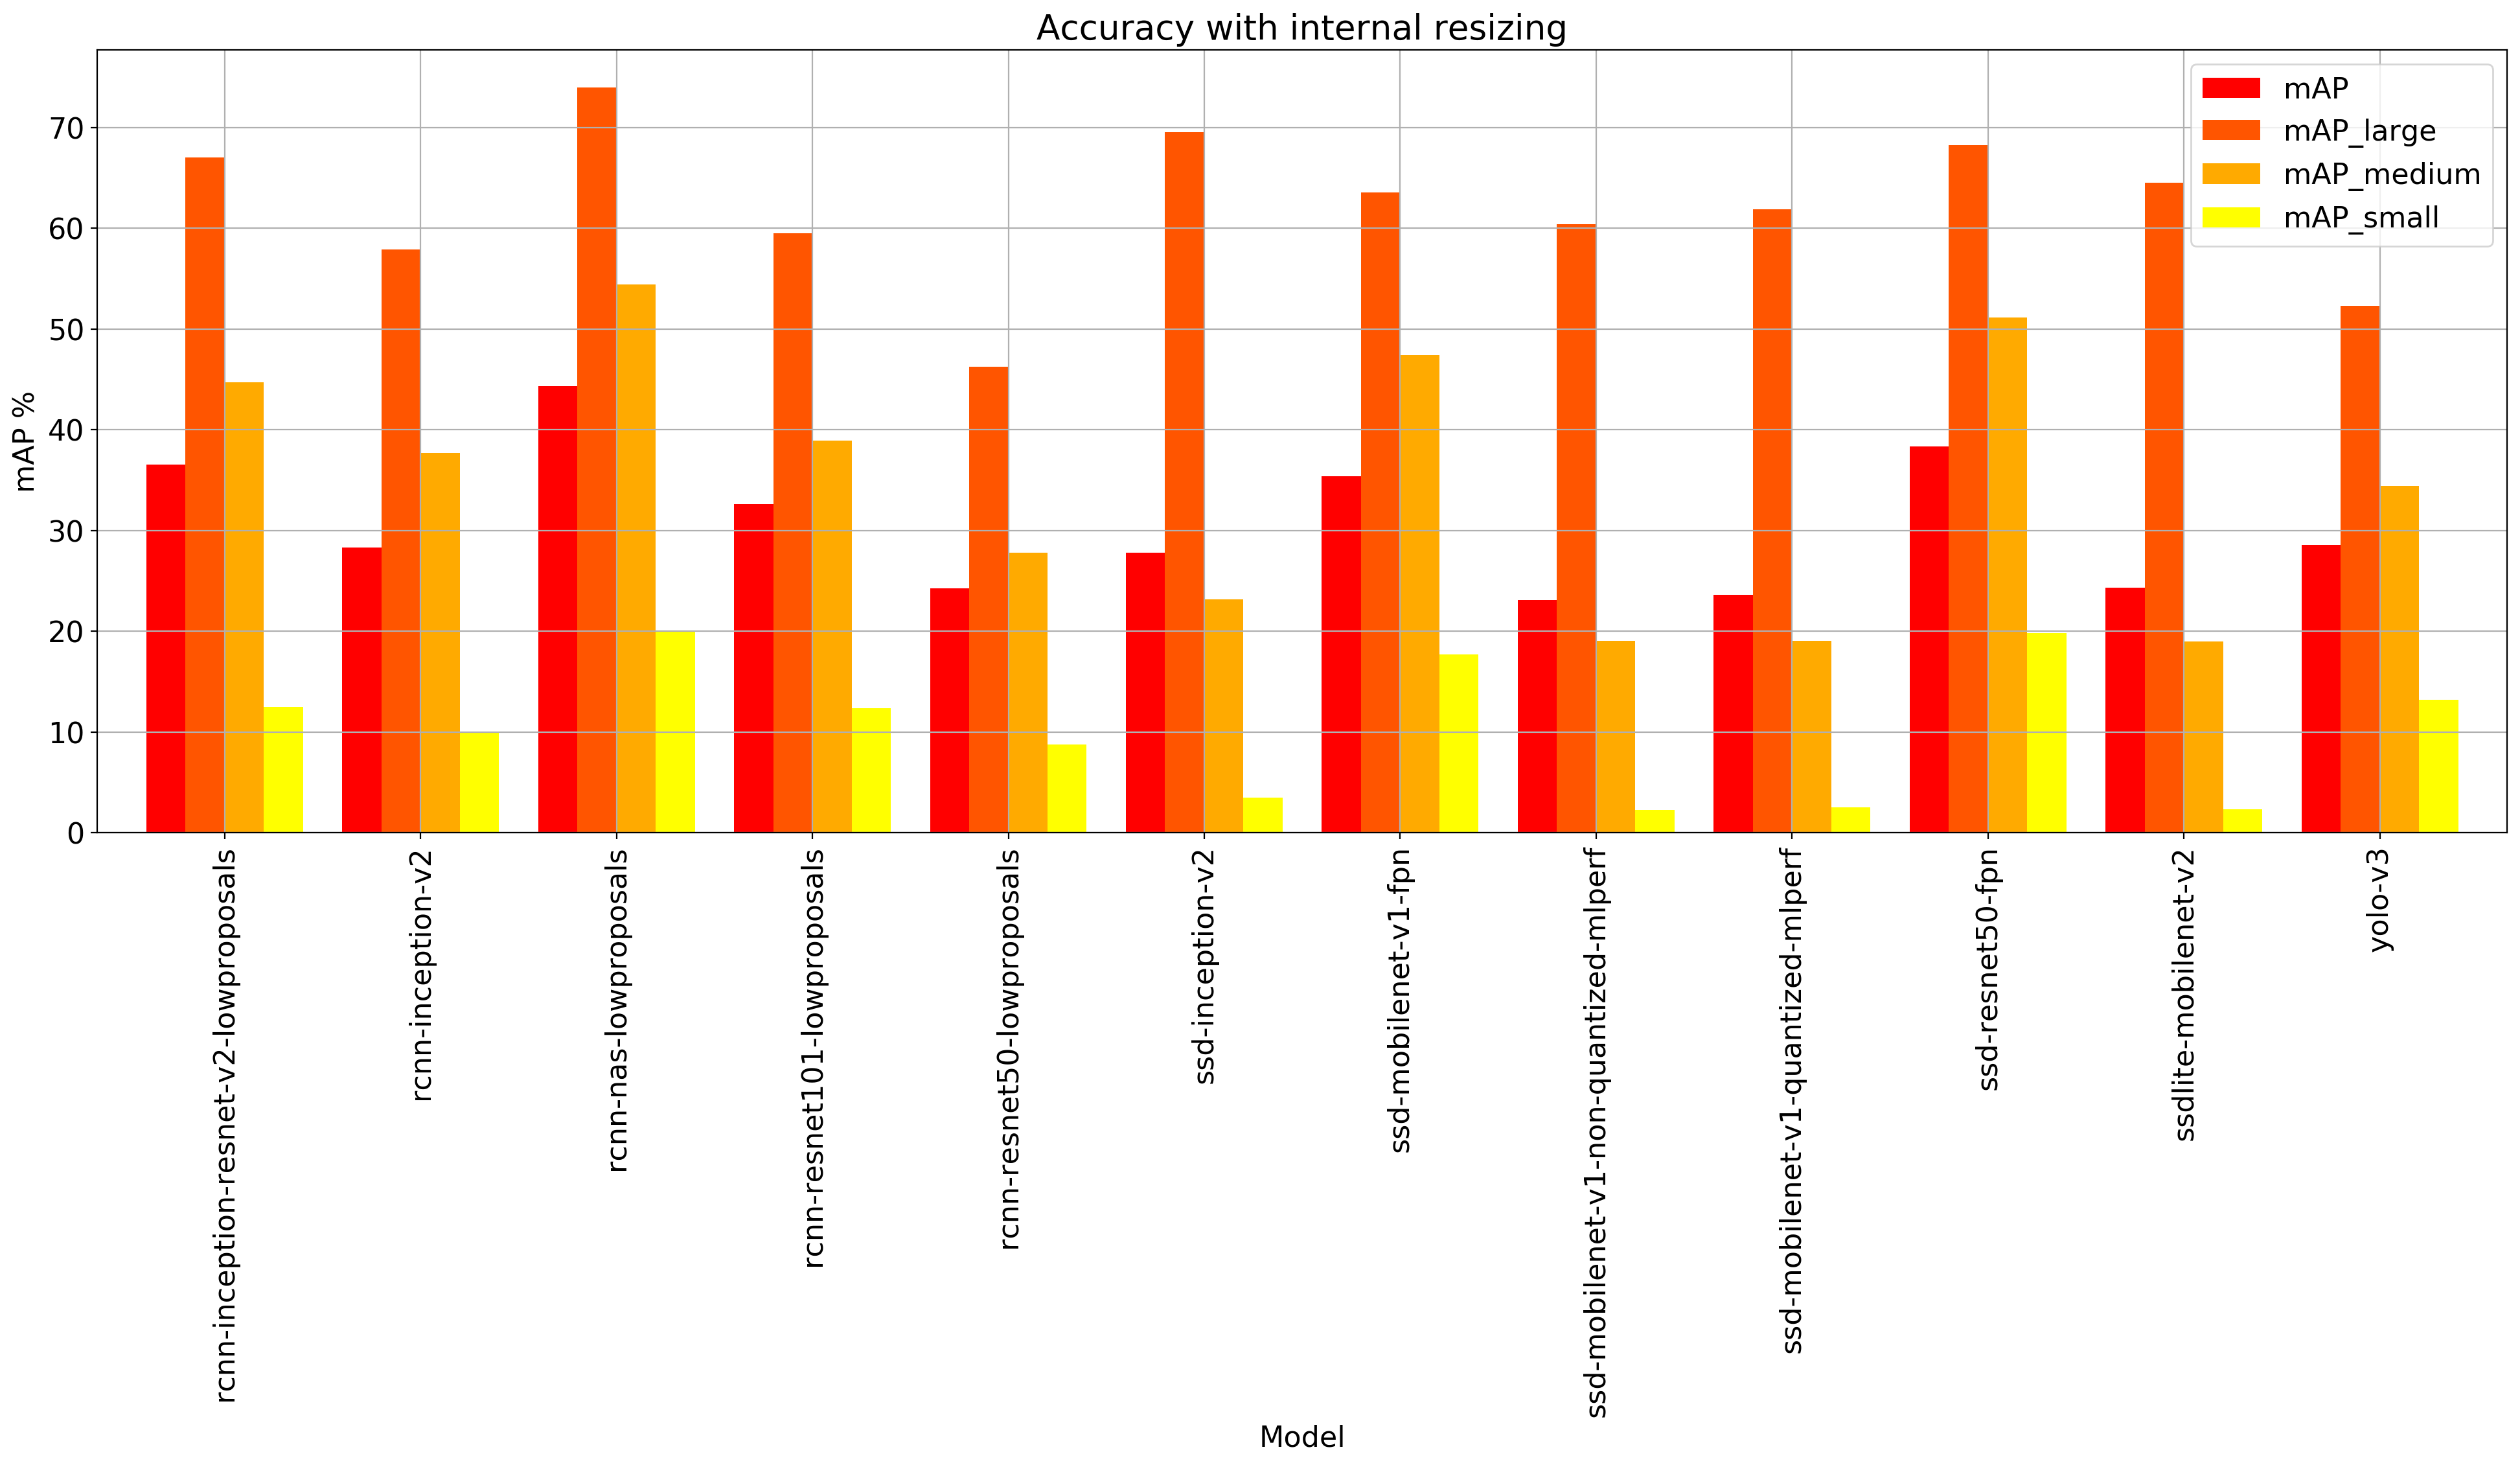

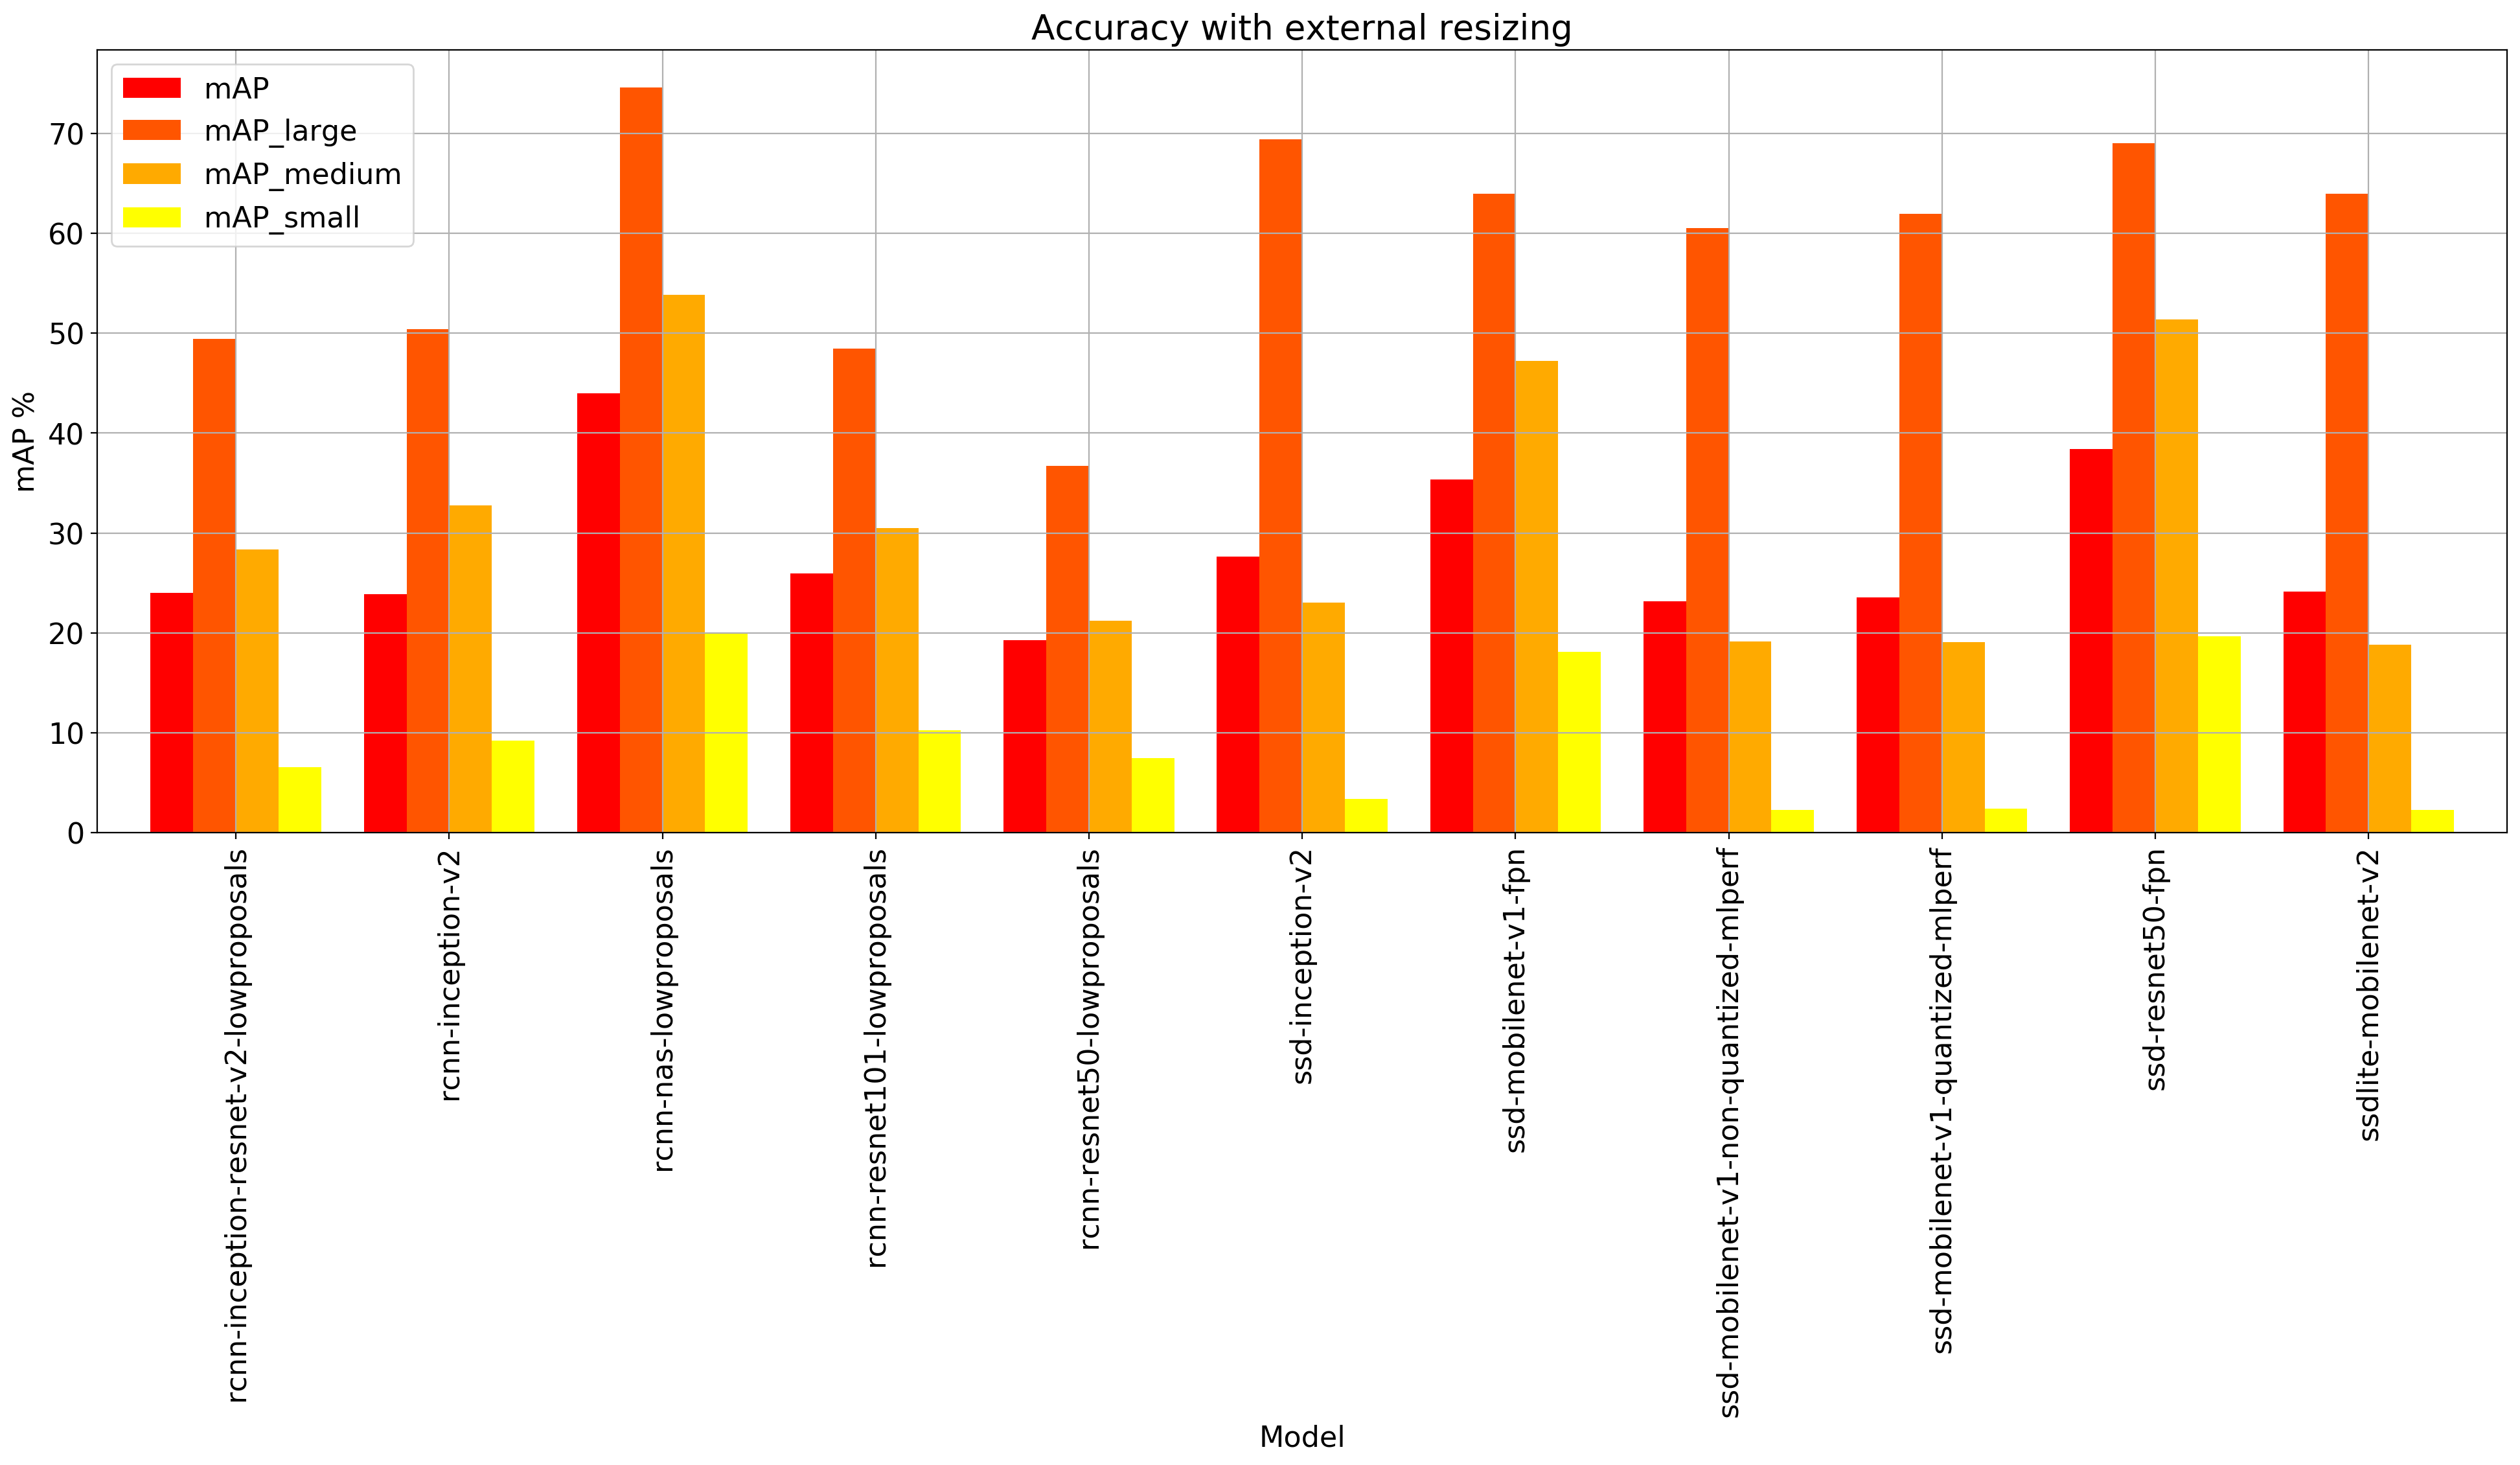

In [15]:
def plot_accuracy(df, groupby_level='batch_enabled',
                  accuracy_metric=['mAP','mAP_large','mAP_medium','mAP_small'],
                  save_fig=False, save_fig_name='accuracy.resizing.', resize_type=['internal','external'],
                  title='', figsize=[default_figwidth, 8], rot=90, colormap=cm.autumn):
    # Bars.
    df_bar = pd.DataFrame(
        data=df[accuracy_metric].values, columns=accuracy_metric,
        index=pd.MultiIndex.from_tuples(
            tuples=[ (m,be,nr) for (m,b,bs,bc,be,ih,iw,nr) in df.index.values ],
            names=[ 'model','batch_enabled','num_reps' ]
        )
    )

    # Plot.
    mean = df_bar.groupby(level=df_bar.index.names[:-1]).mean()
    std = pd.Series()
    axes = mean \
            .groupby(level=groupby_level) \
            .plot(yerr=std, kind='bar', grid=True, rot=rot,
                  figsize=figsize, width=default_barwidth, fontsize=default_fontsize, colormap=colormap)

    xlabel = 'Model'
    xtics  = df_bar.index.get_level_values('model').drop_duplicates()
    ylabel = 'mAP %'
    for count, ax in enumerate(axes):
        # Title.
        ax.set_title('Accuracy with %s resizing' % resize_type[count])
        # X label.
        ax.set_xlabel(xlabel)
        # X ticks.
        ax.set_xticklabels(xtics)
        # Y axis.
        ax.set_ylabel(ylabel)
        if save_fig:
            save_fig_path = os.path.join(save_fig_dir, '%s.%s' % (save_fig_name+resize_type[count], save_fig_ext))
            ax.figure.savefig(save_fig_path, dpi=default_figdpi, bbox_inches='tight')        

plot_accuracy(dfs, save_fig=True)

#### Resizing layer in the network

There are two types of resizing: __fixed__ and __keep_aspect_ratio__.

The first one takes as input the image and returns an image of fixed dimensions, changing from network to network.
Using this layer are the following networks:

       - 'ssd_mobilenet_v1_fpn_coco', 640*640
       - 'faster_rcnn_nas_lowproposals_coco', 1200*1200
       - 'faster_rcnn_nas', 1200*1200
       - 'ssd_inception_v2_coco', 300*300
       - 'ssd_mobilenet_v1_coco', 300*300
       - 'ssd_mobilenet_v1_quantized_coco', 300*300
       - 'ssd_resnet_50_fpn_coco', 640*640
       - 'ssdlite_mobilenet_v2_coco', 300*300
       - 'yolo v3', 416*416
       
The second one behaviour is actually not completely clear, and have a minimum and maximum dimension of the output images. network using this layer are:

       - 'faster_rcnn_inception_resnet_v2_atrous_lowproposals_coco', min: 600  max: 1024
       - 'faster_rcnn_inception_resnet_v2_atrous_coco', min: 600  max: 1024
       - 'faster_rcnn_resnet101_lowproposal_coco', min: 600  max: 1024
       - 'faster_rcnn_resnet50_lowproposals_coco', min: 600  max: 1024
       
From the analysis on the performance-accuracy benchmarks, it seems that the models using fixed resizing performs better than the one with the keep aspect ratio.

YOLO-v3 is actually in the middle ground: its preprocessing is doing a fixed resize to 416 * 416, however the resize is done keeping the aspect ratio and padding, outside the graph. The graph doesn't perform any resizing, but takes 416 * 416 images as input.

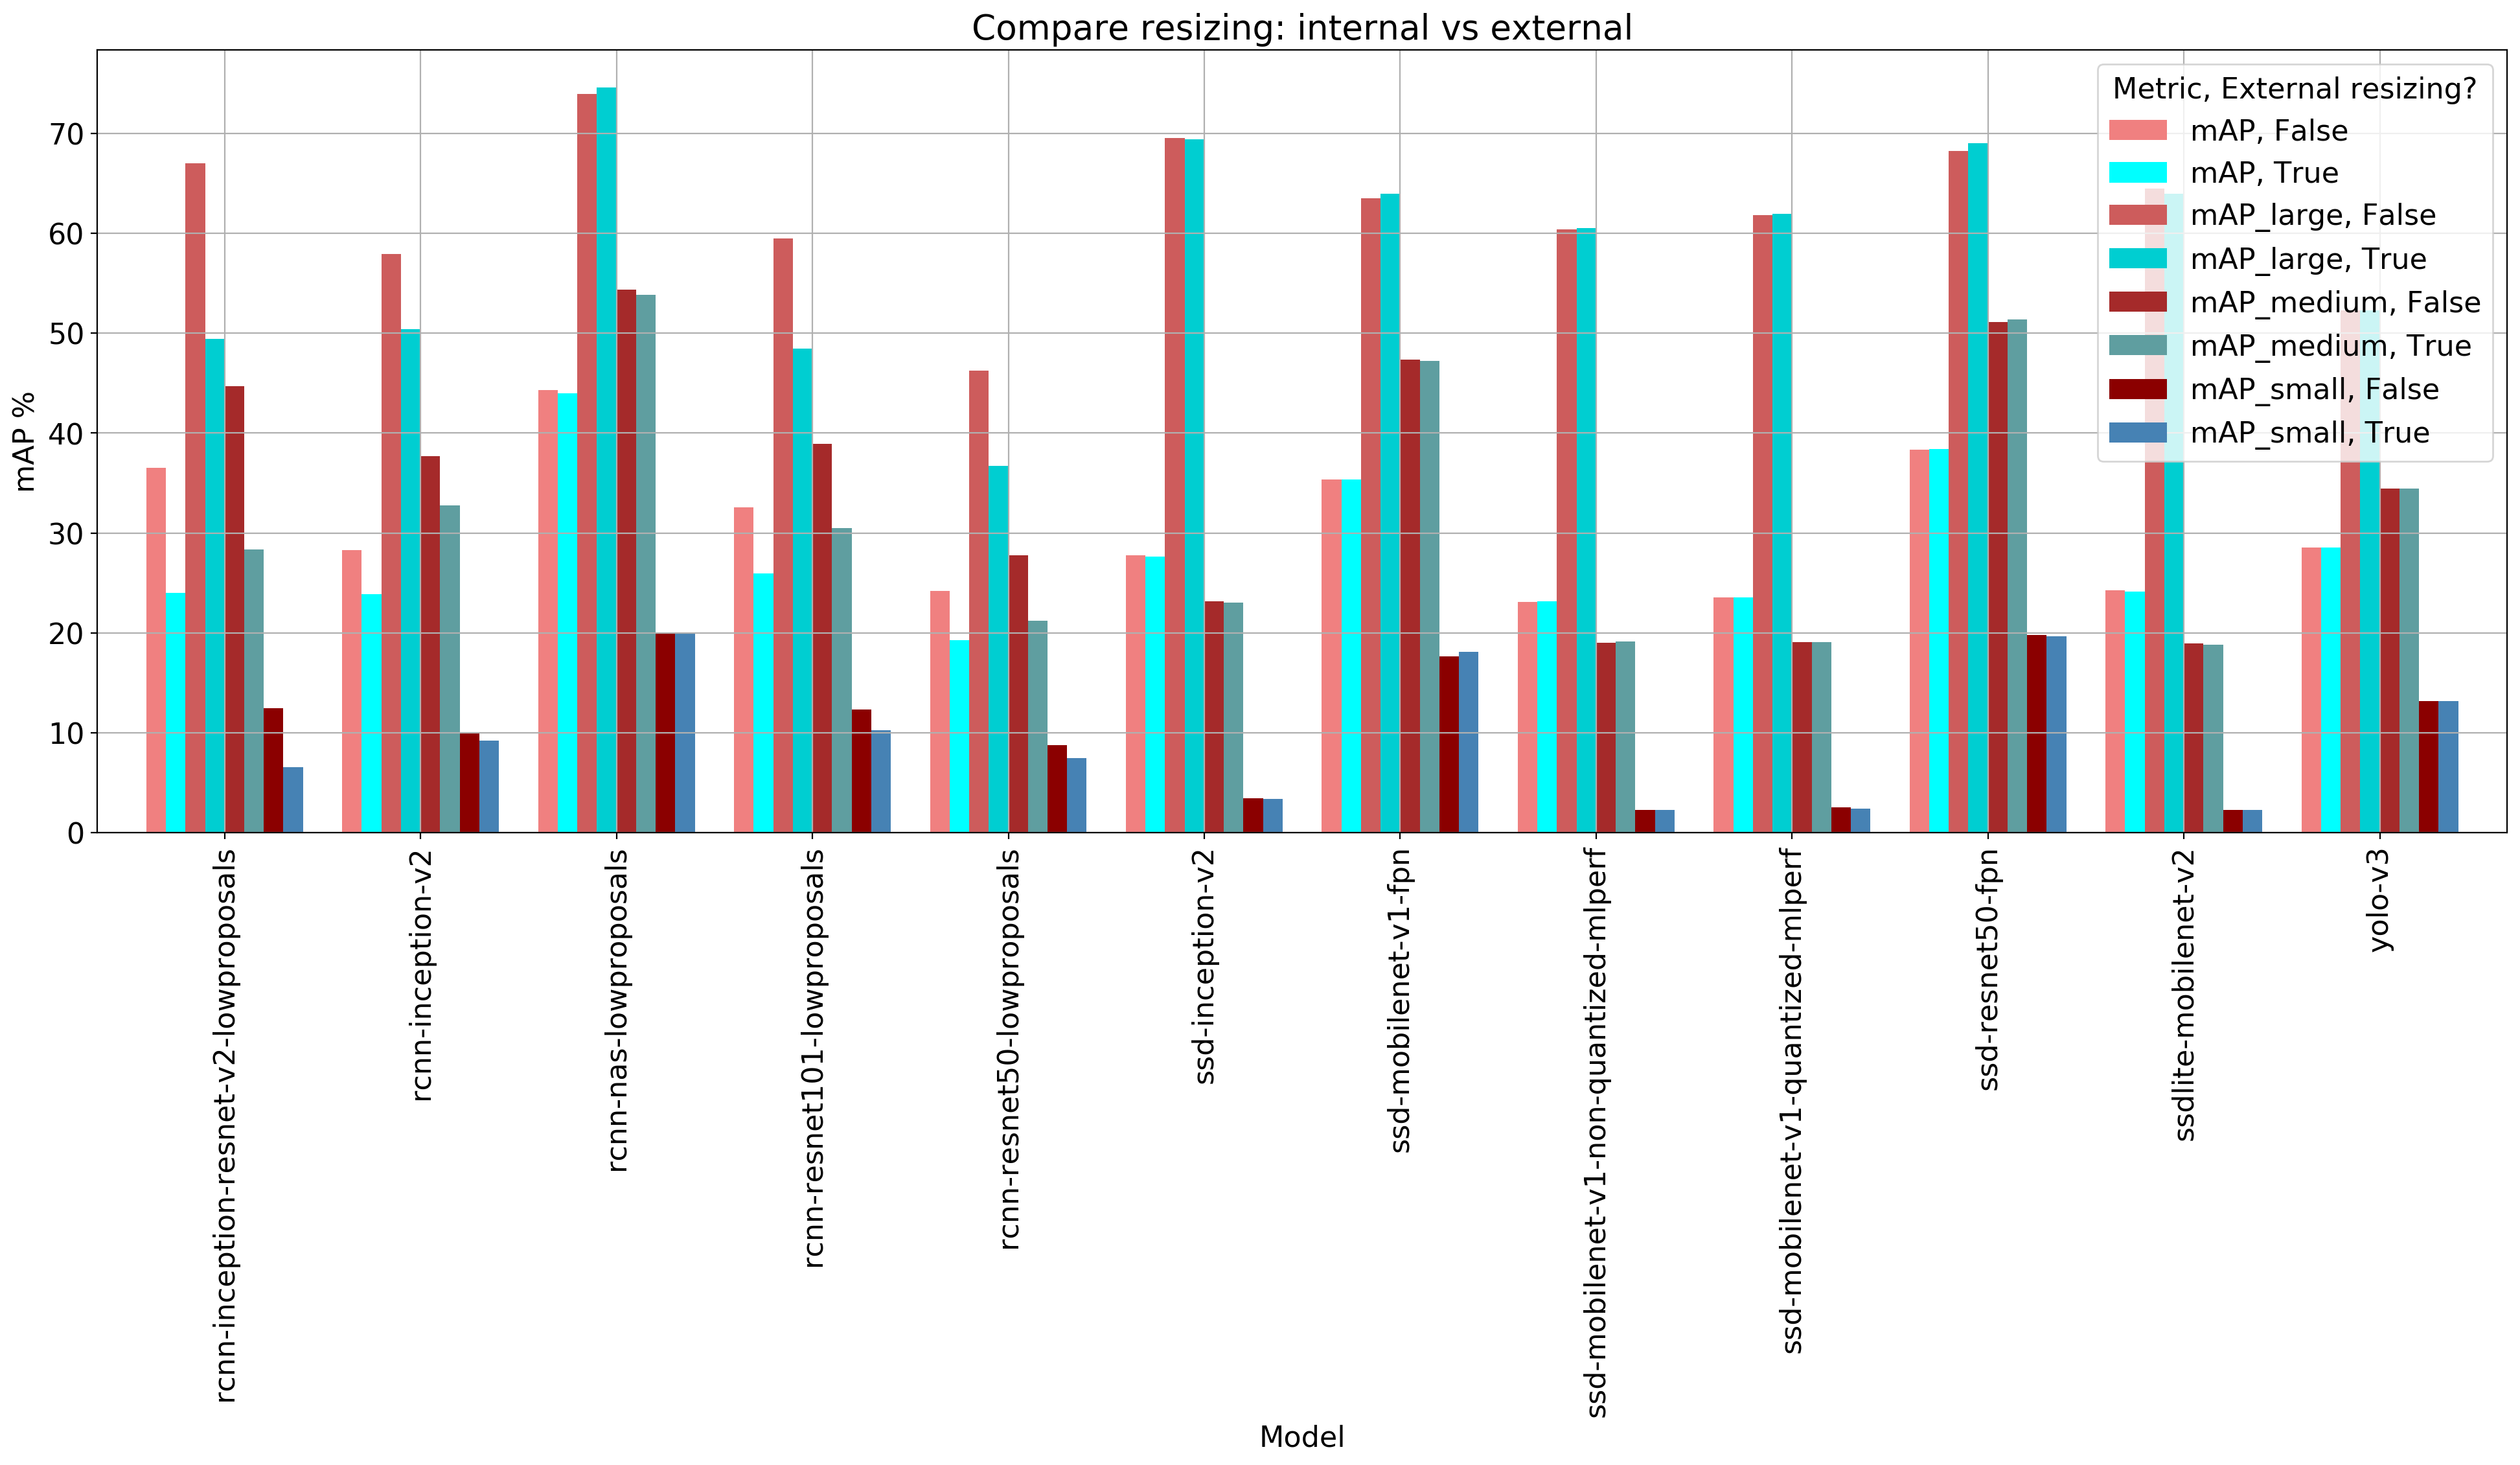

In [16]:
def plot_accuracy_compare_resizing(df_raw, resize_type=['internal','external'],
                                   unstack_level='batch_enabled', groupby_level='batch_size',
                                   accuracy_metric=['mAP','mAP_large','mAP_medium','mAP_small'], 
                                   save_fig=False, save_fig_name='accuracy.resizing.internal_vs_external',
                                   title='', figsize=[default_figwidth, 8], rot=90):
    # Bars.
    df_bar = pd.DataFrame(
        data=df_raw[accuracy_metric].values, columns=accuracy_metric,
        index=pd.MultiIndex.from_tuples(
            tuples=[ (m,be,bs,nr) for (m,b,bs,bc,be,ih,iw,nr) in df_raw.index.values ],
            names=[ 'model','batch_enabled','batch_size','num_reps' ]
        )
    )
    for index, row in df_bar.iterrows():
        (model, batch_enabled, batch_size, num_reps) = index
        if model == 'yolo-v3':
            # batch_size and num_reps are both 1 for accuracy experiments.
            df_bar.loc[(model, True, 1, 1)] = df_bar.loc[(model, False, 1, 1)][accuracy_metric]

    # Colormap.        
    colornames = [ 'lightcoral','cyan','indianred','darkturquoise','brown','cadetblue','darkred','steelblue' ]
    colormap = mp.colors.ListedColormap(colornames, name='from_list', N=len(colornames))

    # Plot.
    mean = df_bar.groupby(level=df_bar.index.names[:-1]).mean().unstack(unstack_level)
    std  = df_bar.groupby(level=df_bar.index.names[:-1]).std().unstack(unstack_level)
    axes = mean \
            .groupby(level=groupby_level) \
            .plot(yerr=std, kind='bar', grid=True, rot=rot,
                  figsize=figsize, width=default_barwidth, fontsize=default_fontsize, colormap=colormap)
    
    xlabel = 'Model'
    ylabel = 'mAP %'
    xtics  = df_bar.index.get_level_values('model').drop_duplicates()
    for count, ax in enumerate(axes):
        # Title.
        ax.set_title('Compare resizing: %s vs %s' % (resize_type[0], resize_type[1]))
        # X label.
        ax.set_xlabel(xlabel)
        # X ticks.
        ax.set_xticklabels(xtics)
        # Y axis.
        ax.set_ylabel(ylabel)
        patches, labels = ax.get_legend_handles_labels()
        # Legend.
        labels = [x.strip('(') for x in labels]
        labels = [x.strip(')') for x in labels]
        ax.legend(patches, labels, loc='best', title='Metric, External resizing?')
        if save_fig:
            save_fig_path = os.path.join(save_fig_dir, '%s.%s' % (save_fig_name, save_fig_ext))
            ax.figure.savefig(save_fig_path, dpi=default_figdpi, bbox_inches='tight')        

plot_accuracy_compare_resizing(dfs, save_fig=True)

<a id="plot_performance"></a>
### Plot performance

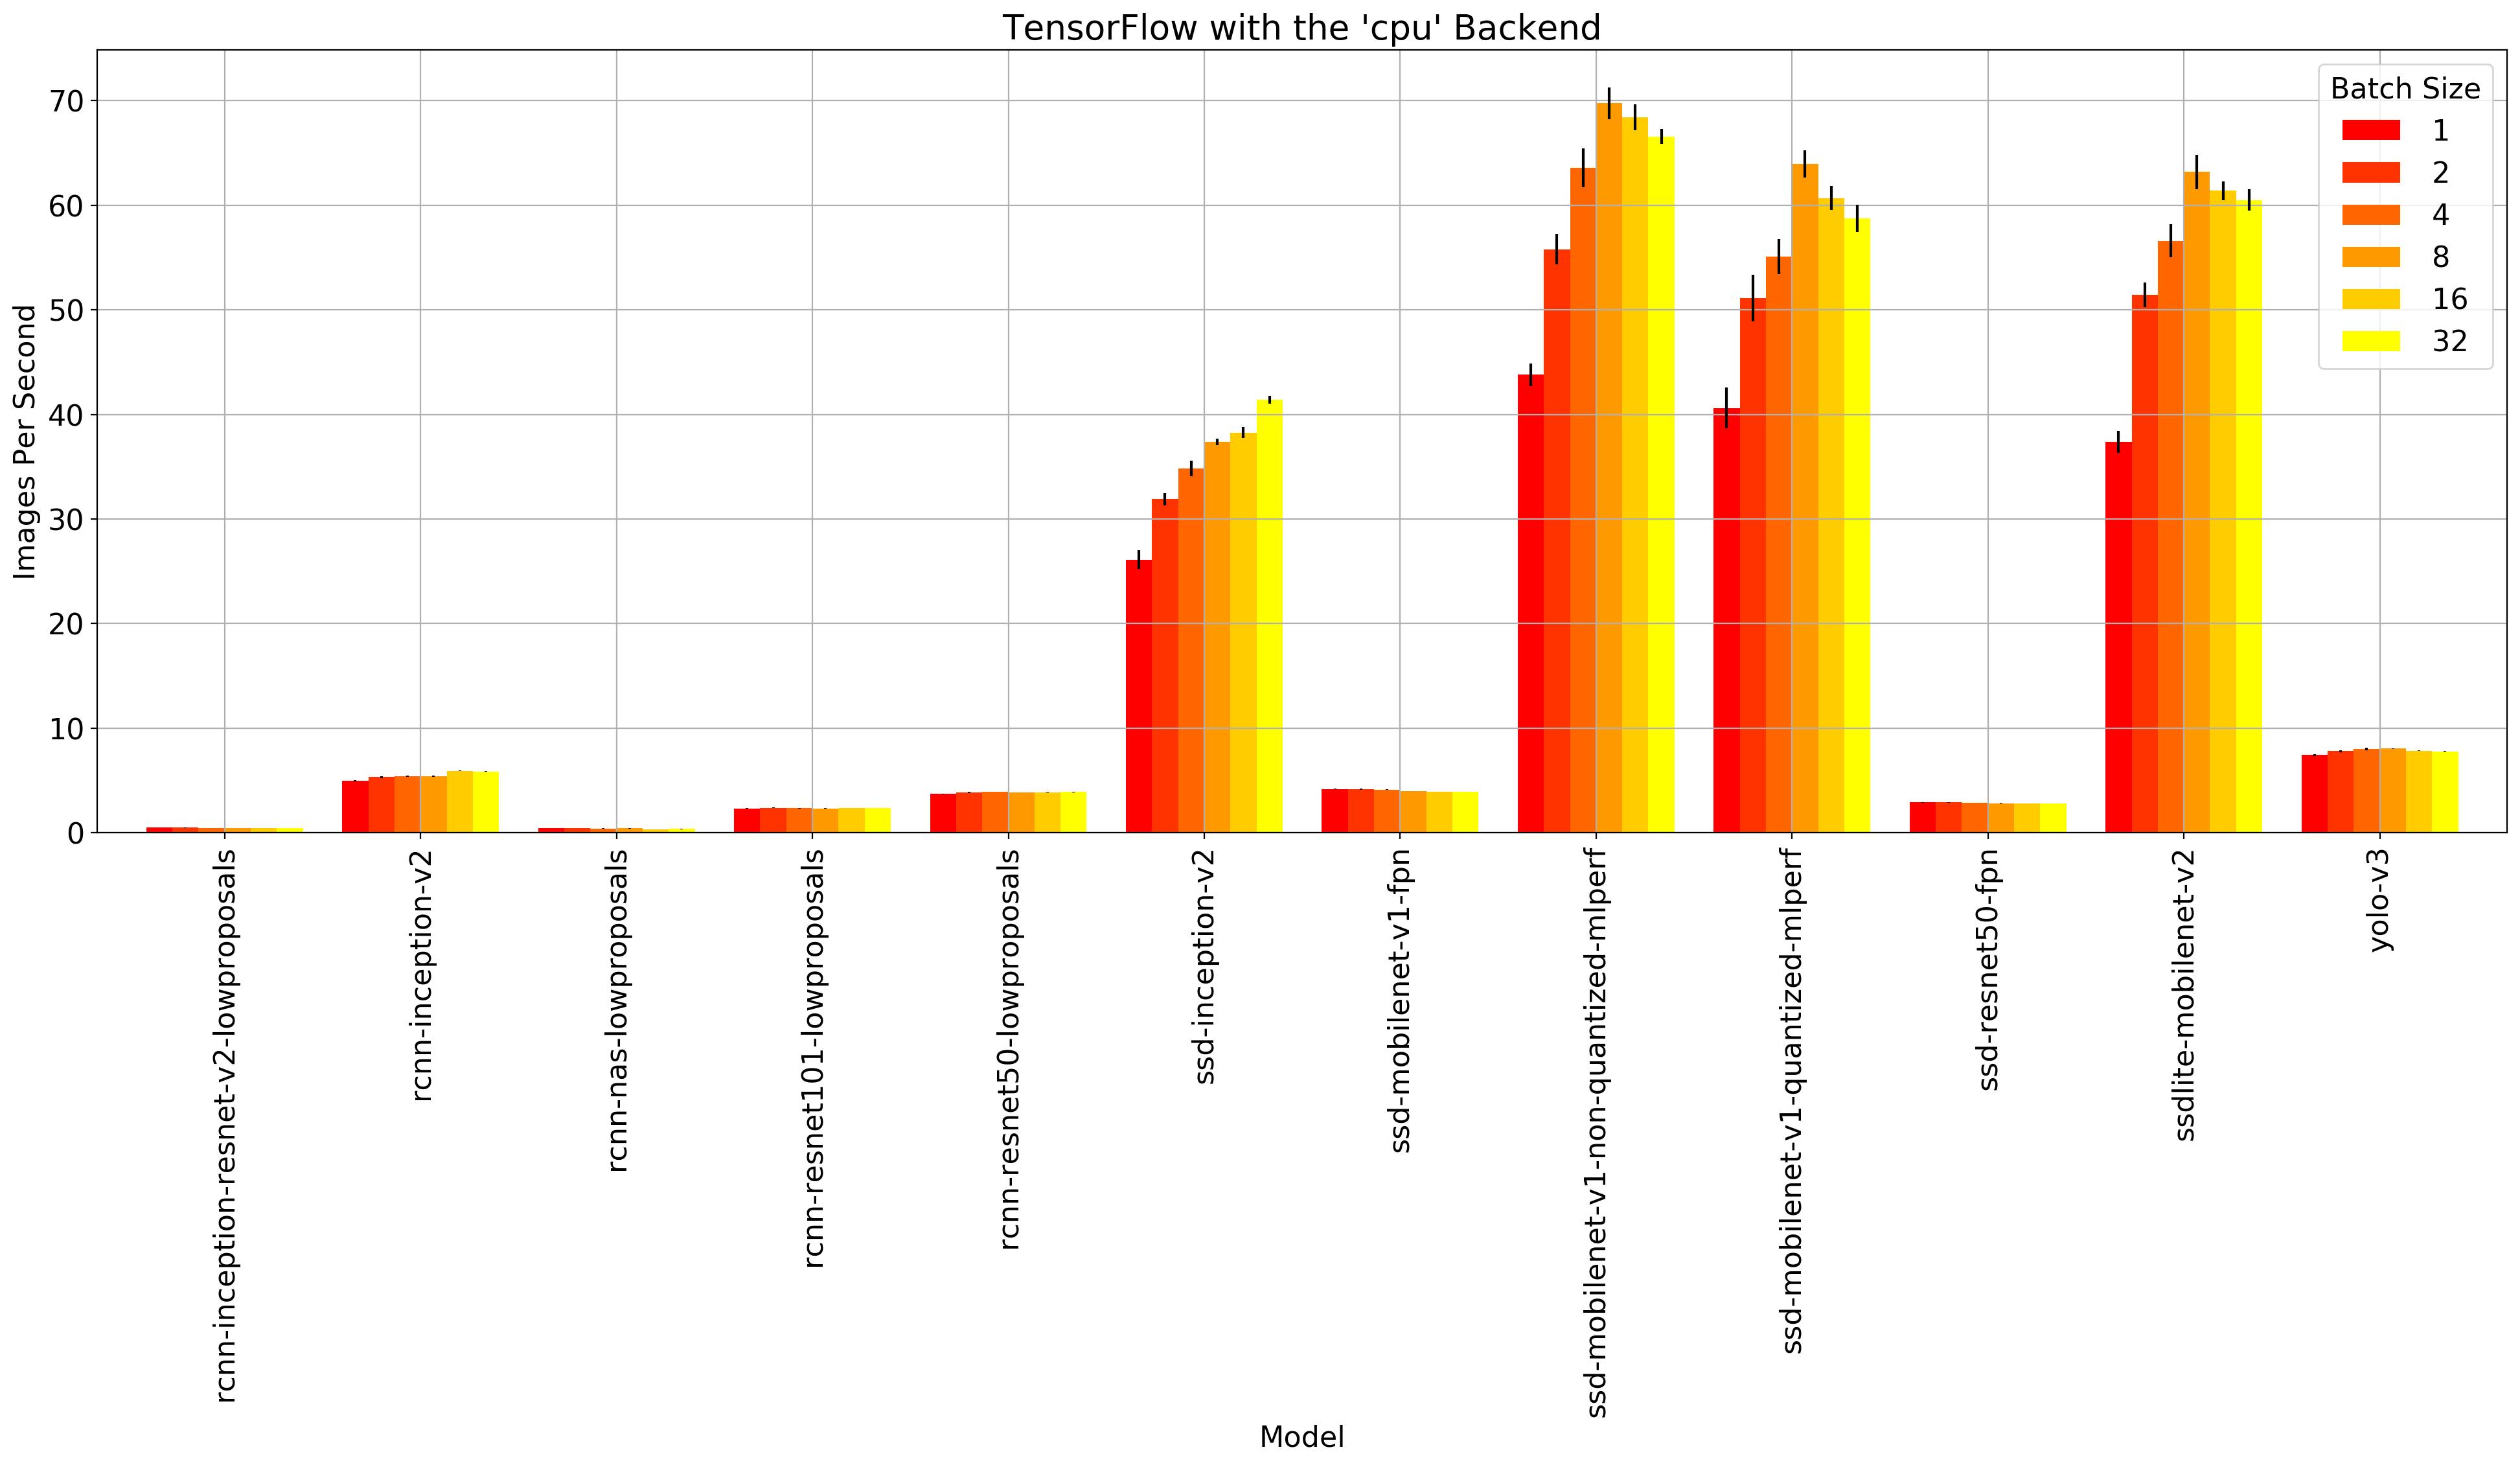

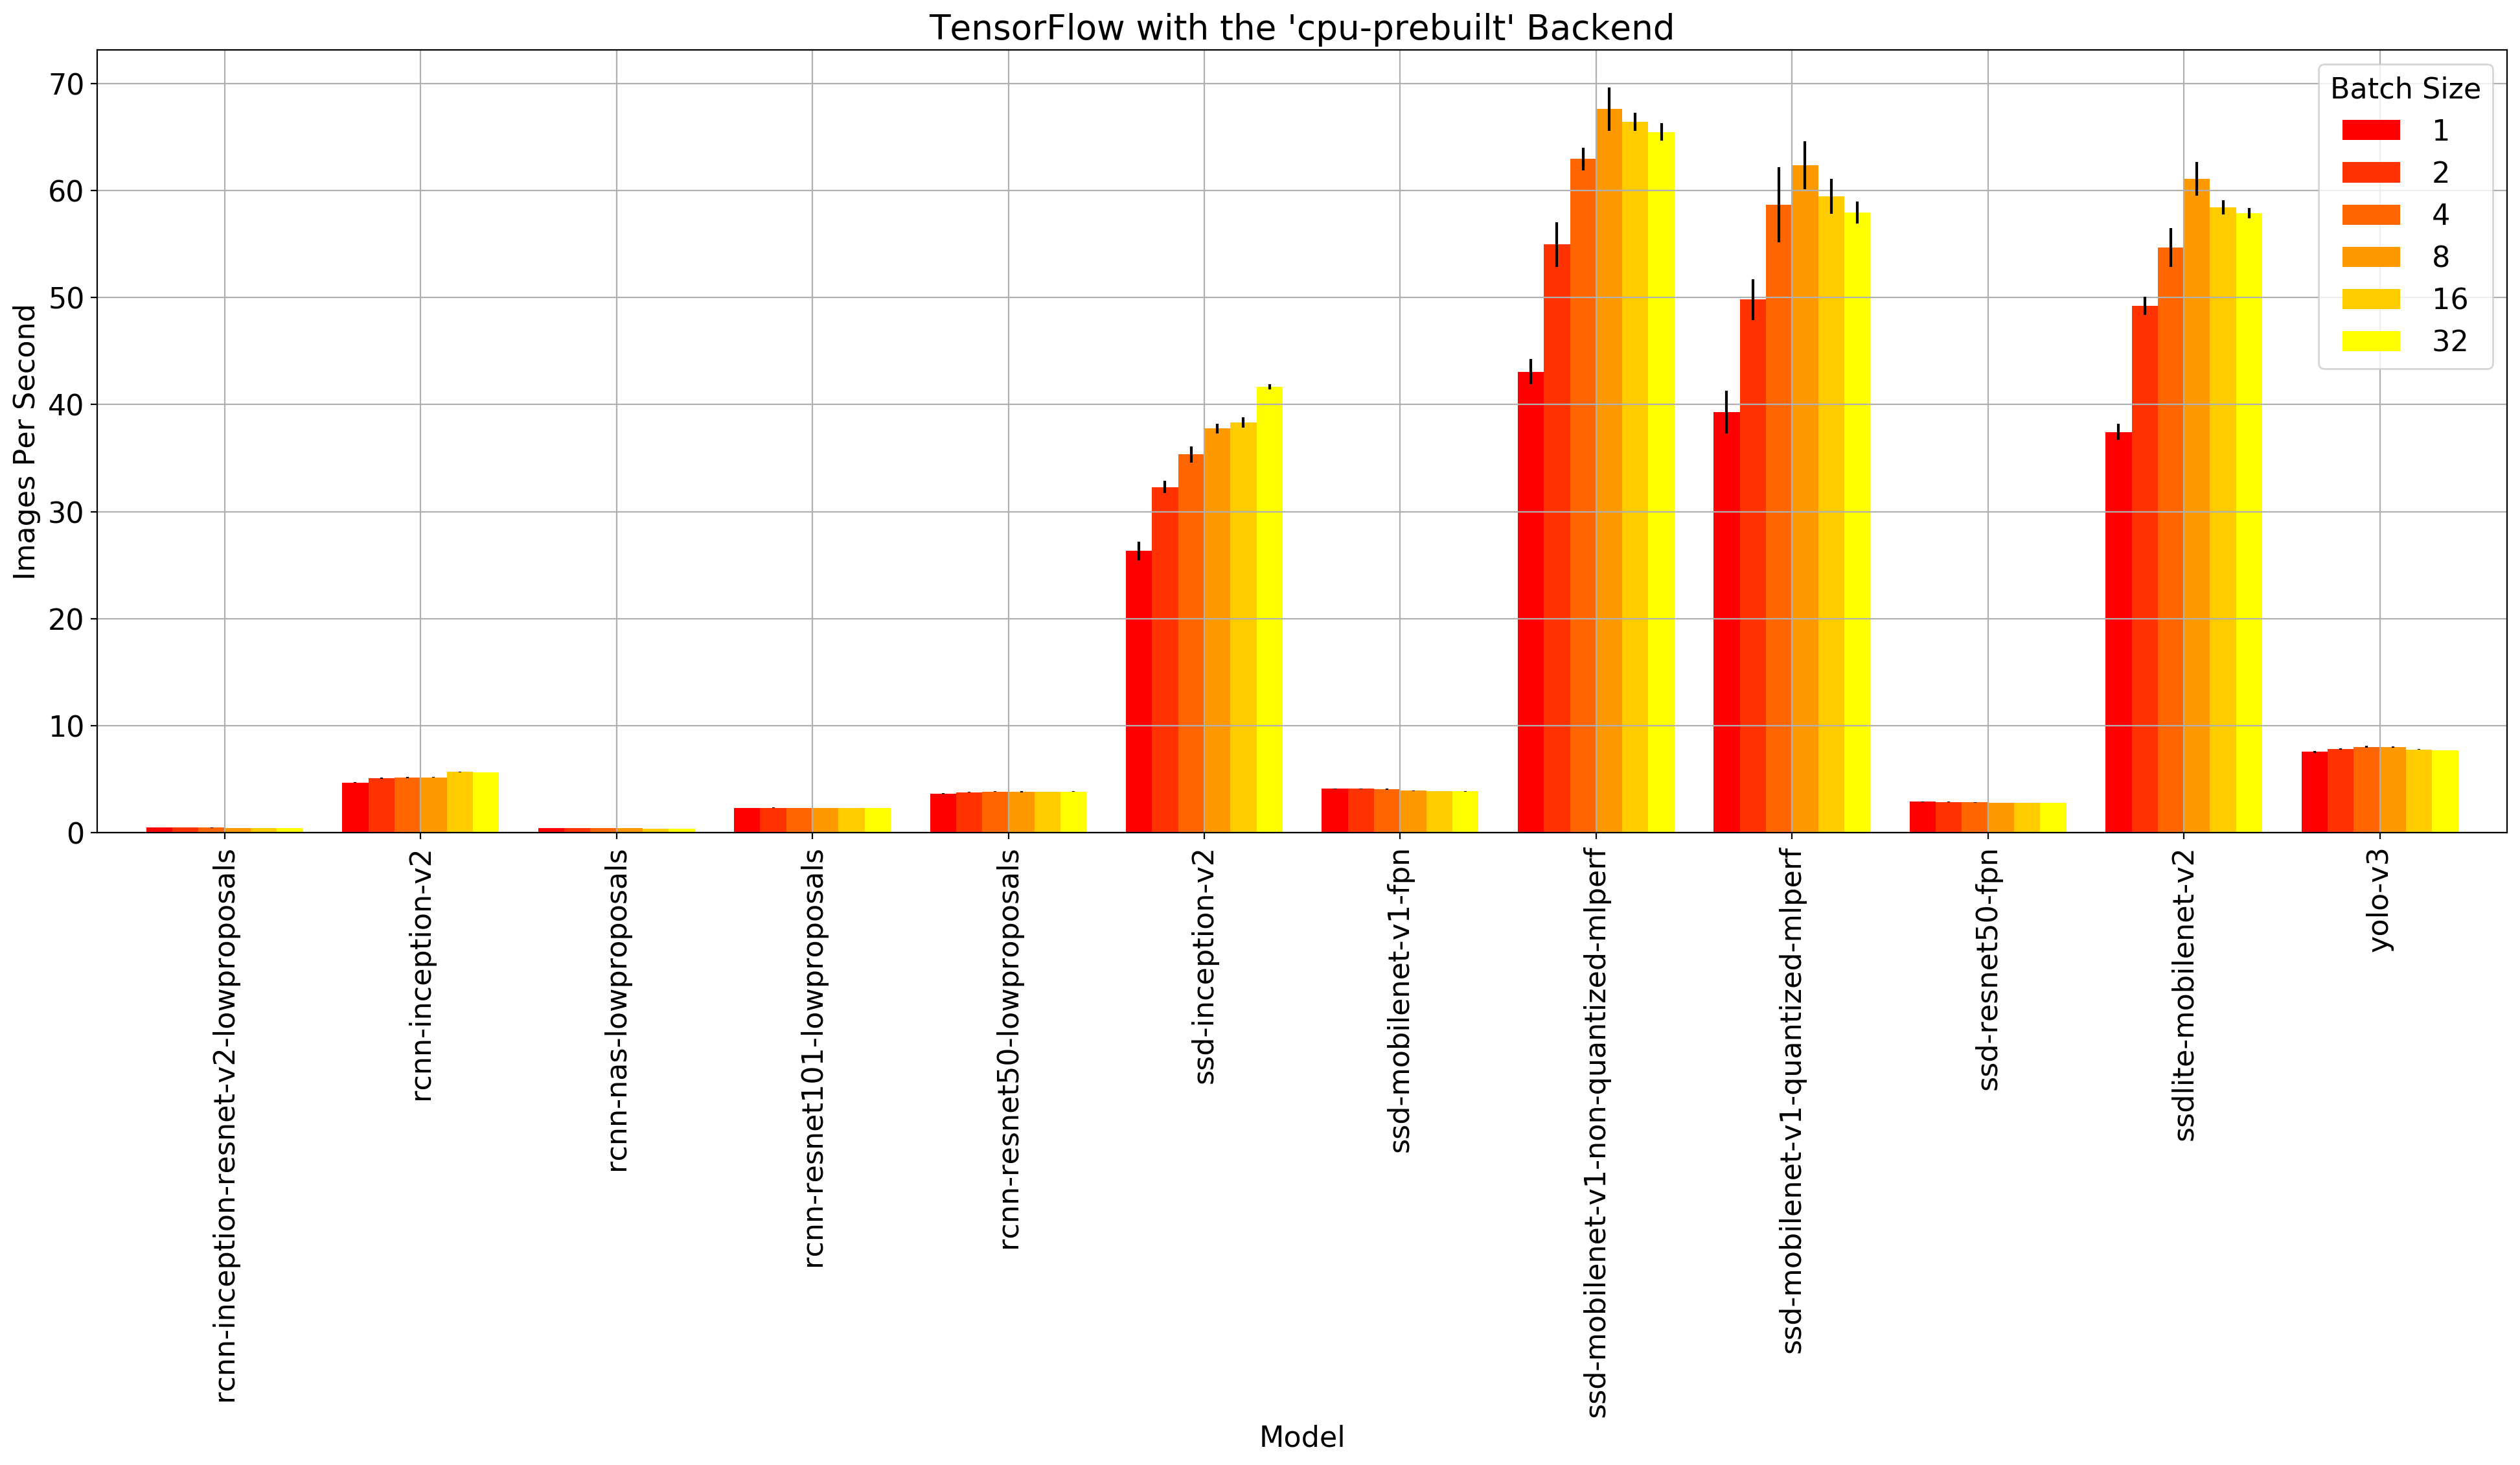

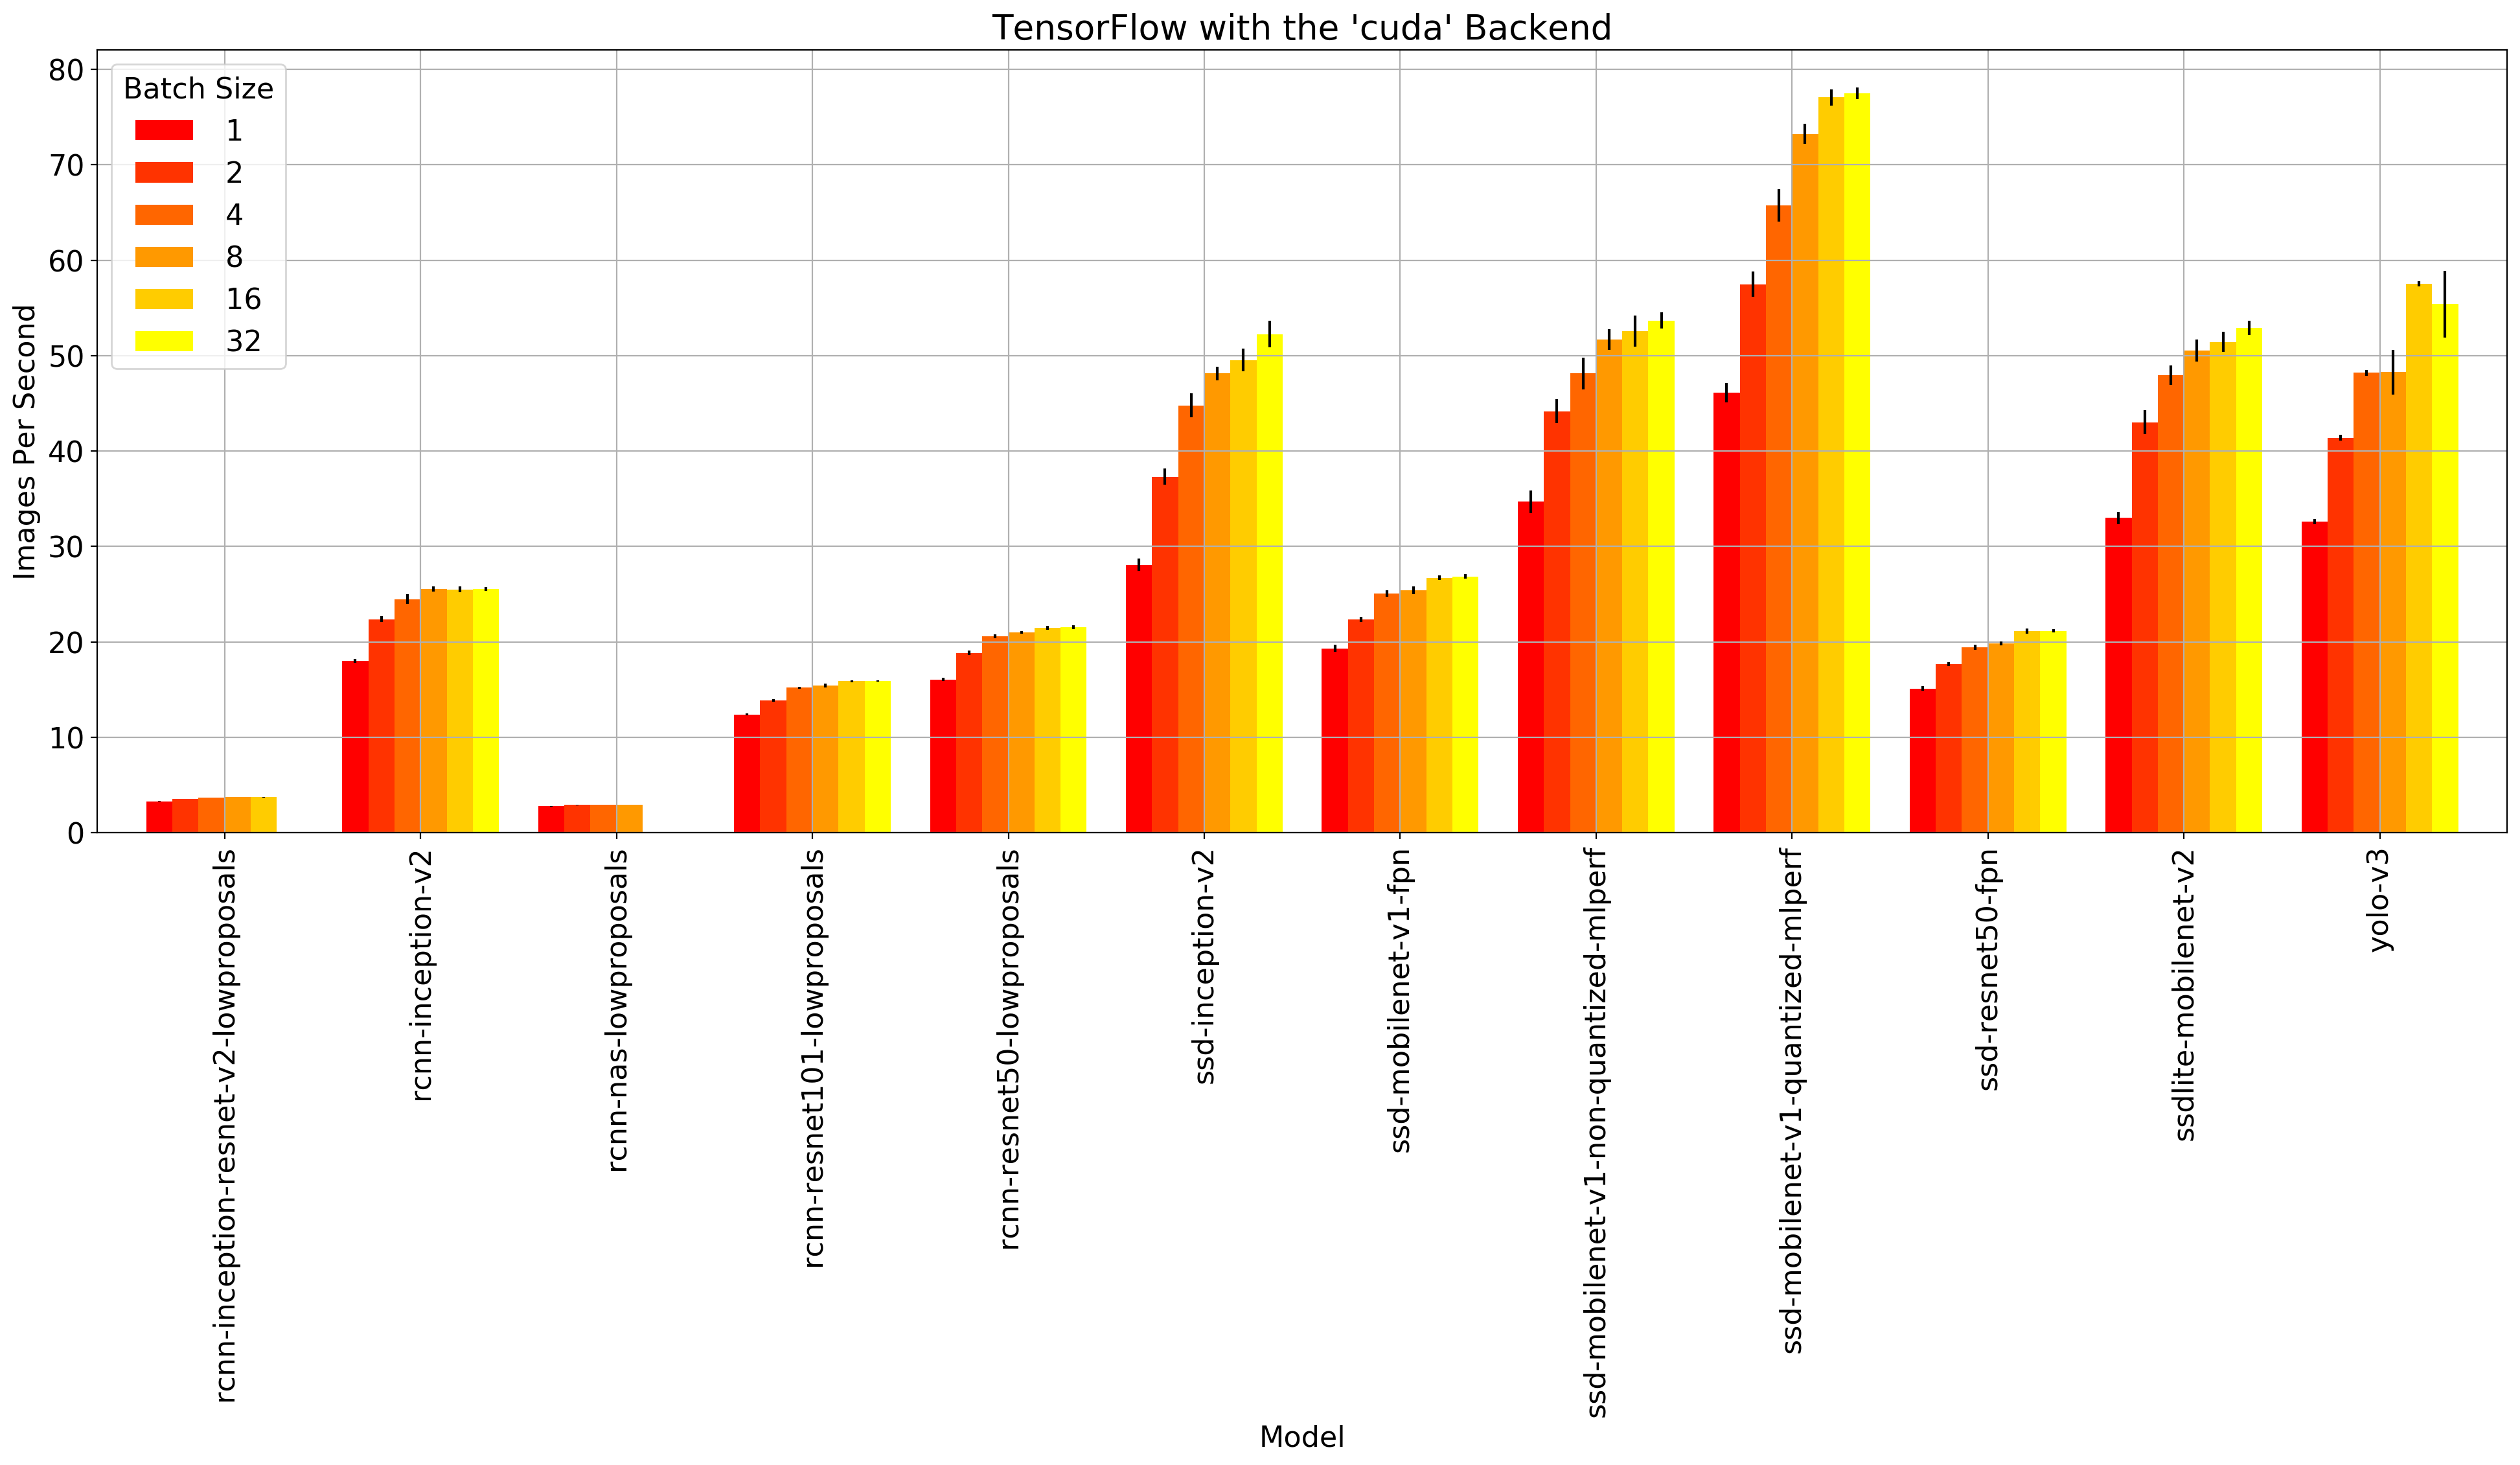

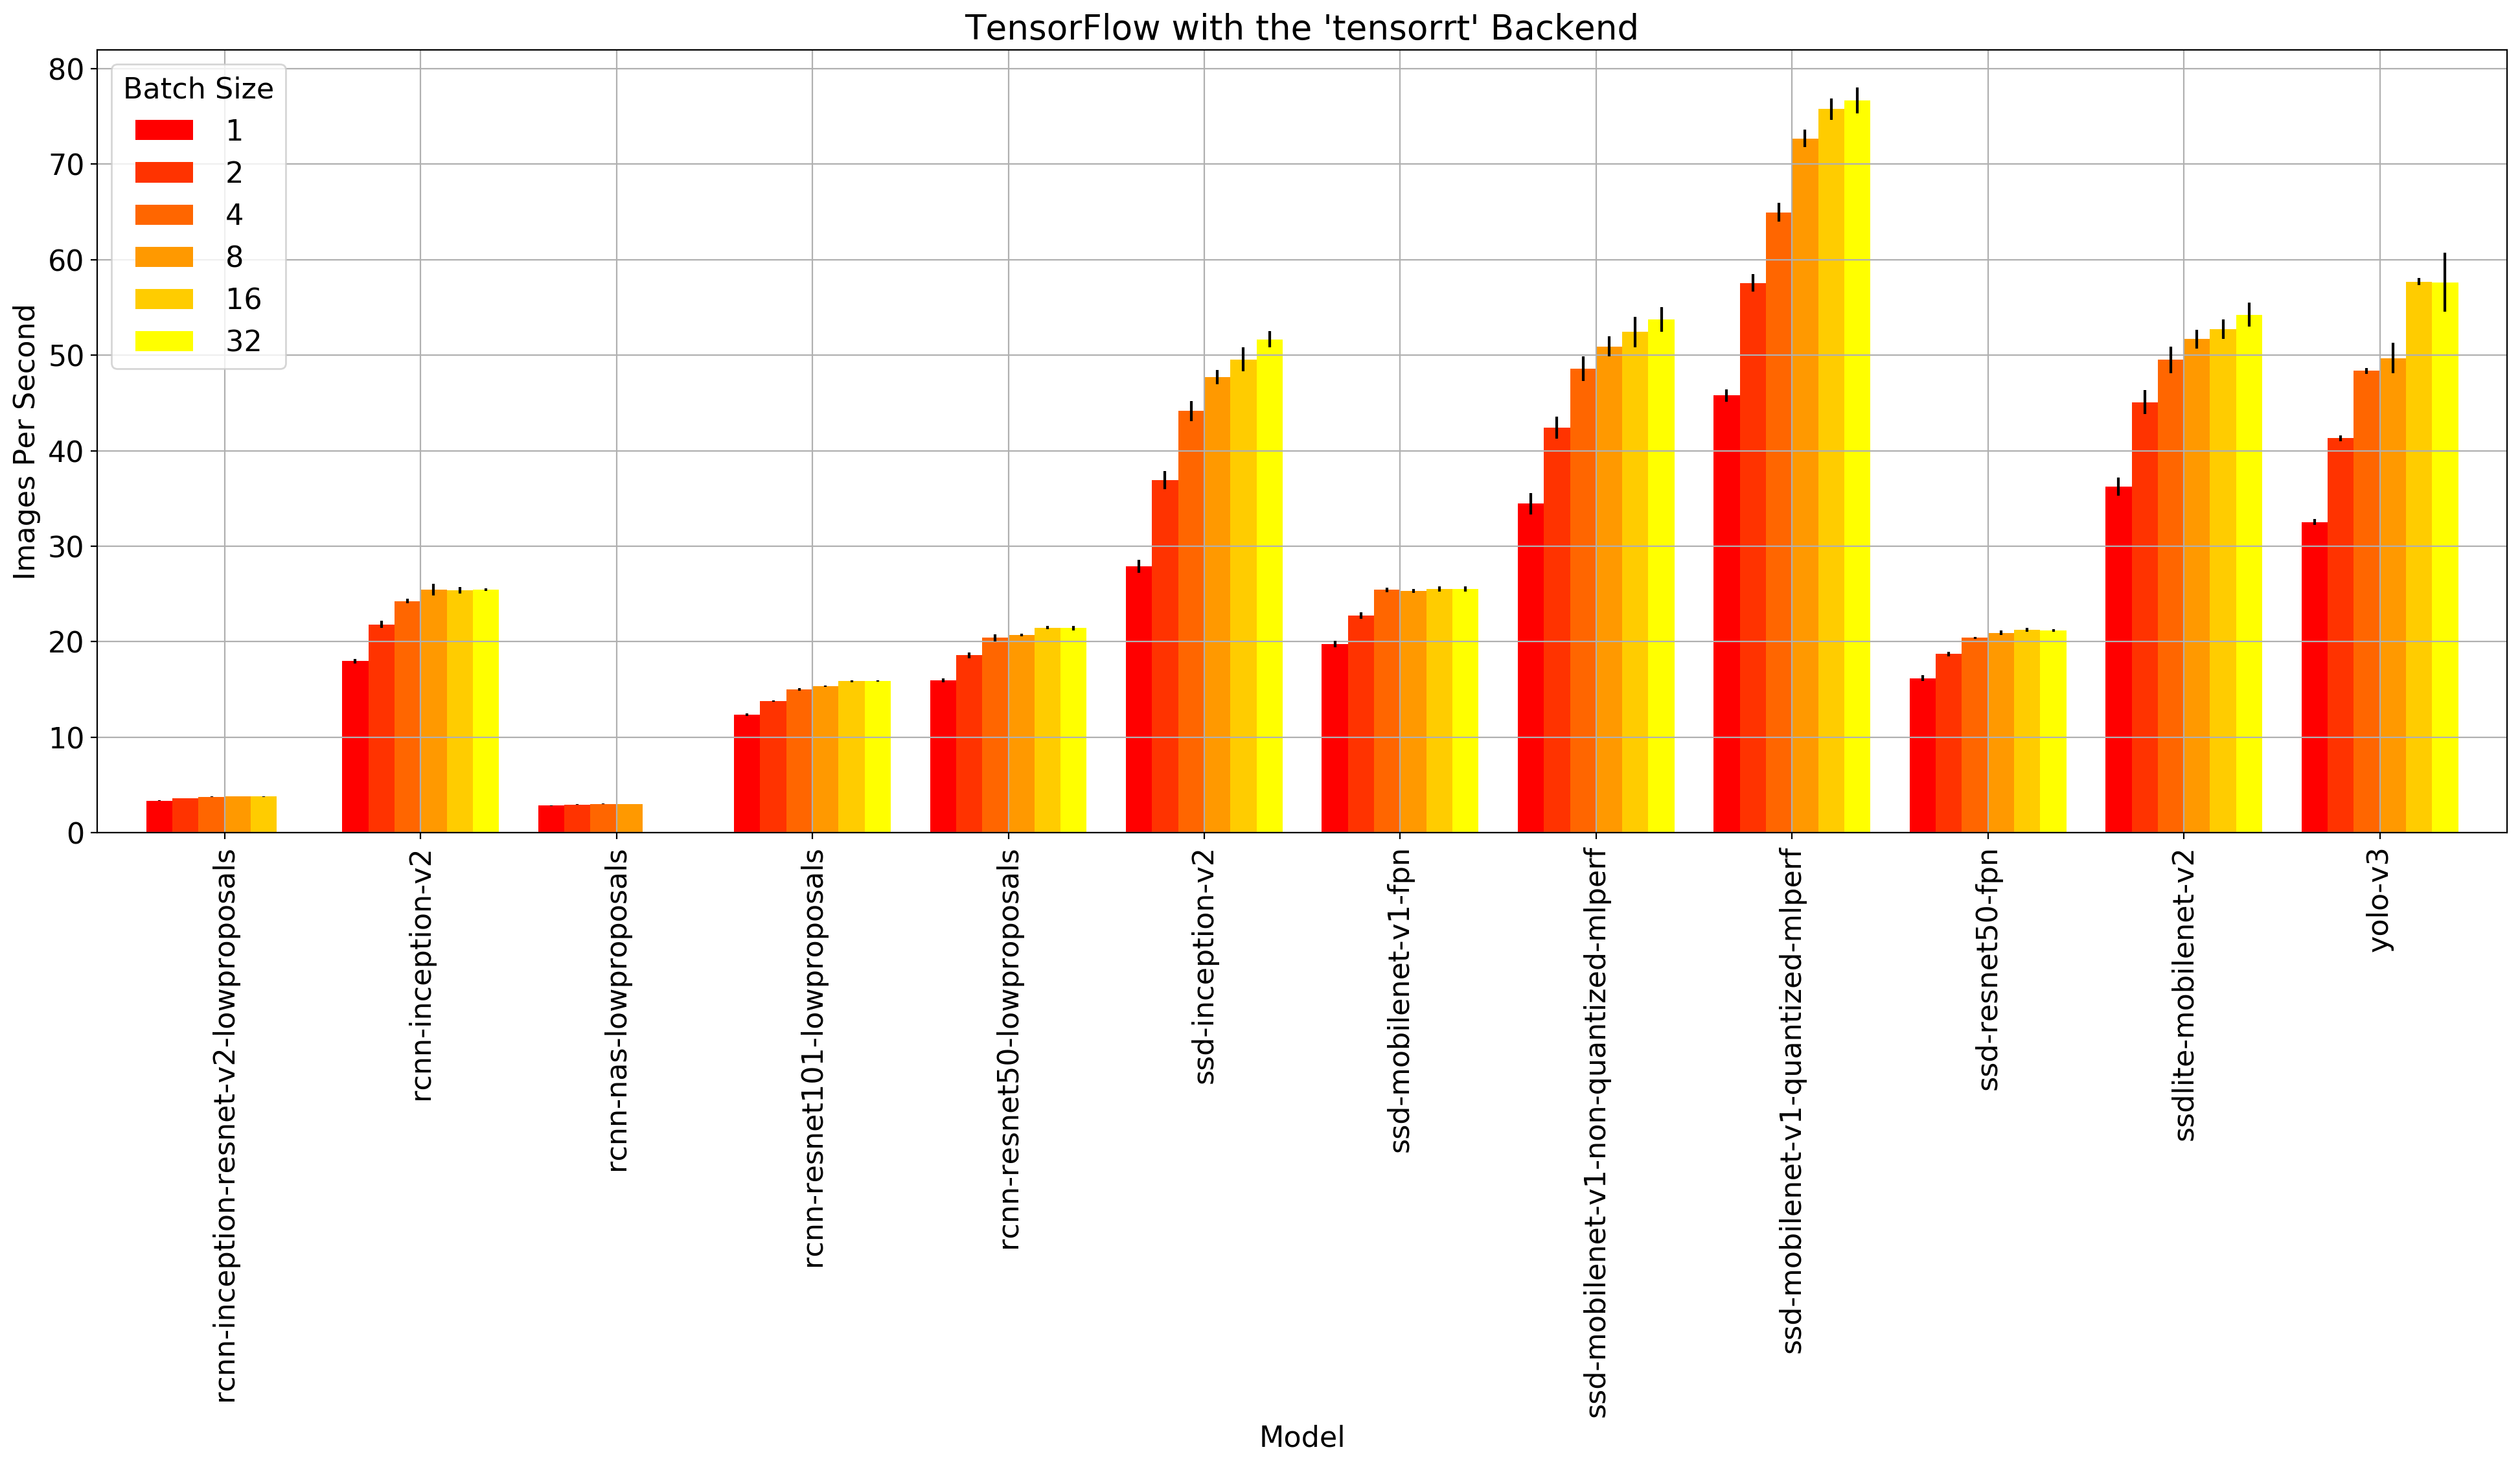

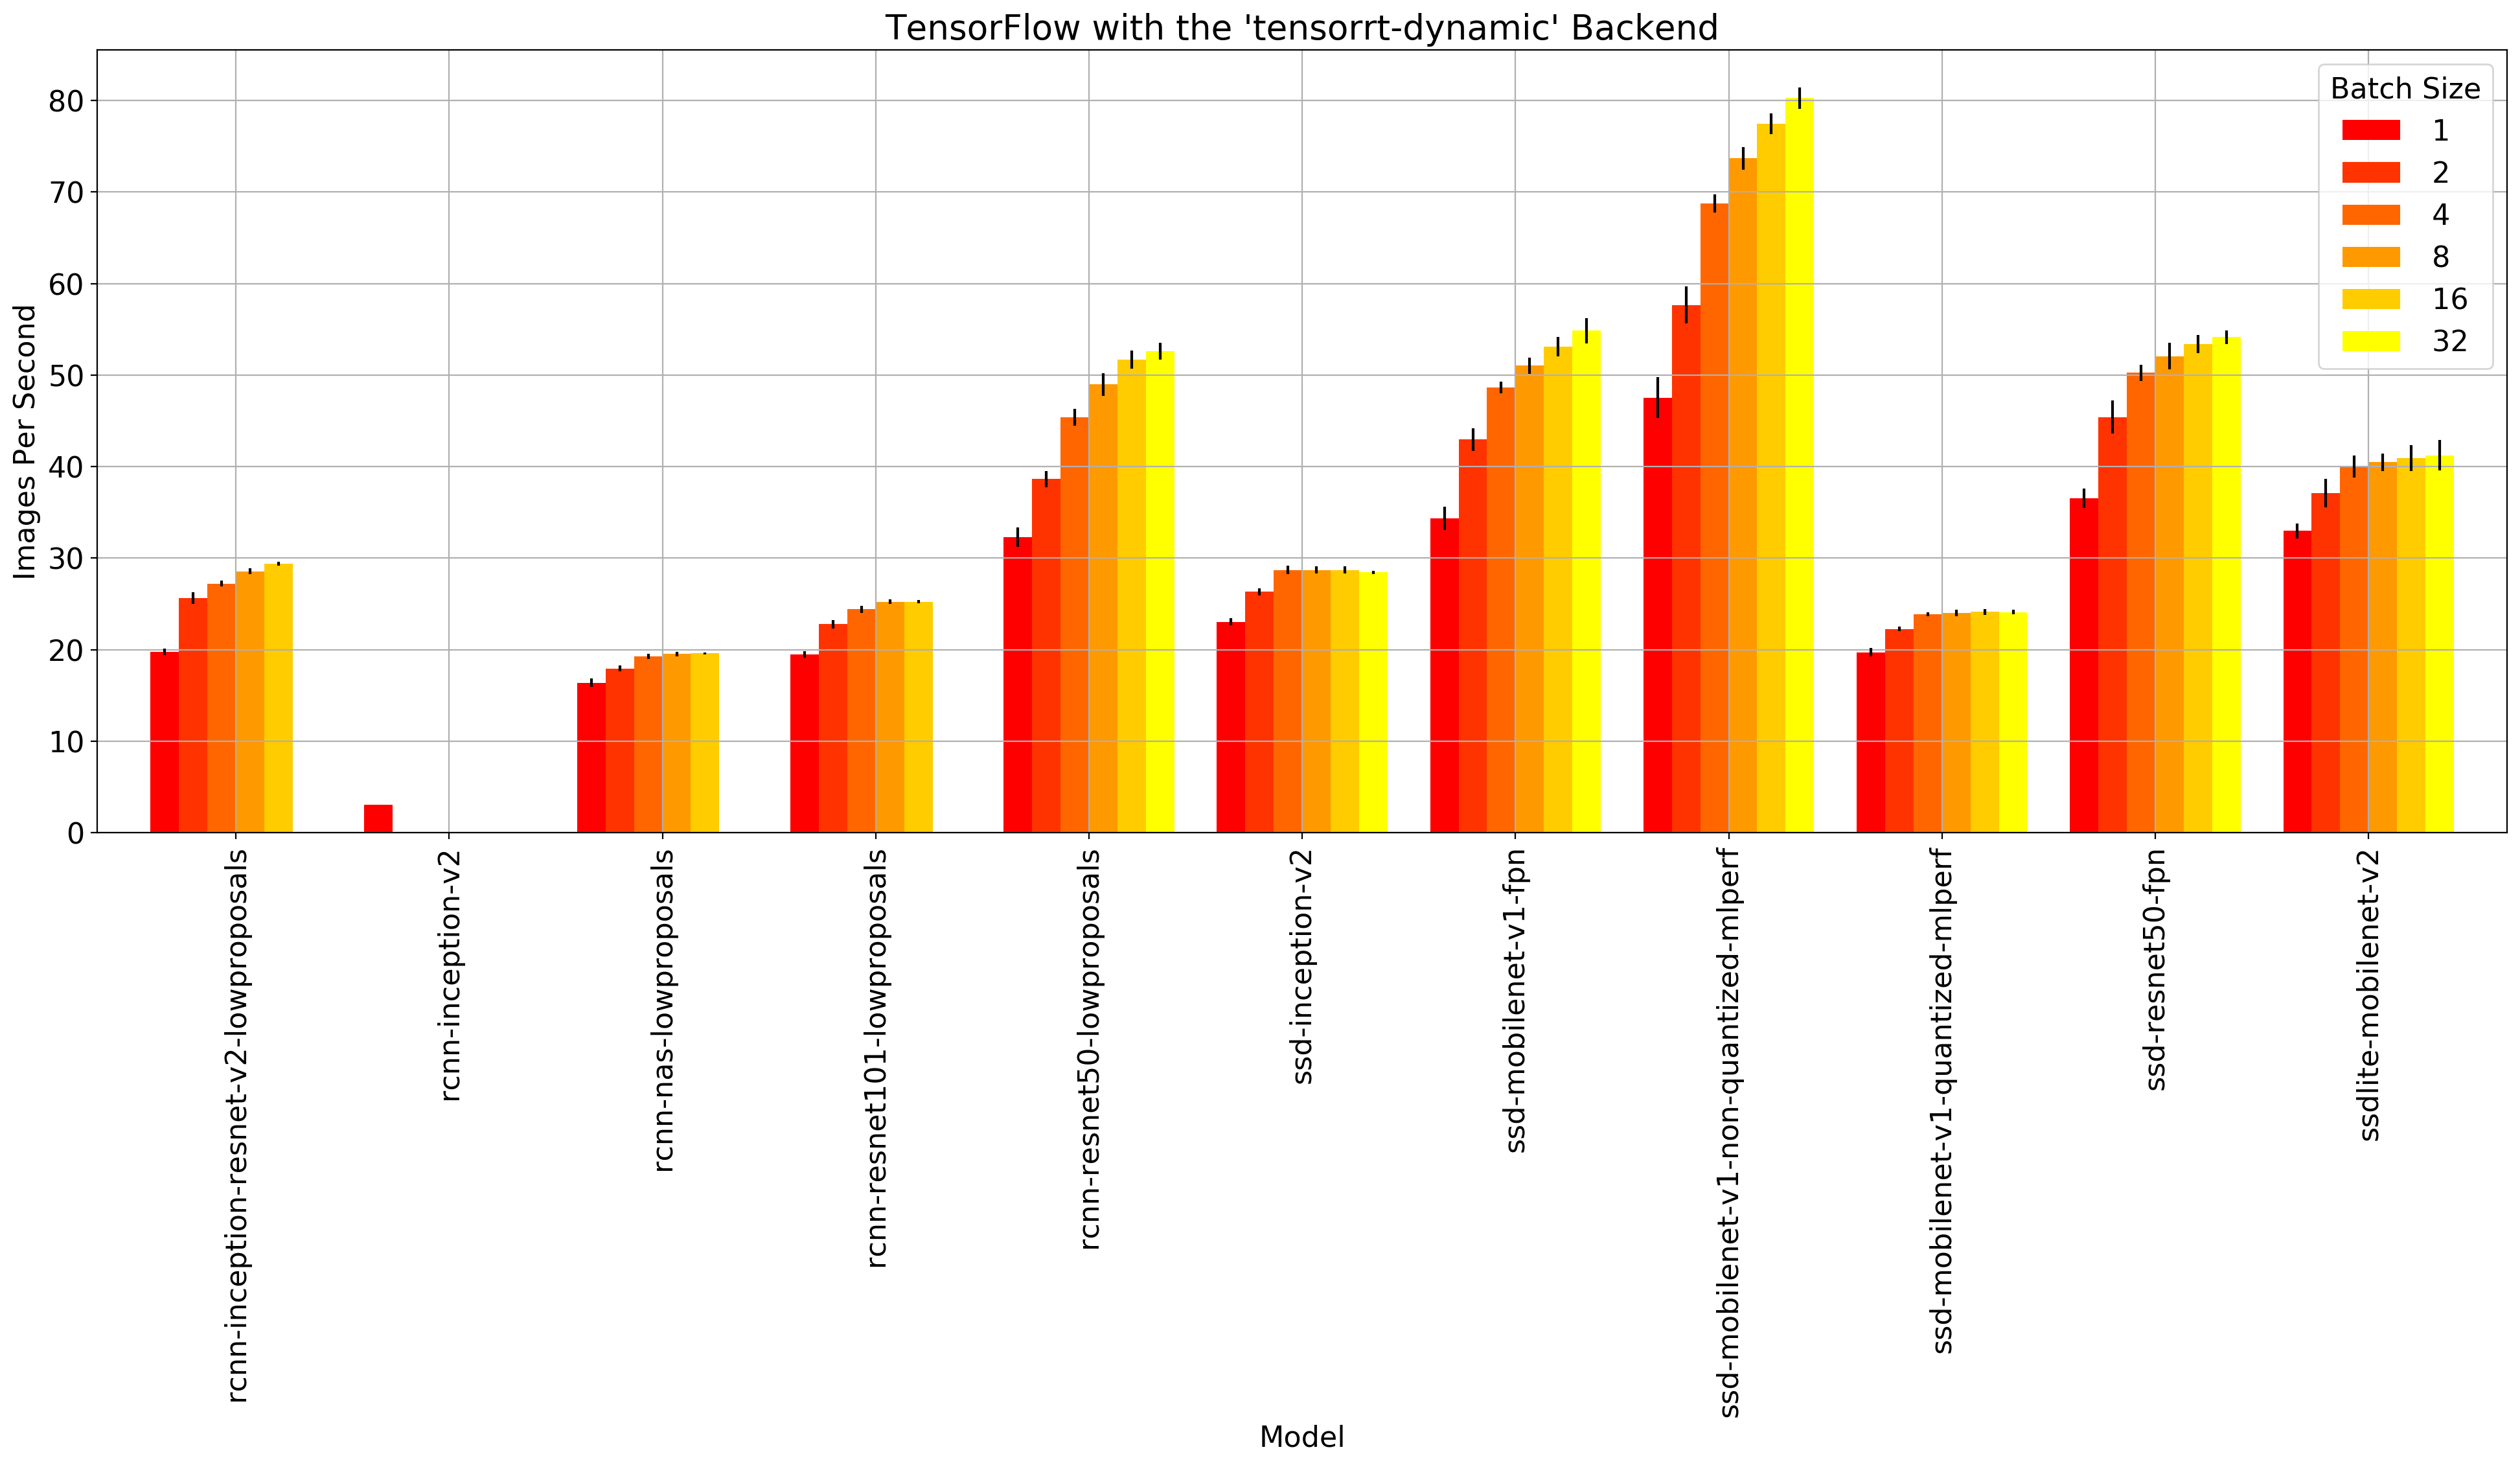

In [17]:
def plot_performance_per_backend(df_raw, groupby_level='backend', unstack_level=['batch_size'],
                               performance_metric=['avg_fps','avg_time_ms','graph_load_time_ms','images_load_time_avg_ms'],
                               save_fig=False, save_fig_name='performance.backend.',
                               title=None, figsize=[default_figwidth, 8], rot=90, colormap=cm.autumn):
    # Bars.
    df_bar = pd.DataFrame(
        data=df_raw[performance_metric].values, columns=performance_metric,
        index=pd.MultiIndex.from_tuples(
            tuples=[ (m,b,bs,be,nr) for (m,b,bs,bc,be,ih,iw,nr) in df_raw.index.values ],
            names=[ 'model','backend','batch_size','batch_enabled','num_reps' ]
        )
    )

    # Plot.
    mean = df_bar.groupby(level=df_bar.index.names[:-1]).mean().unstack(unstack_level)
    std  = df_bar.groupby(level=df_bar.index.names[:-1]).std().unstack(unstack_level)
    axes = mean \
            .groupby(level=groupby_level) \
            .plot(yerr=std, kind='bar', grid=True, rot=rot, legend=False,
                  figsize=figsize, width=default_barwidth, fontsize=default_fontsize, colormap=colormap)

    xlabel = 'Model'
    xtics = df_bar.index.get_level_values('model').drop_duplicates()
    ylabel = 'Images Per Second'
    for num, ax in enumerate(axes):
        # Title.
        ax.set_title('TensorFlow with the \'{}\' Backend'.format(axes.keys().to_numpy().item(num)))
        # X label.
        ax.set_xlabel(xlabel)
        # X ticks.
        ax.set_xticklabels(xtics)
        # Y axis.
        ax.set_ylabel(ylabel)
        # Legend.
        patches, labels = ax.get_legend_handles_labels()
        labels = [label[1] for label in [x.split(',') for x in labels]]
        labels = [x.strip(')') for x in labels]
        ax.legend(patches, labels, loc='best', title='Batch Size')
        # Save figure.
        if save_fig:
            save_fig_path = os.path.join(save_fig_dir, '%s.%s' % (save_fig_name+axes.keys().to_numpy().item(num), save_fig_ext))
            ax.figure.savefig(save_fig_path, dpi=default_figdpi, bbox_inches='tight')

plot_performance_per_backend(dfs_perf, performance_metric=['avg_fps'], save_fig=True)

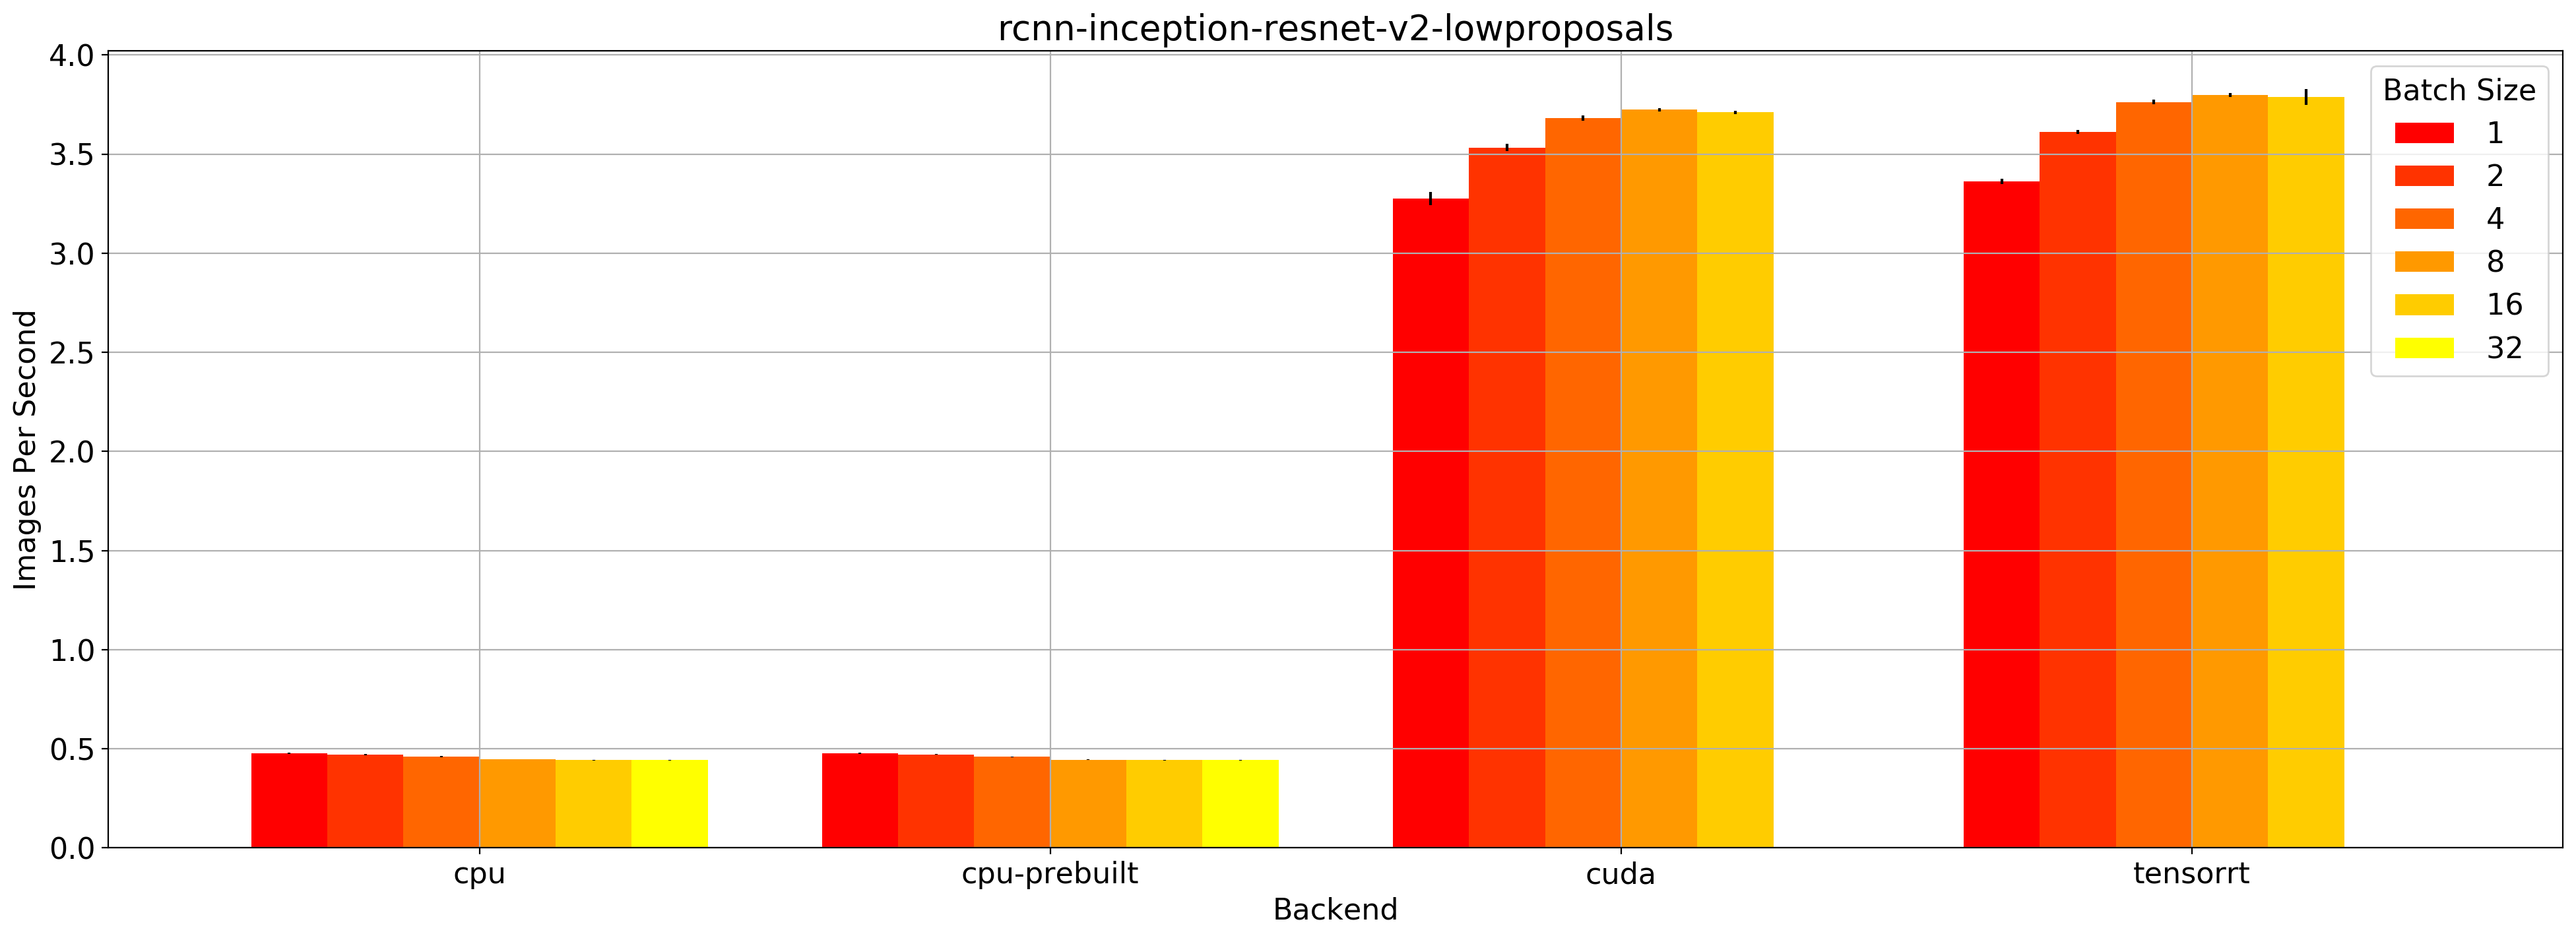

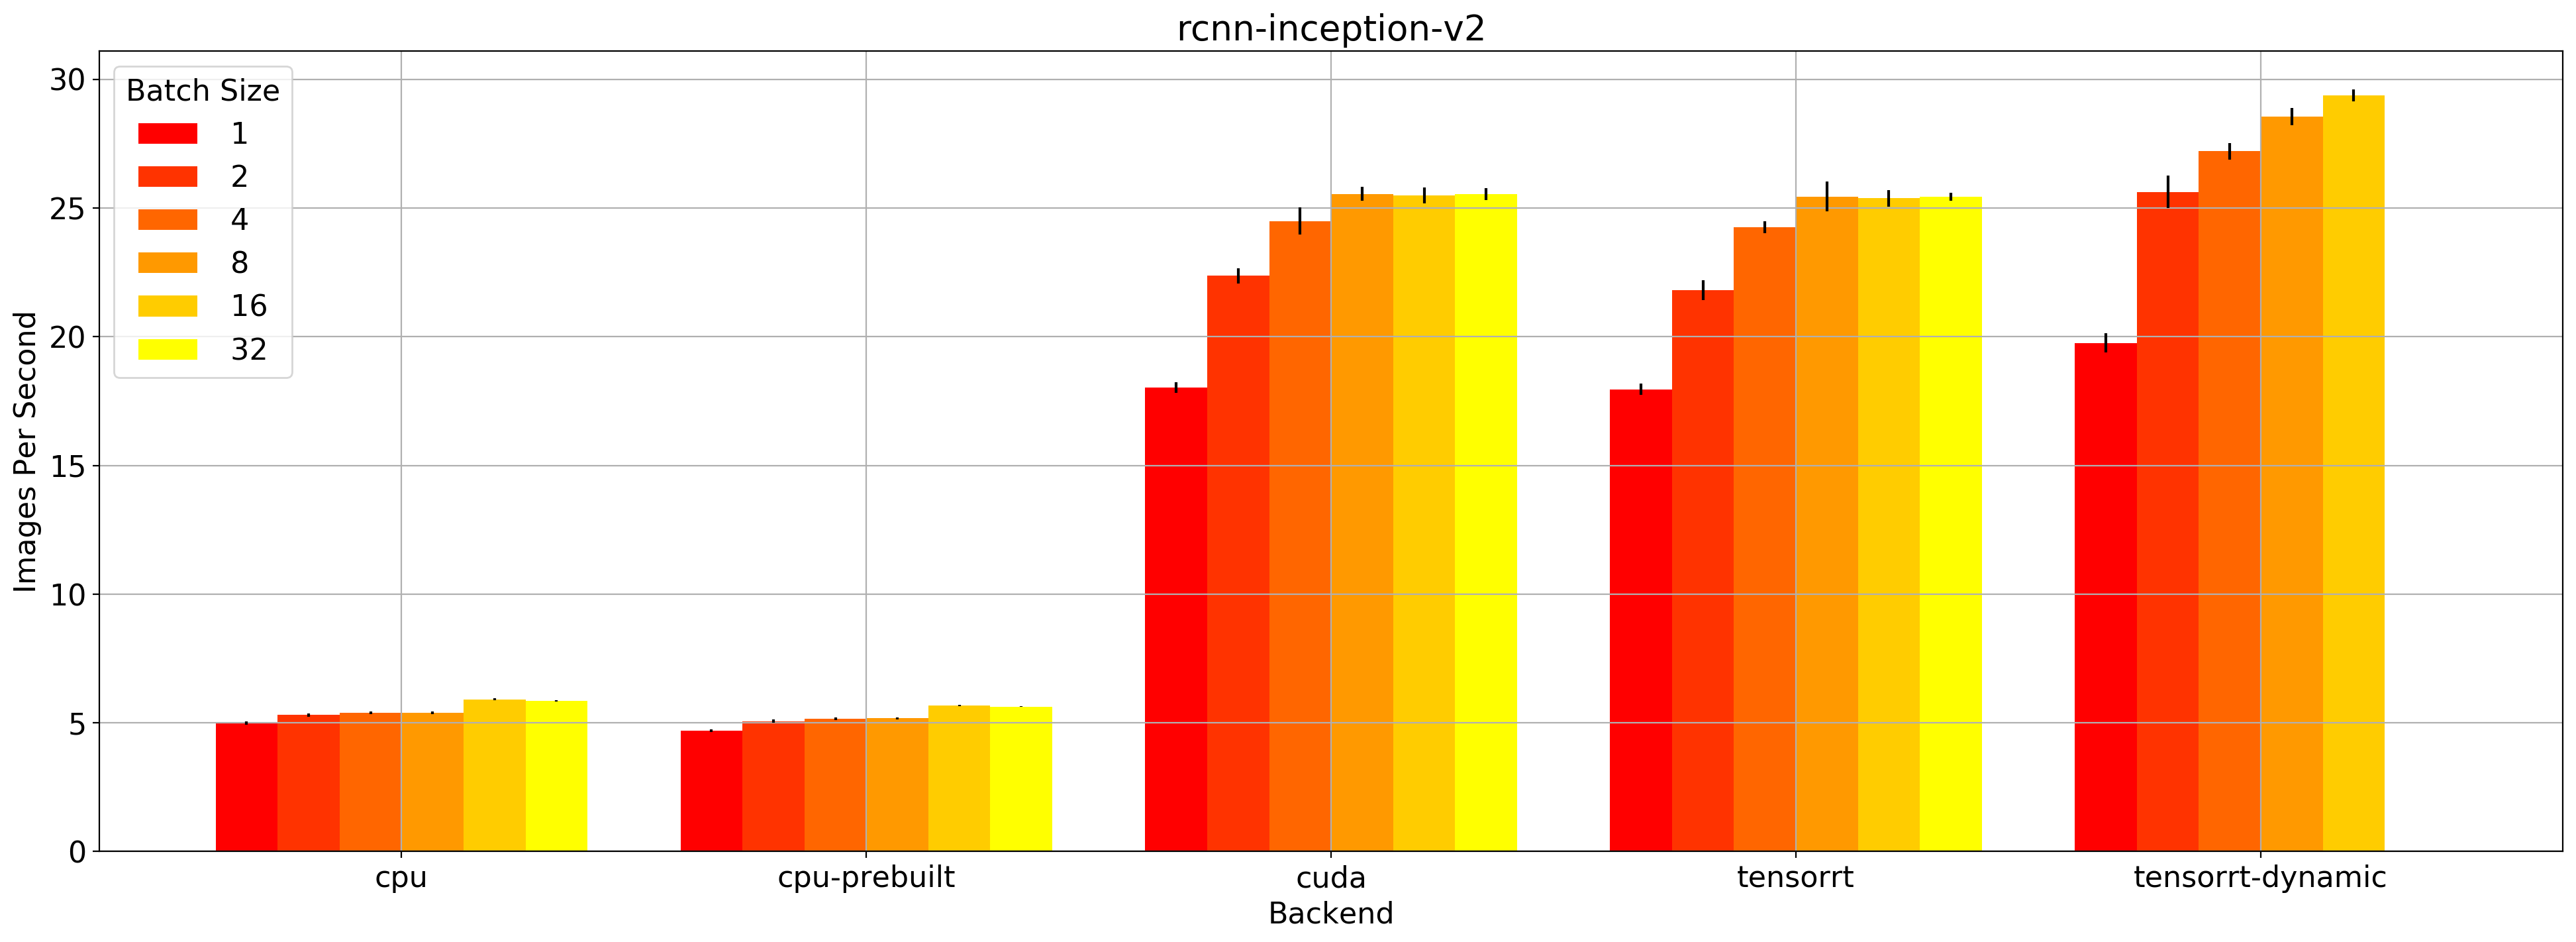

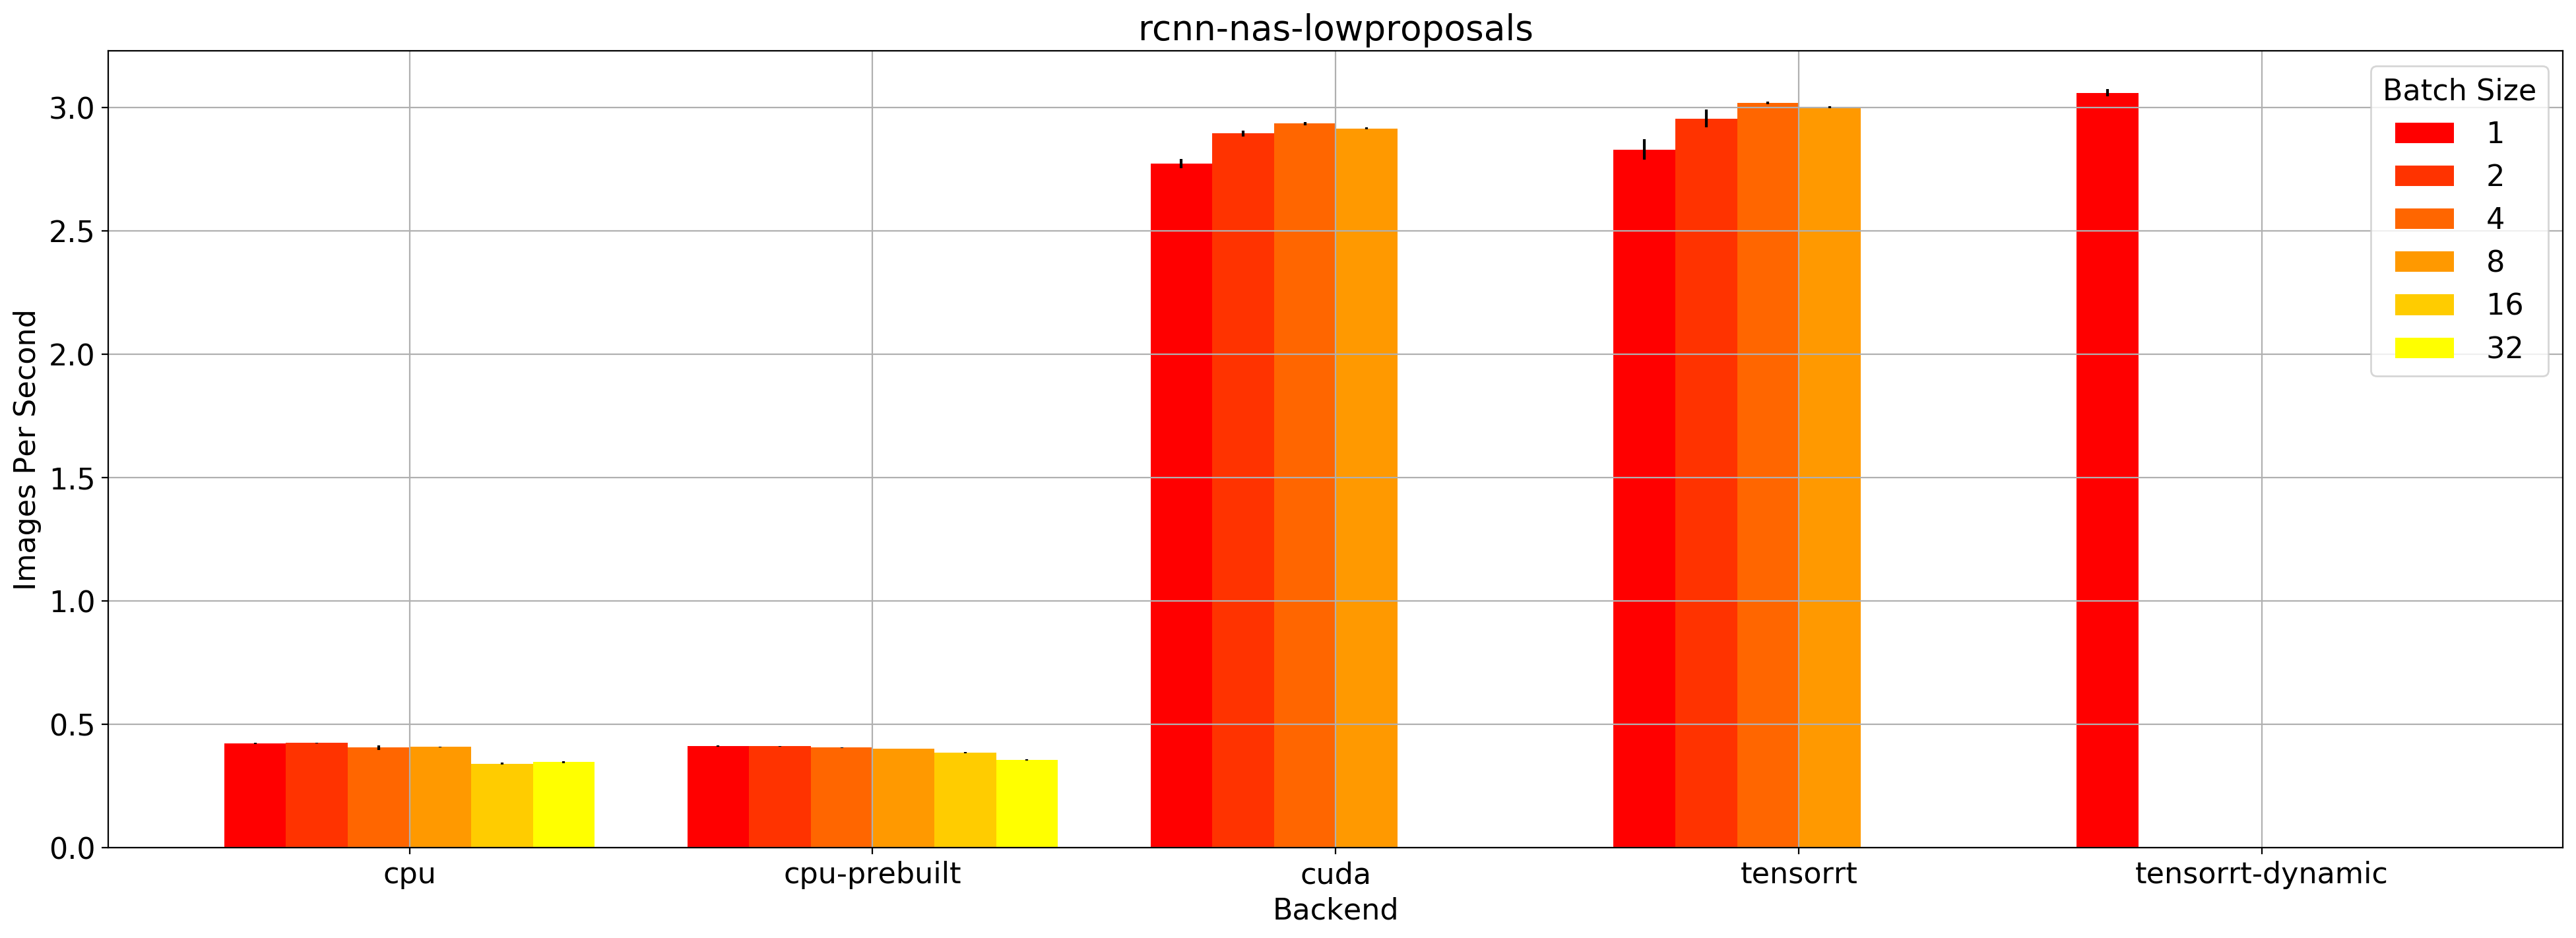

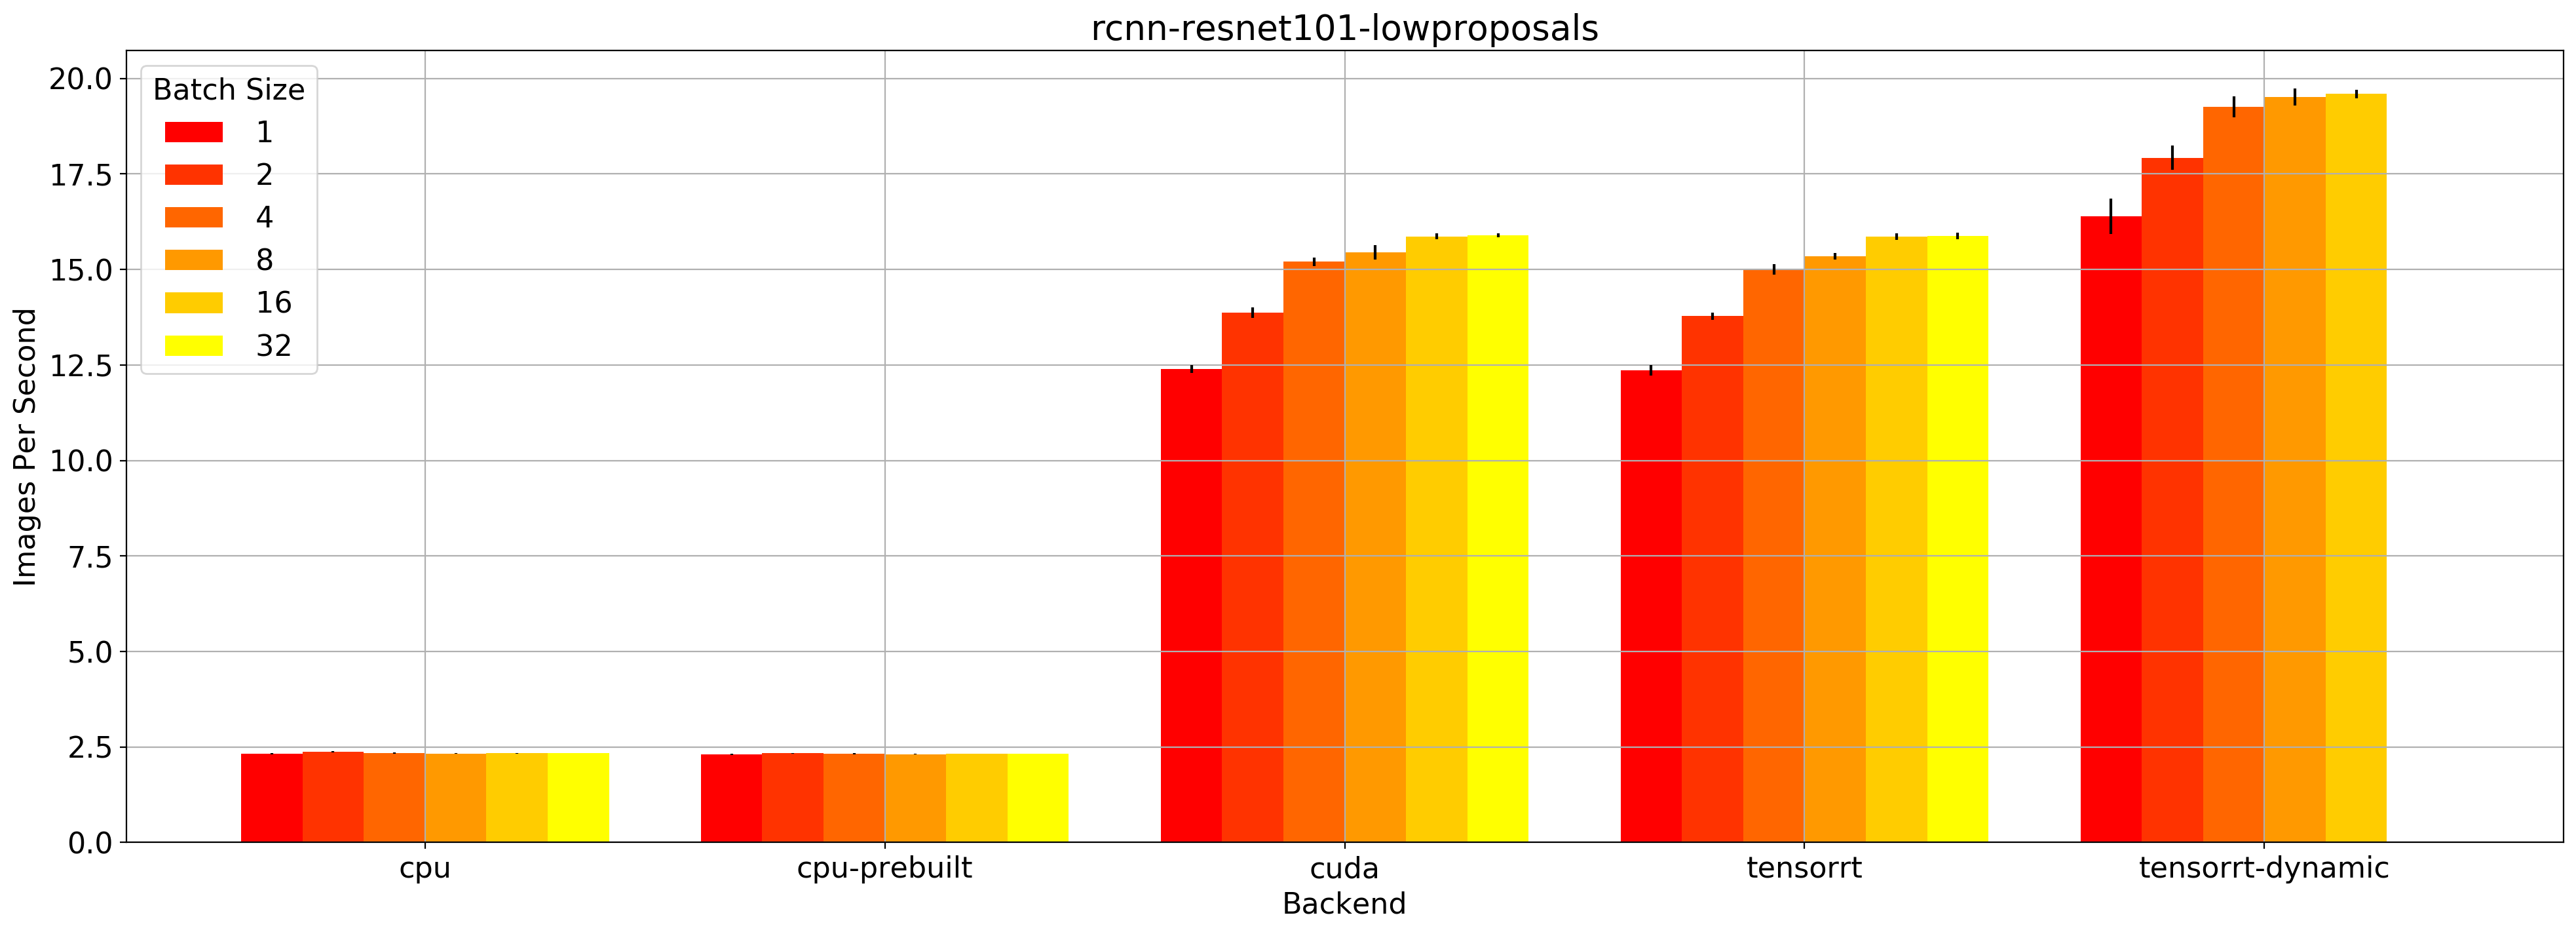

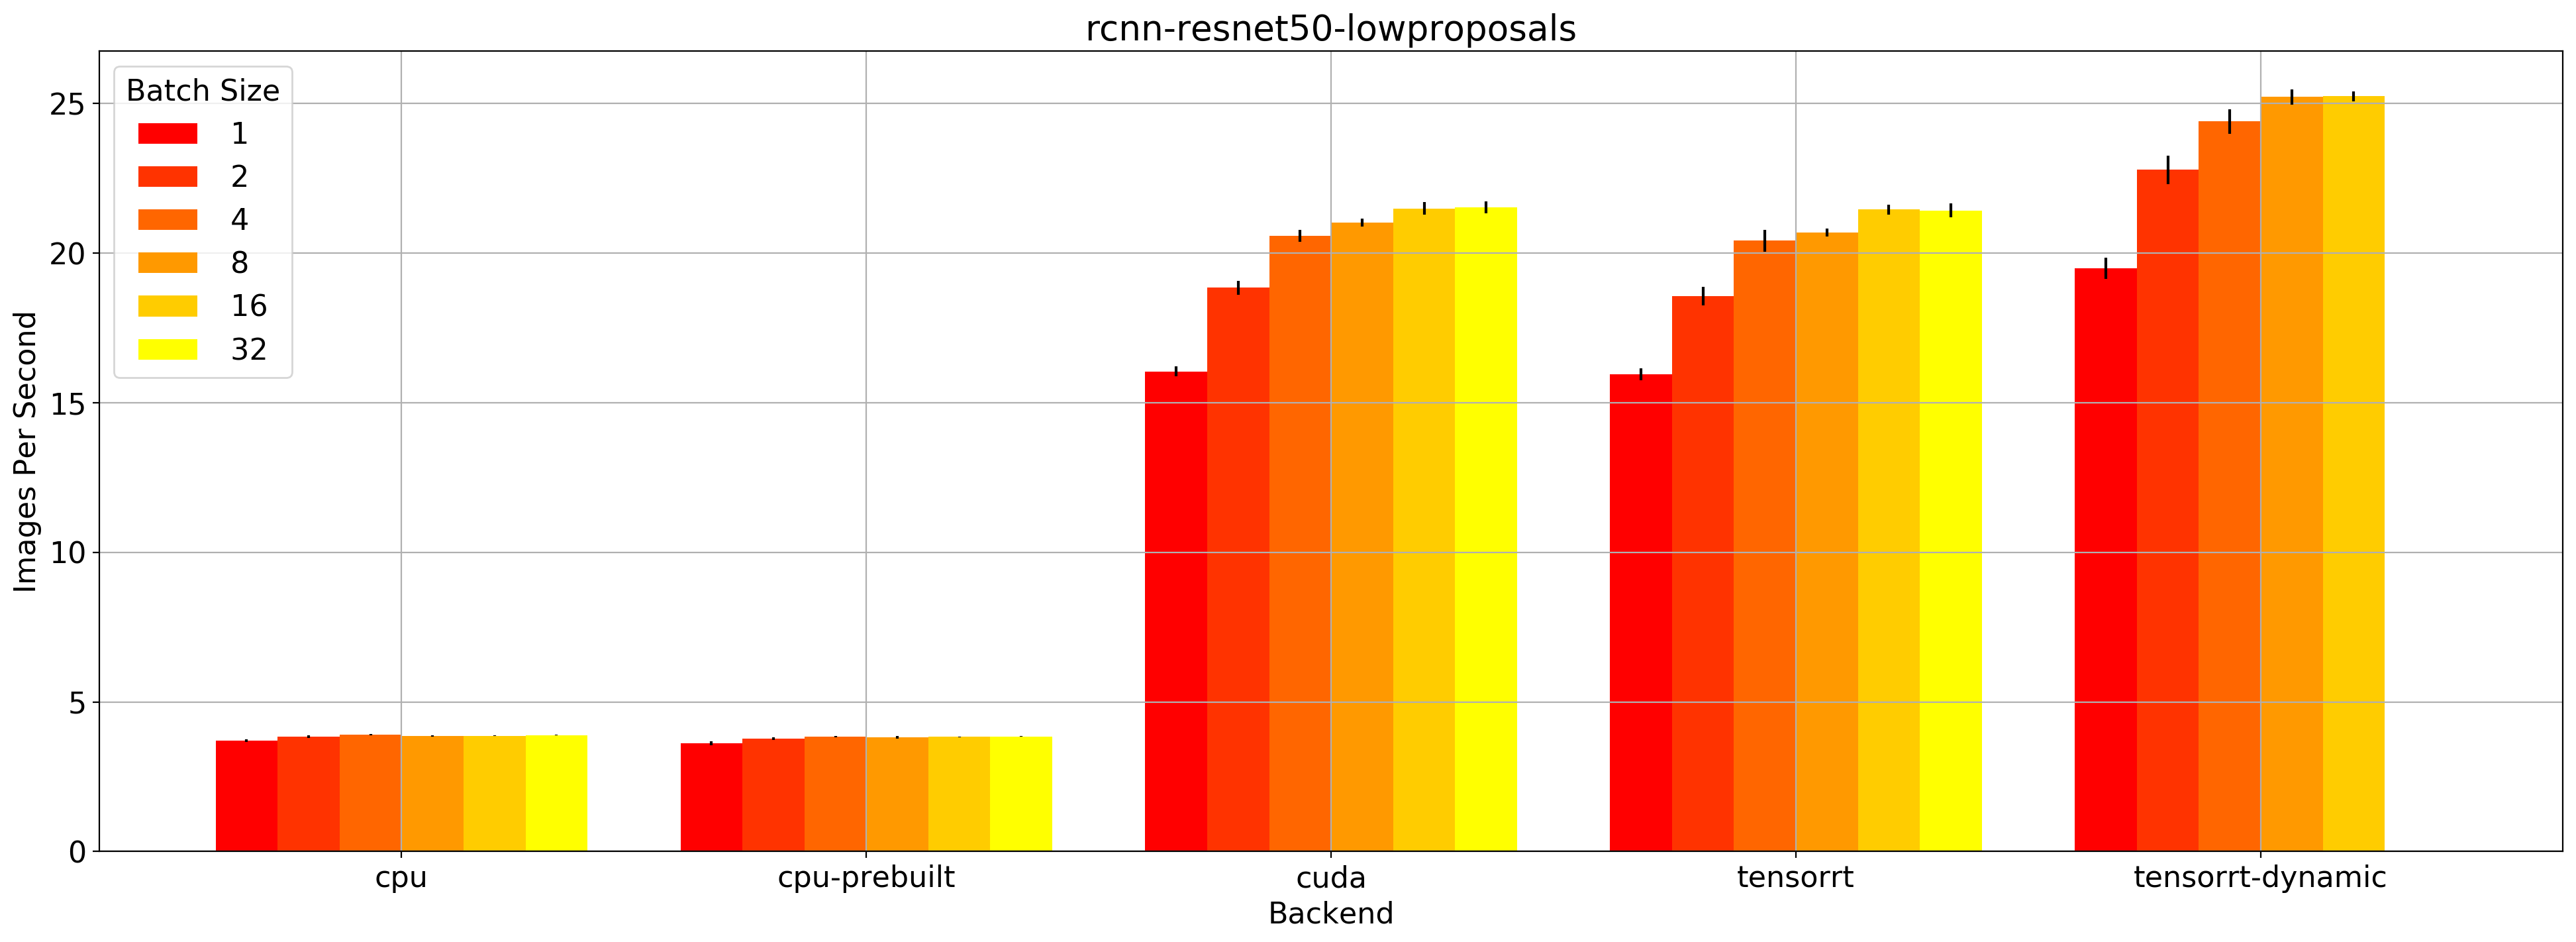

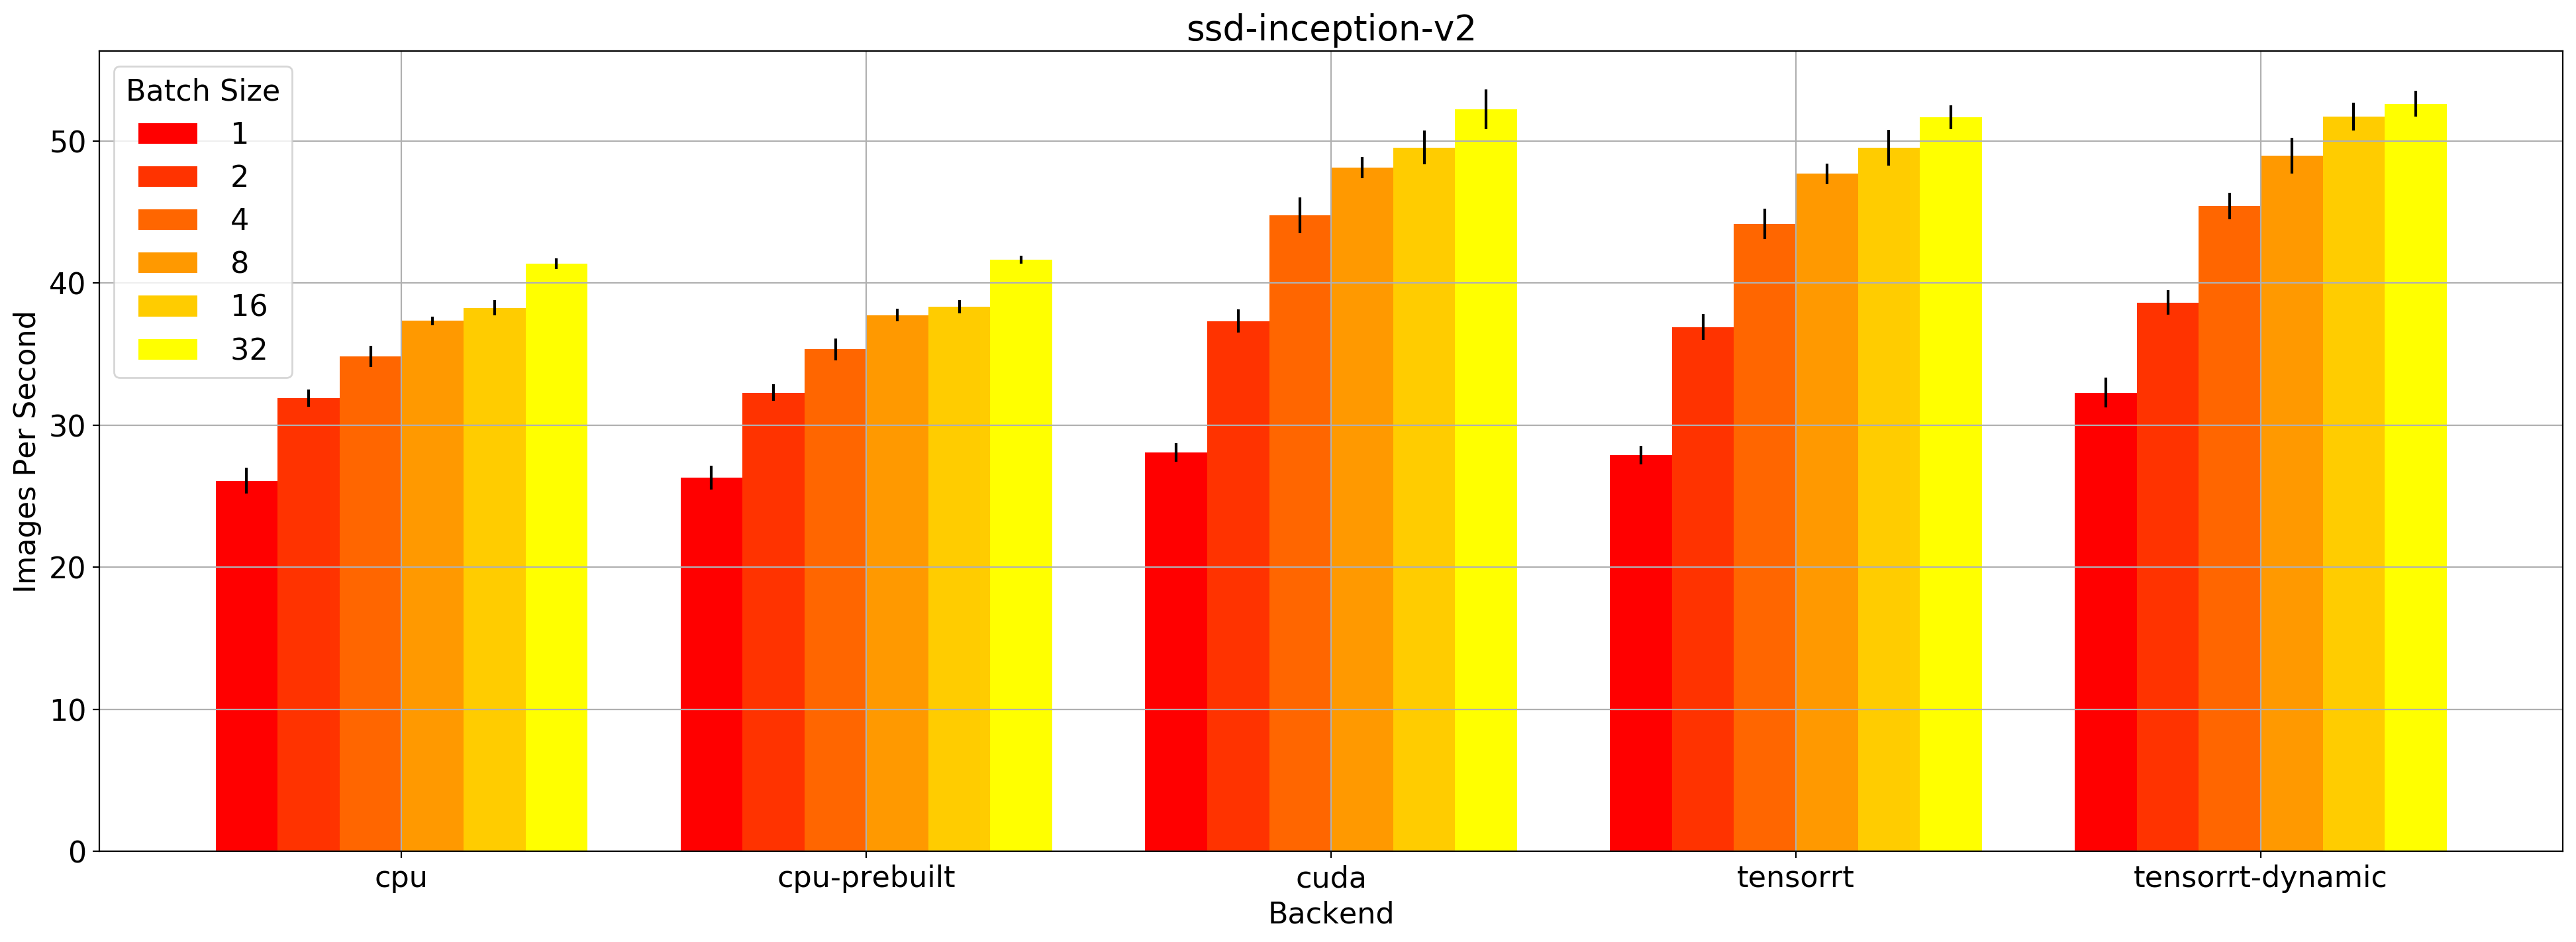

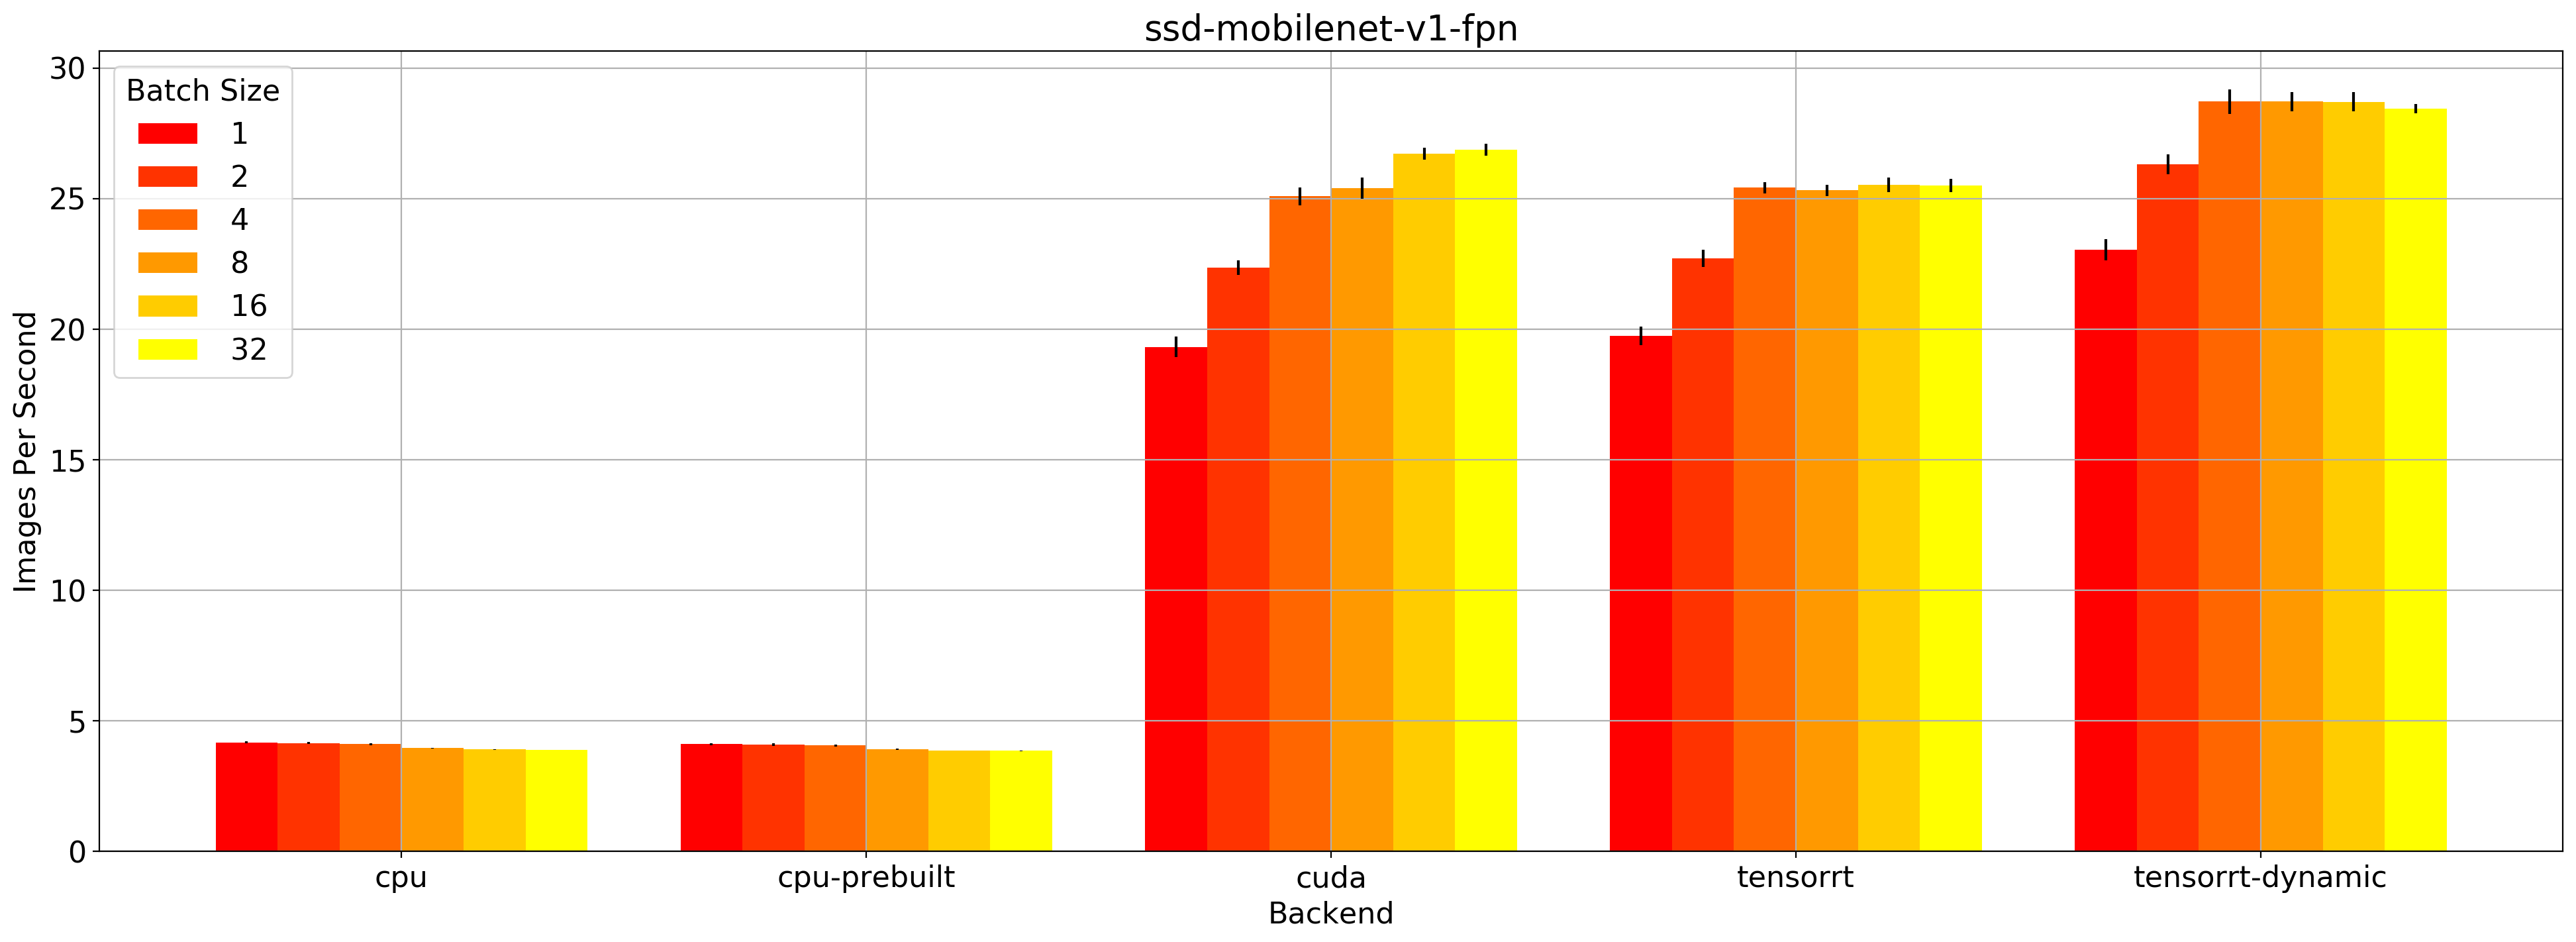

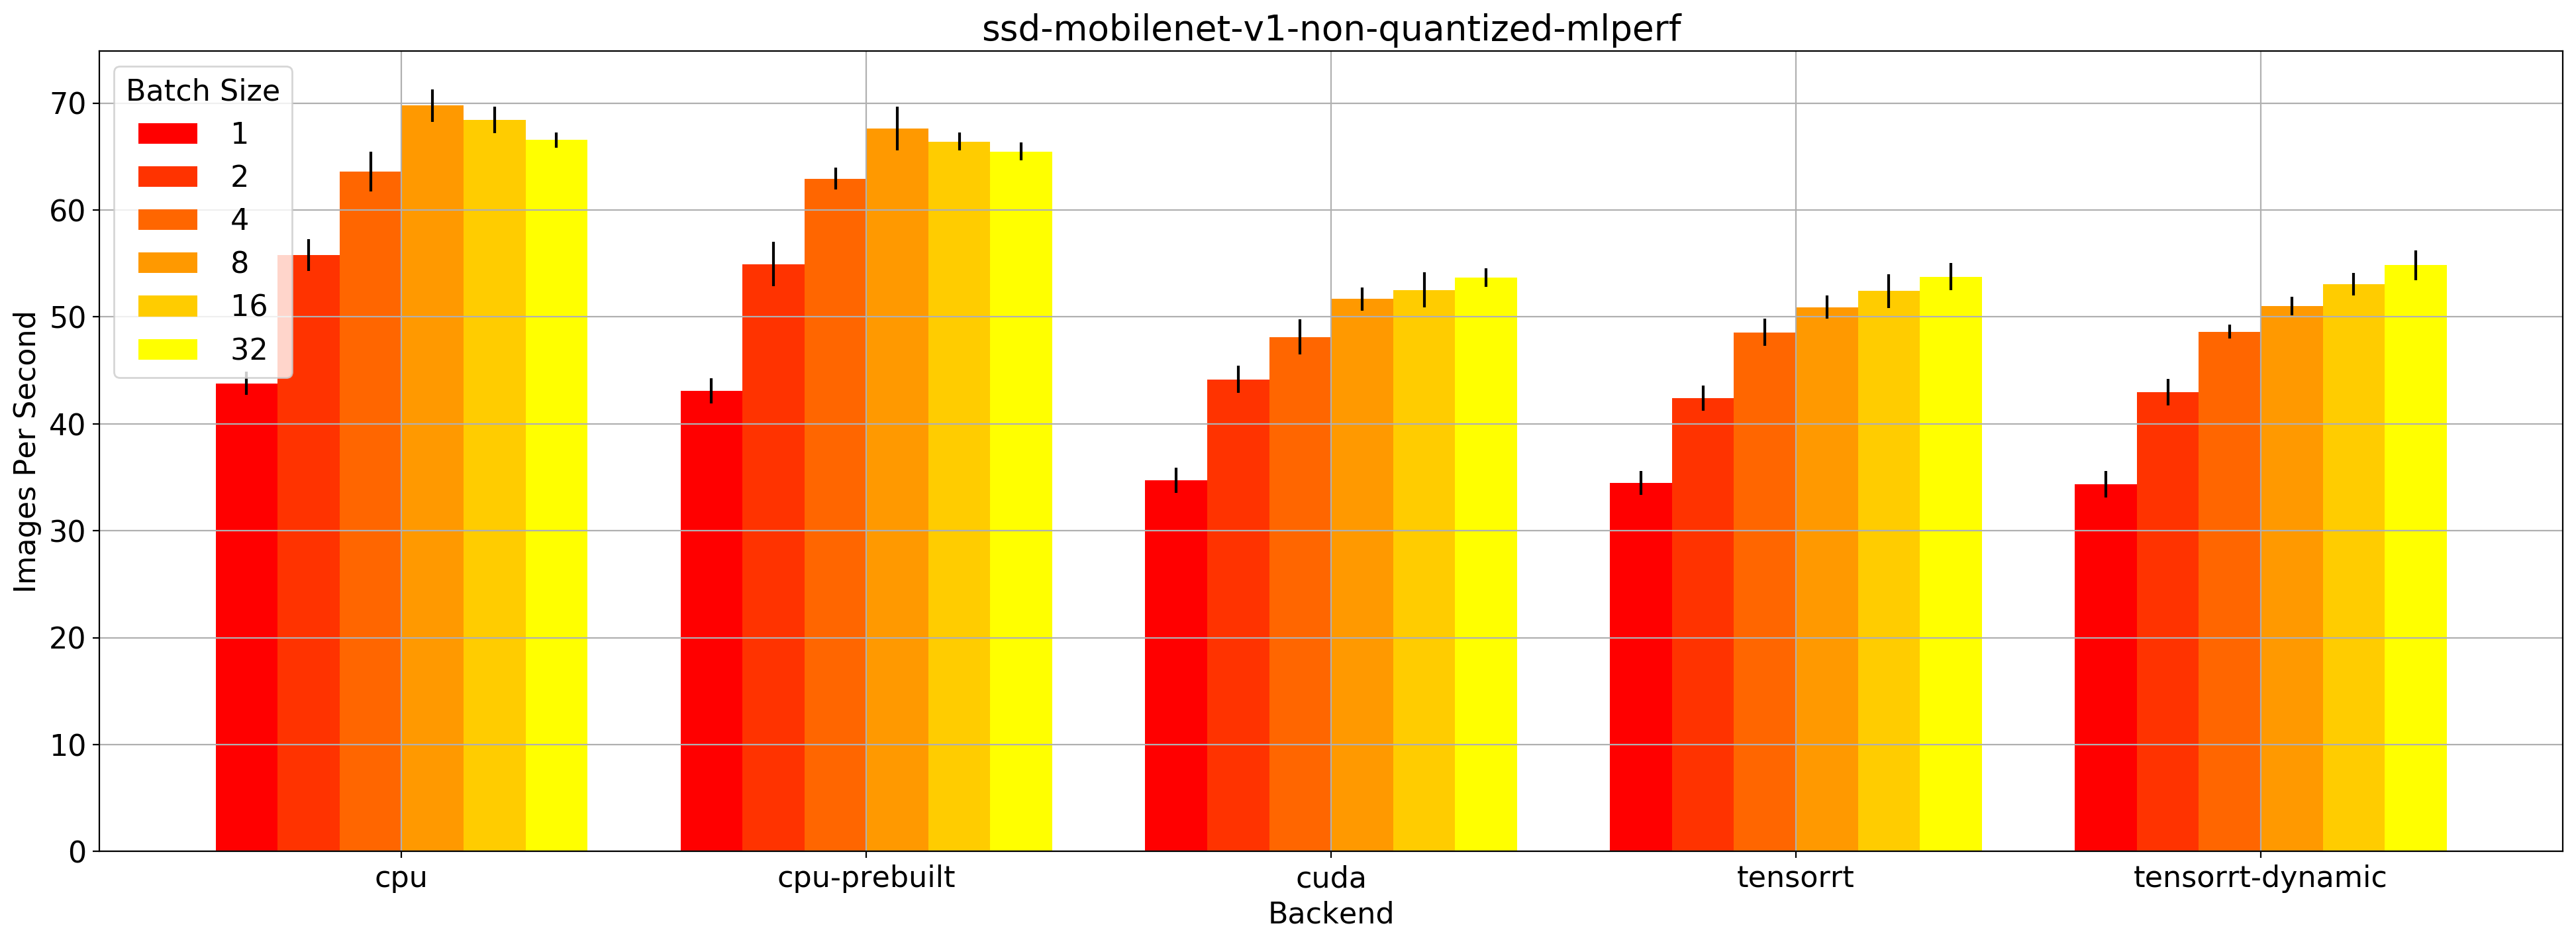

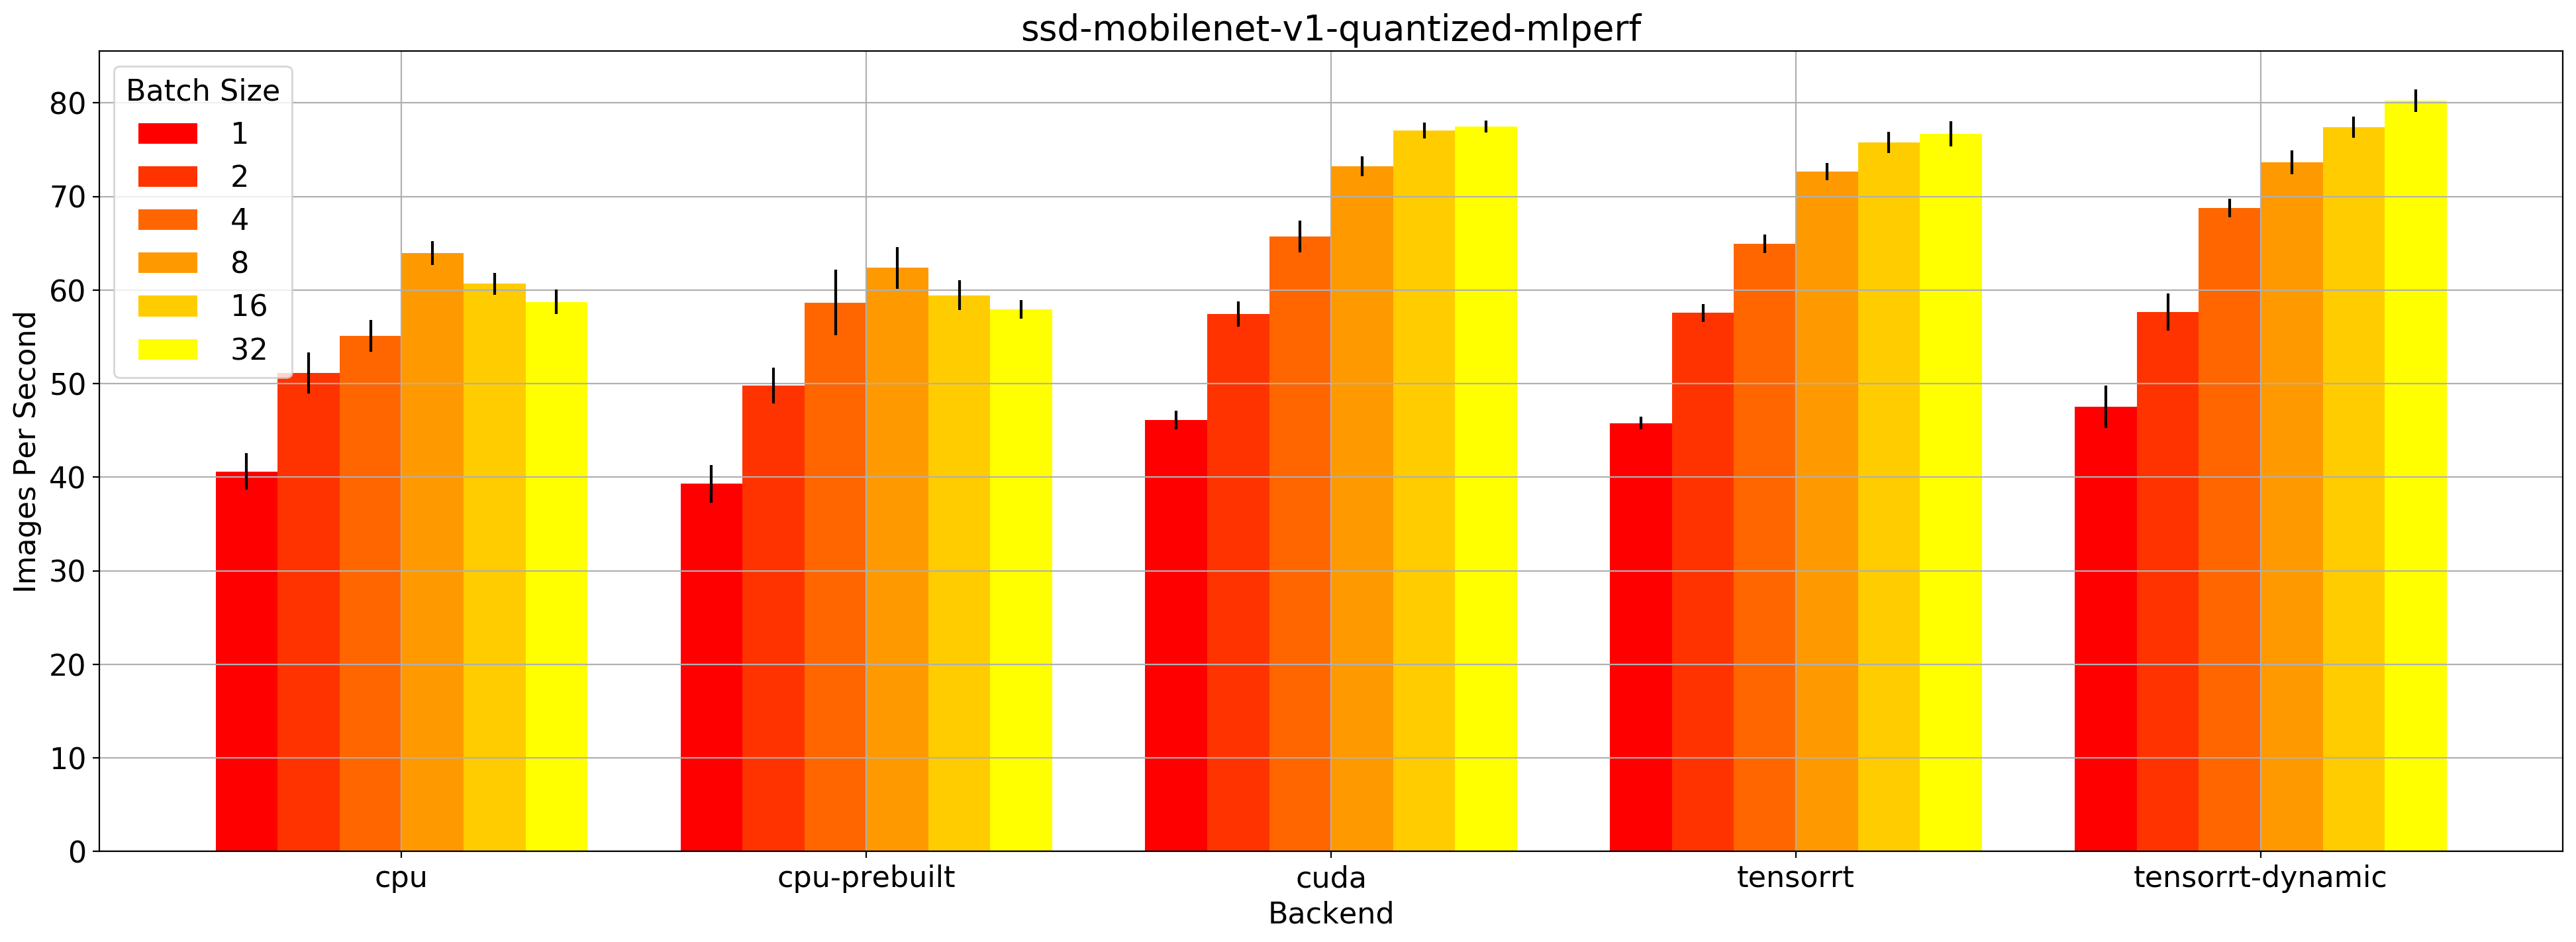

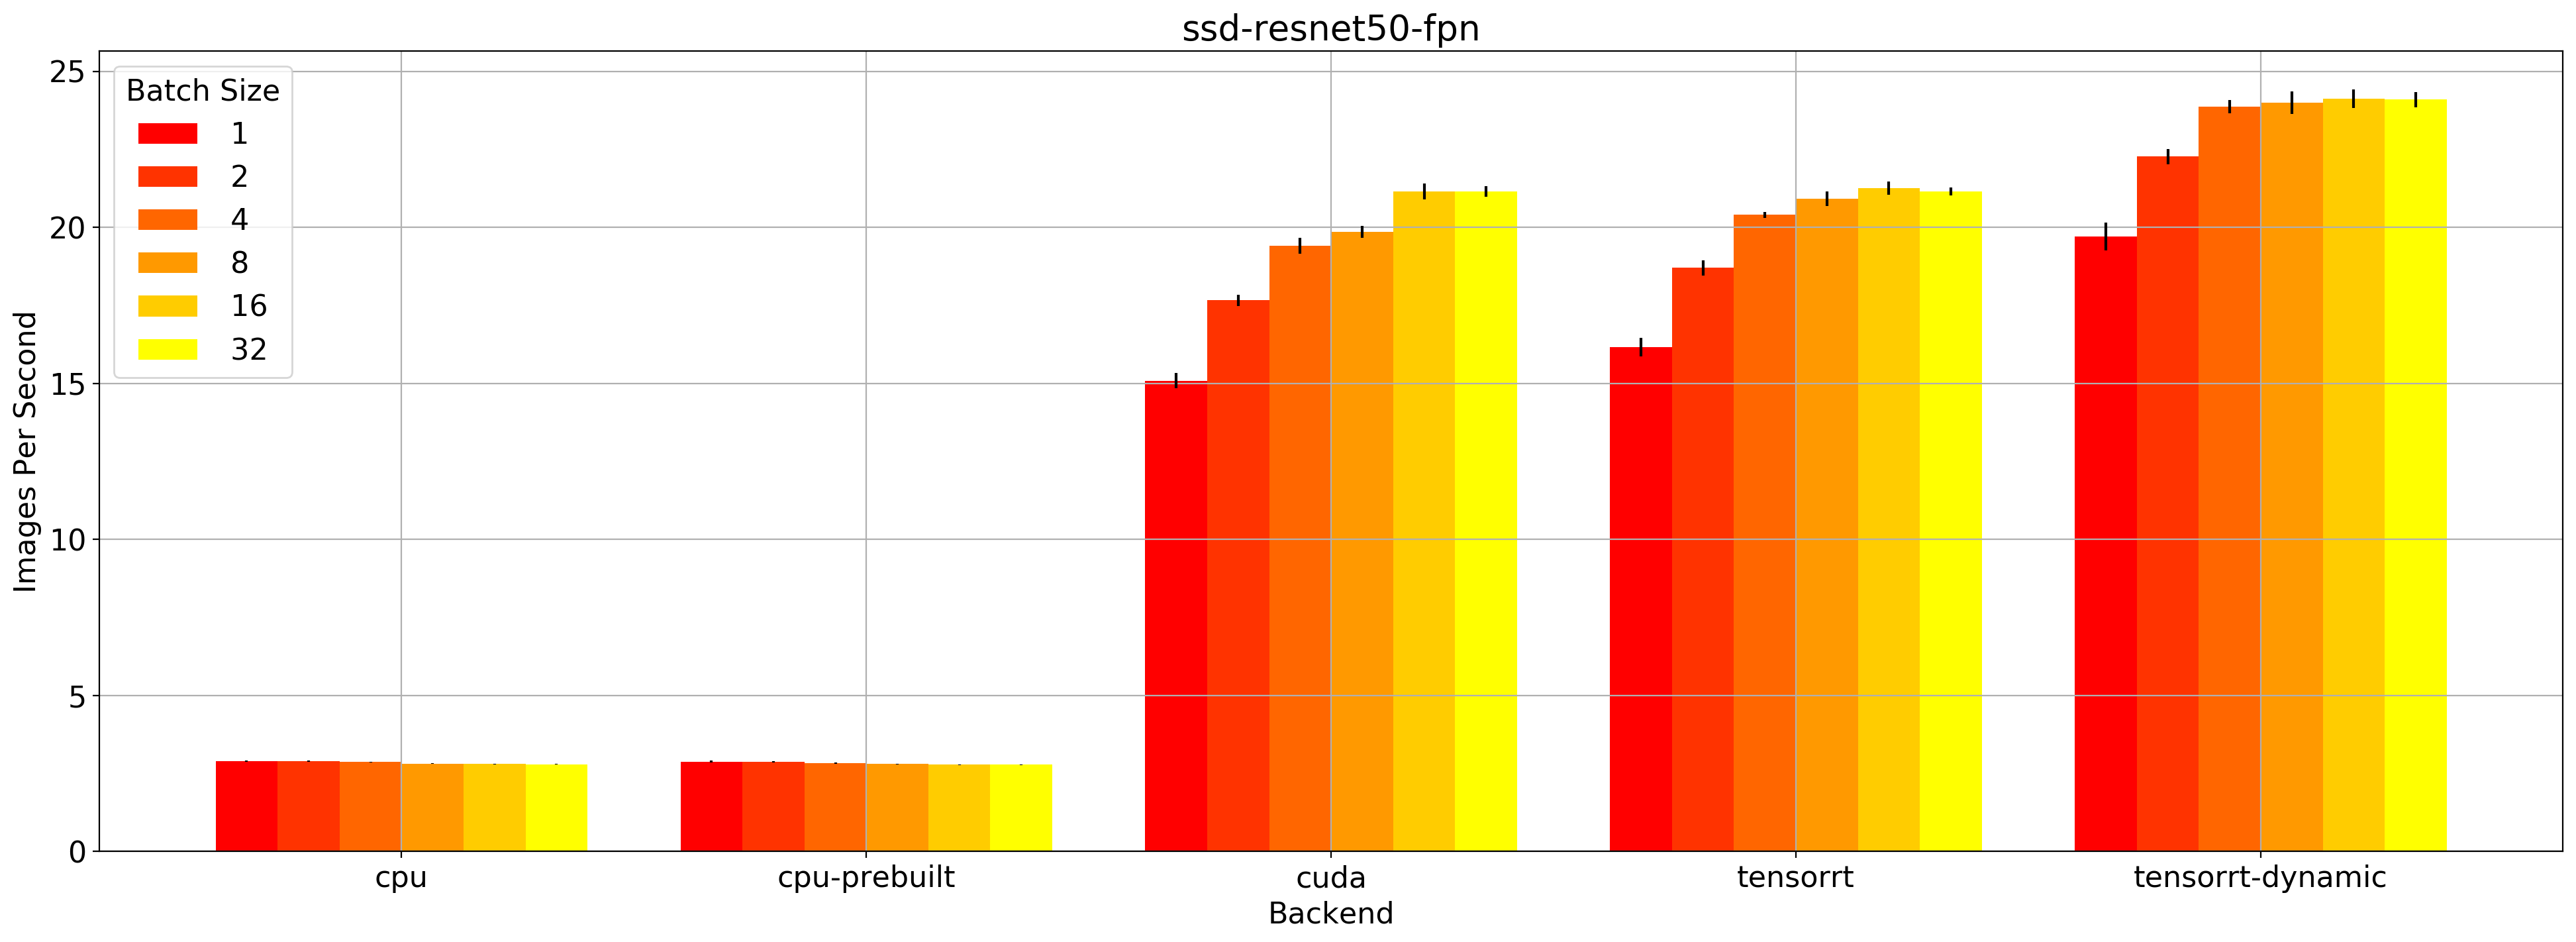

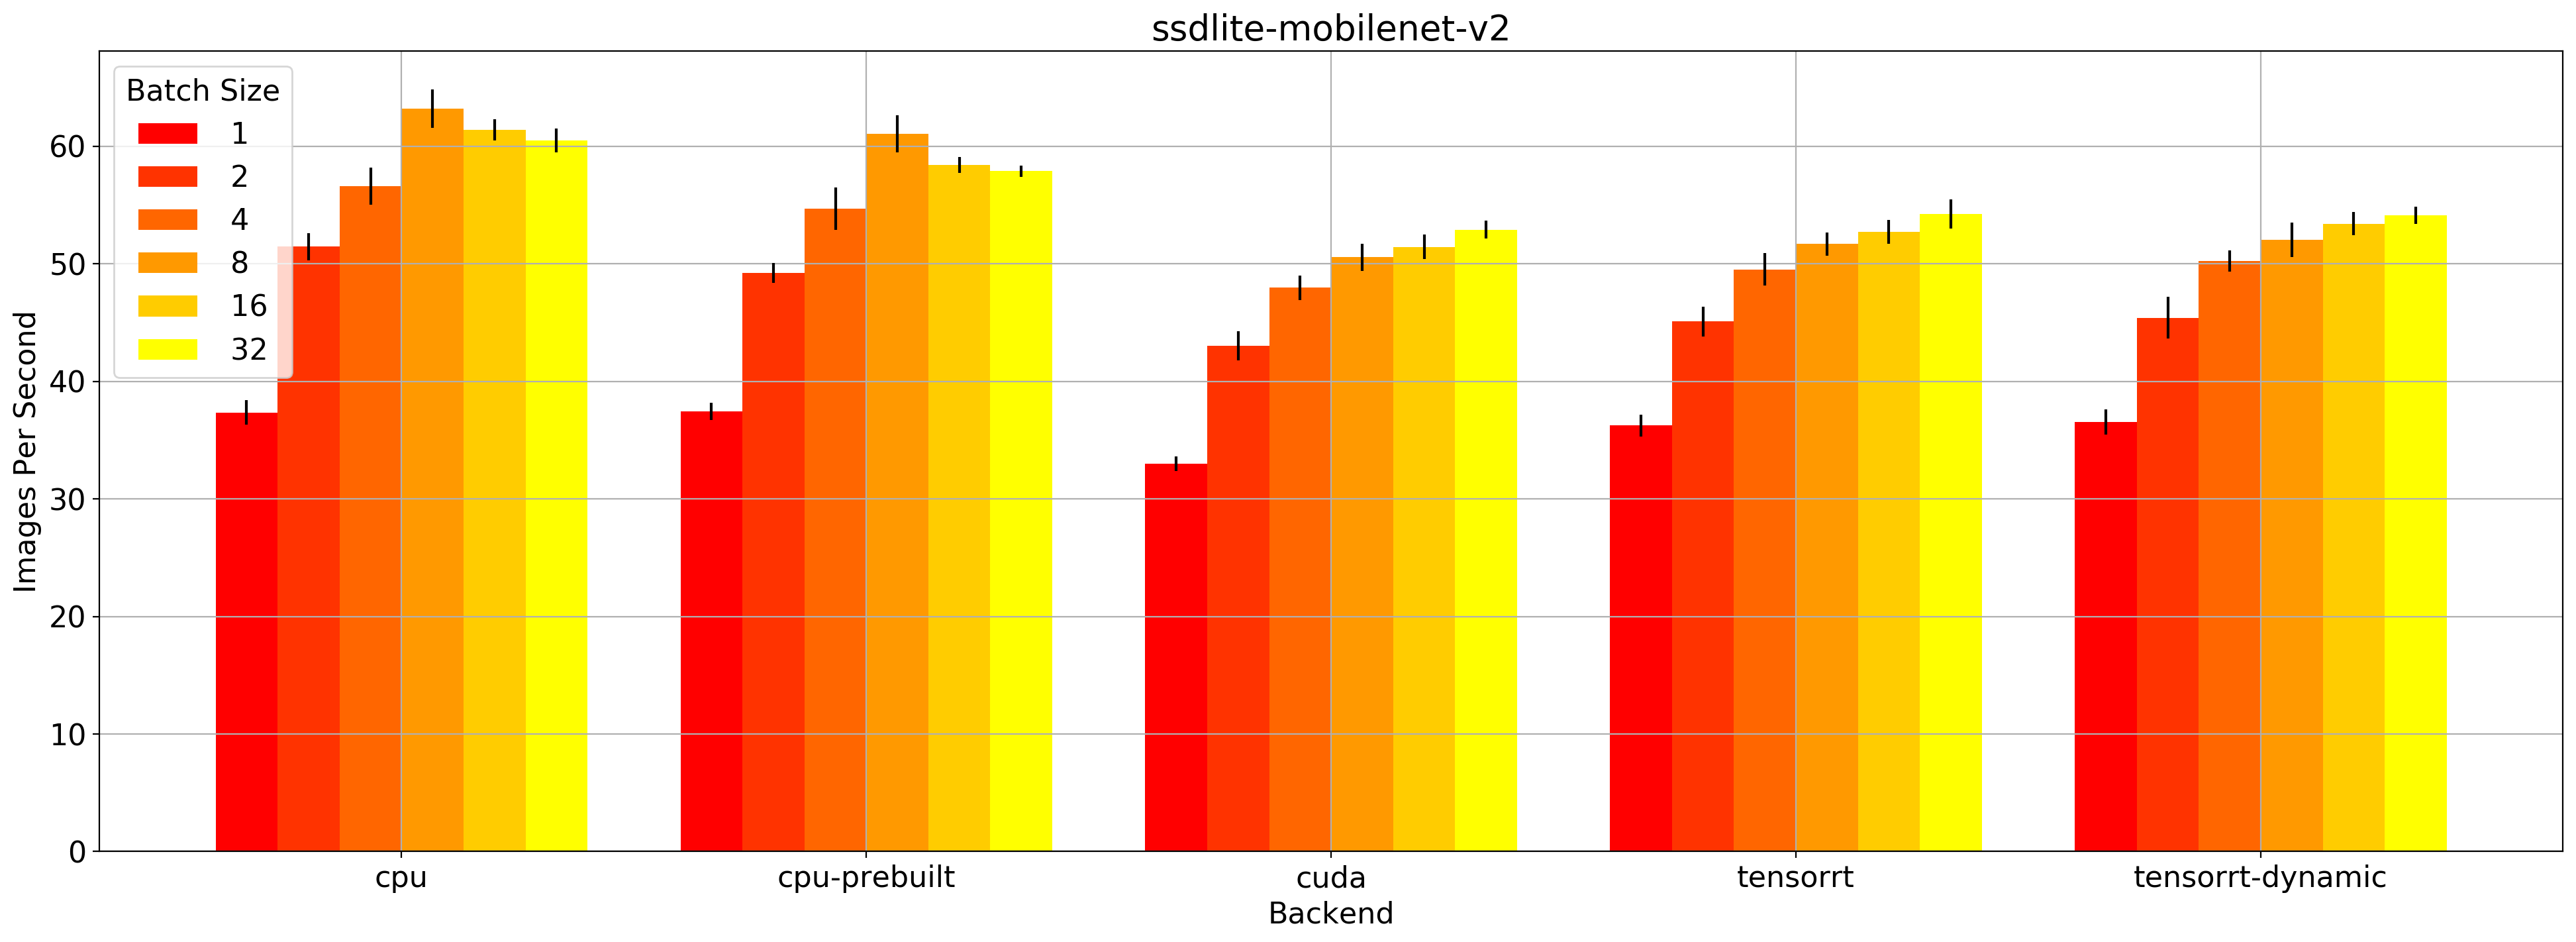

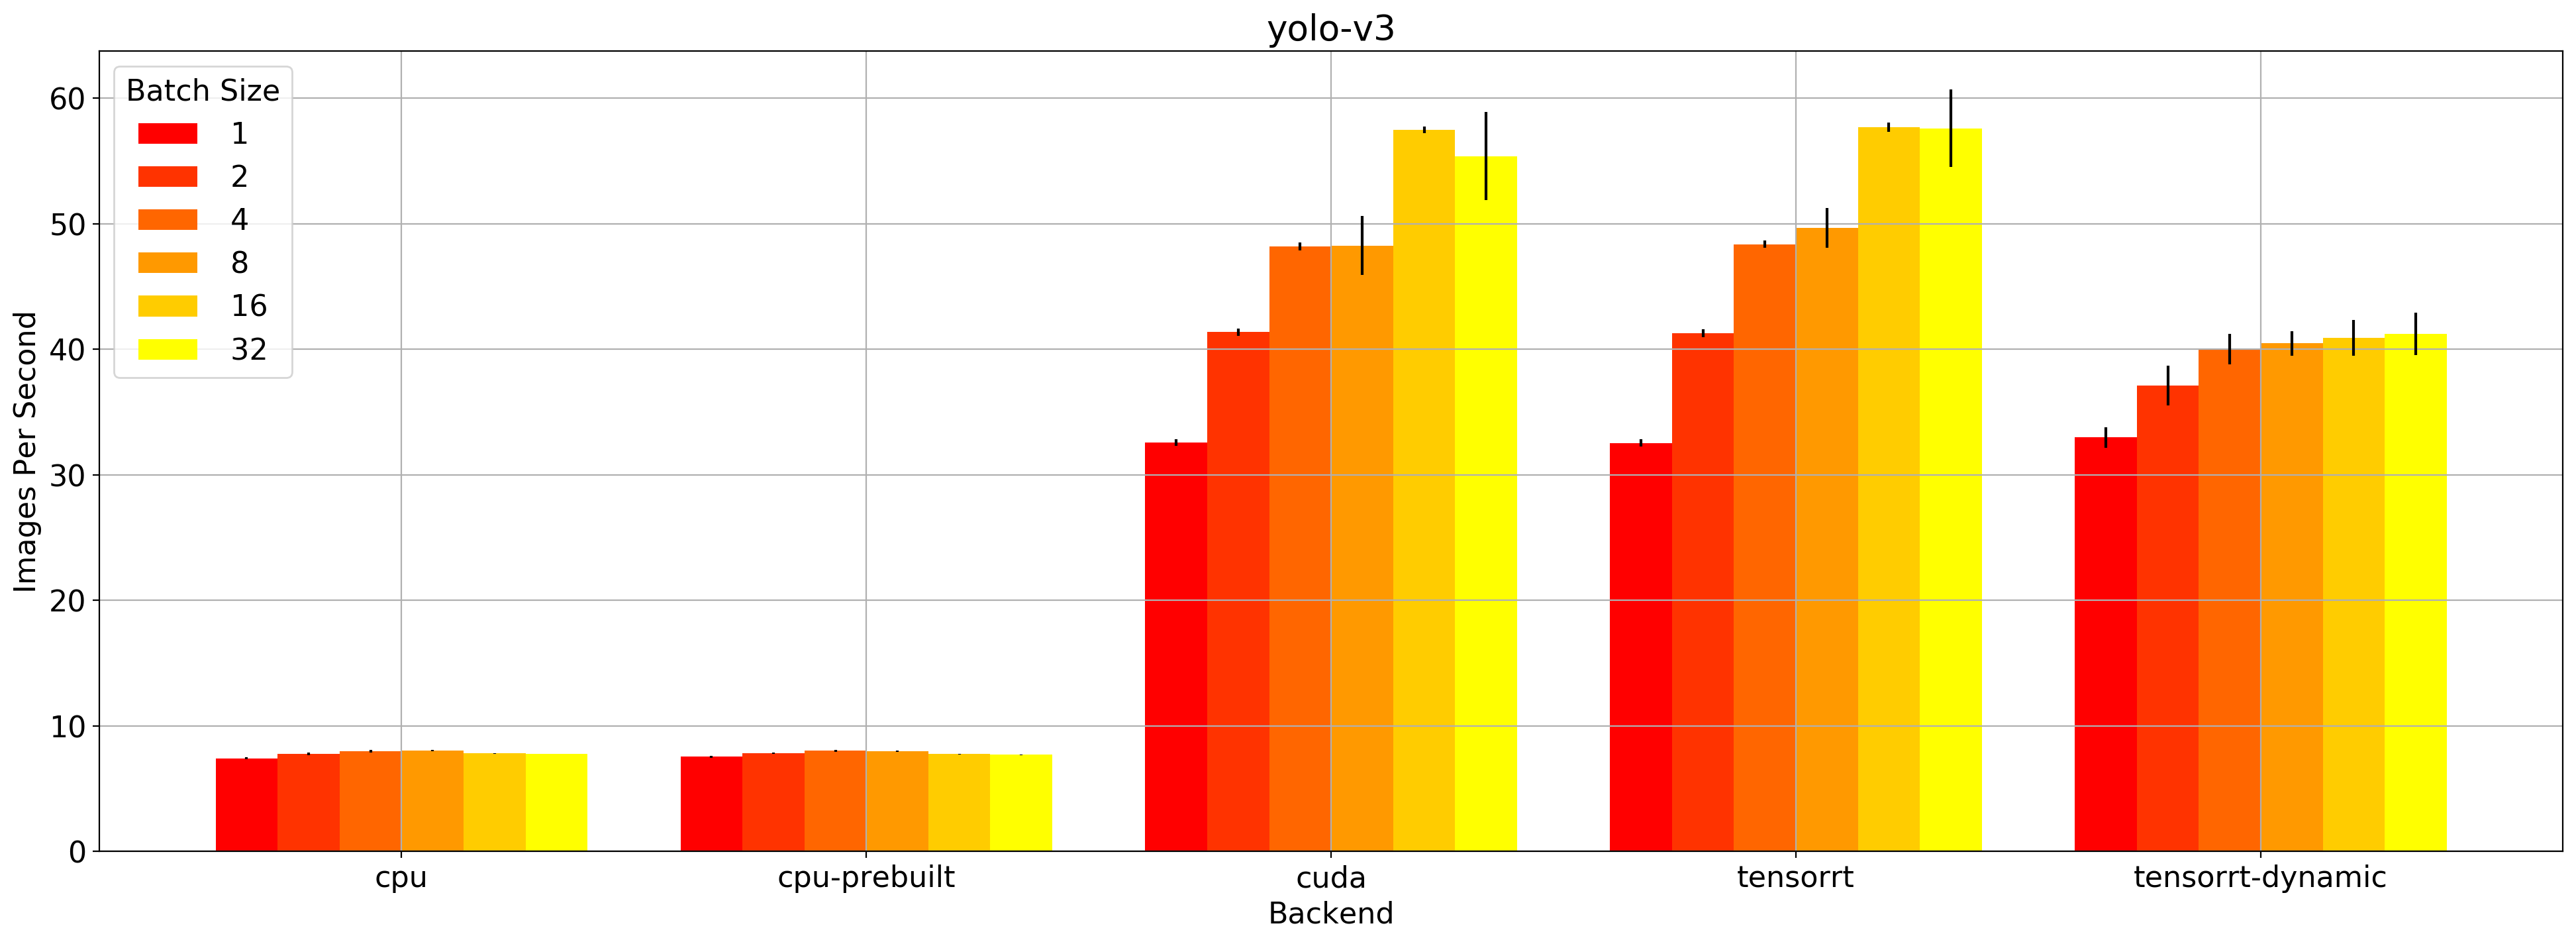

In [18]:
def plot_performance_per_model(df_raw, groupby_level='model', unstack_level=['batch_size'],
                               performance_metric=['avg_fps','avg_time_ms','graph_load_time_ms','images_load_time_avg_ms'],
                               save_fig=False, save_fig_name='performance.model.',
                               title=None, figsize=[default_figwidth, 8], rot=0, colormap=cm.autumn):
    # Bars.
    df_bar = pd.DataFrame(
        data=df_raw[performance_metric].values, columns=performance_metric,
        index=pd.MultiIndex.from_tuples(
            tuples=[ (m,b,bs,be,nr) for (m,b,bs,bc,be,ih,iw,nr) in df_raw.index.values ],
            names=[ 'model','backend','batch_size','batch_enabled','num_reps' ]            
        )
    )

    # Plot.
    mean  = df_bar.groupby(level=df_bar.index.names[:-1]).mean().unstack(unstack_level)
    std   = df_bar.groupby(level=df_bar.index.names[:-1]).std().unstack(unstack_level)
    axes  = mean \
            .groupby(level=groupby_level) \
            .plot(yerr=std, kind='bar', grid=True, rot=rot,
                  figsize=figsize, width=default_barwidth, fontsize=default_fontsize, legend=False, colormap=colormap)

    xlabel = 'Backend'
    xtics = df_bar.index.get_level_values('backend').drop_duplicates()
    ylabel = 'Images Per Second'
    for num, ax in enumerate(axes):
        # Title.
        ax.set_title(axes.keys().to_numpy().item(num))
        # X label.
        ax.set_xlabel(xlabel)
        # X ticks.
        ax.set_xticklabels(xtics)
        # Y axis.
        ax.set_ylabel(ylabel)
        # Legend.
        patches, labels = ax.get_legend_handles_labels()
        labels = [label[1] for label in [x.split(',') for x in labels]]
        labels = [x.strip(')') for x in labels]
        ax.legend(patches, labels, loc='best', title='Batch Size')
        # Save figure.
        if save_fig:
            save_fig_path = os.path.join(save_fig_dir, '%s.%s' % (save_fig_name+axes.keys().to_numpy().item(num), save_fig_ext))
            ax.figure.savefig(save_fig_path, dpi=default_figdpi, bbox_inches='tight')

plot_performance_per_model(dfs_perf, performance_metric=['avg_fps'], save_fig=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


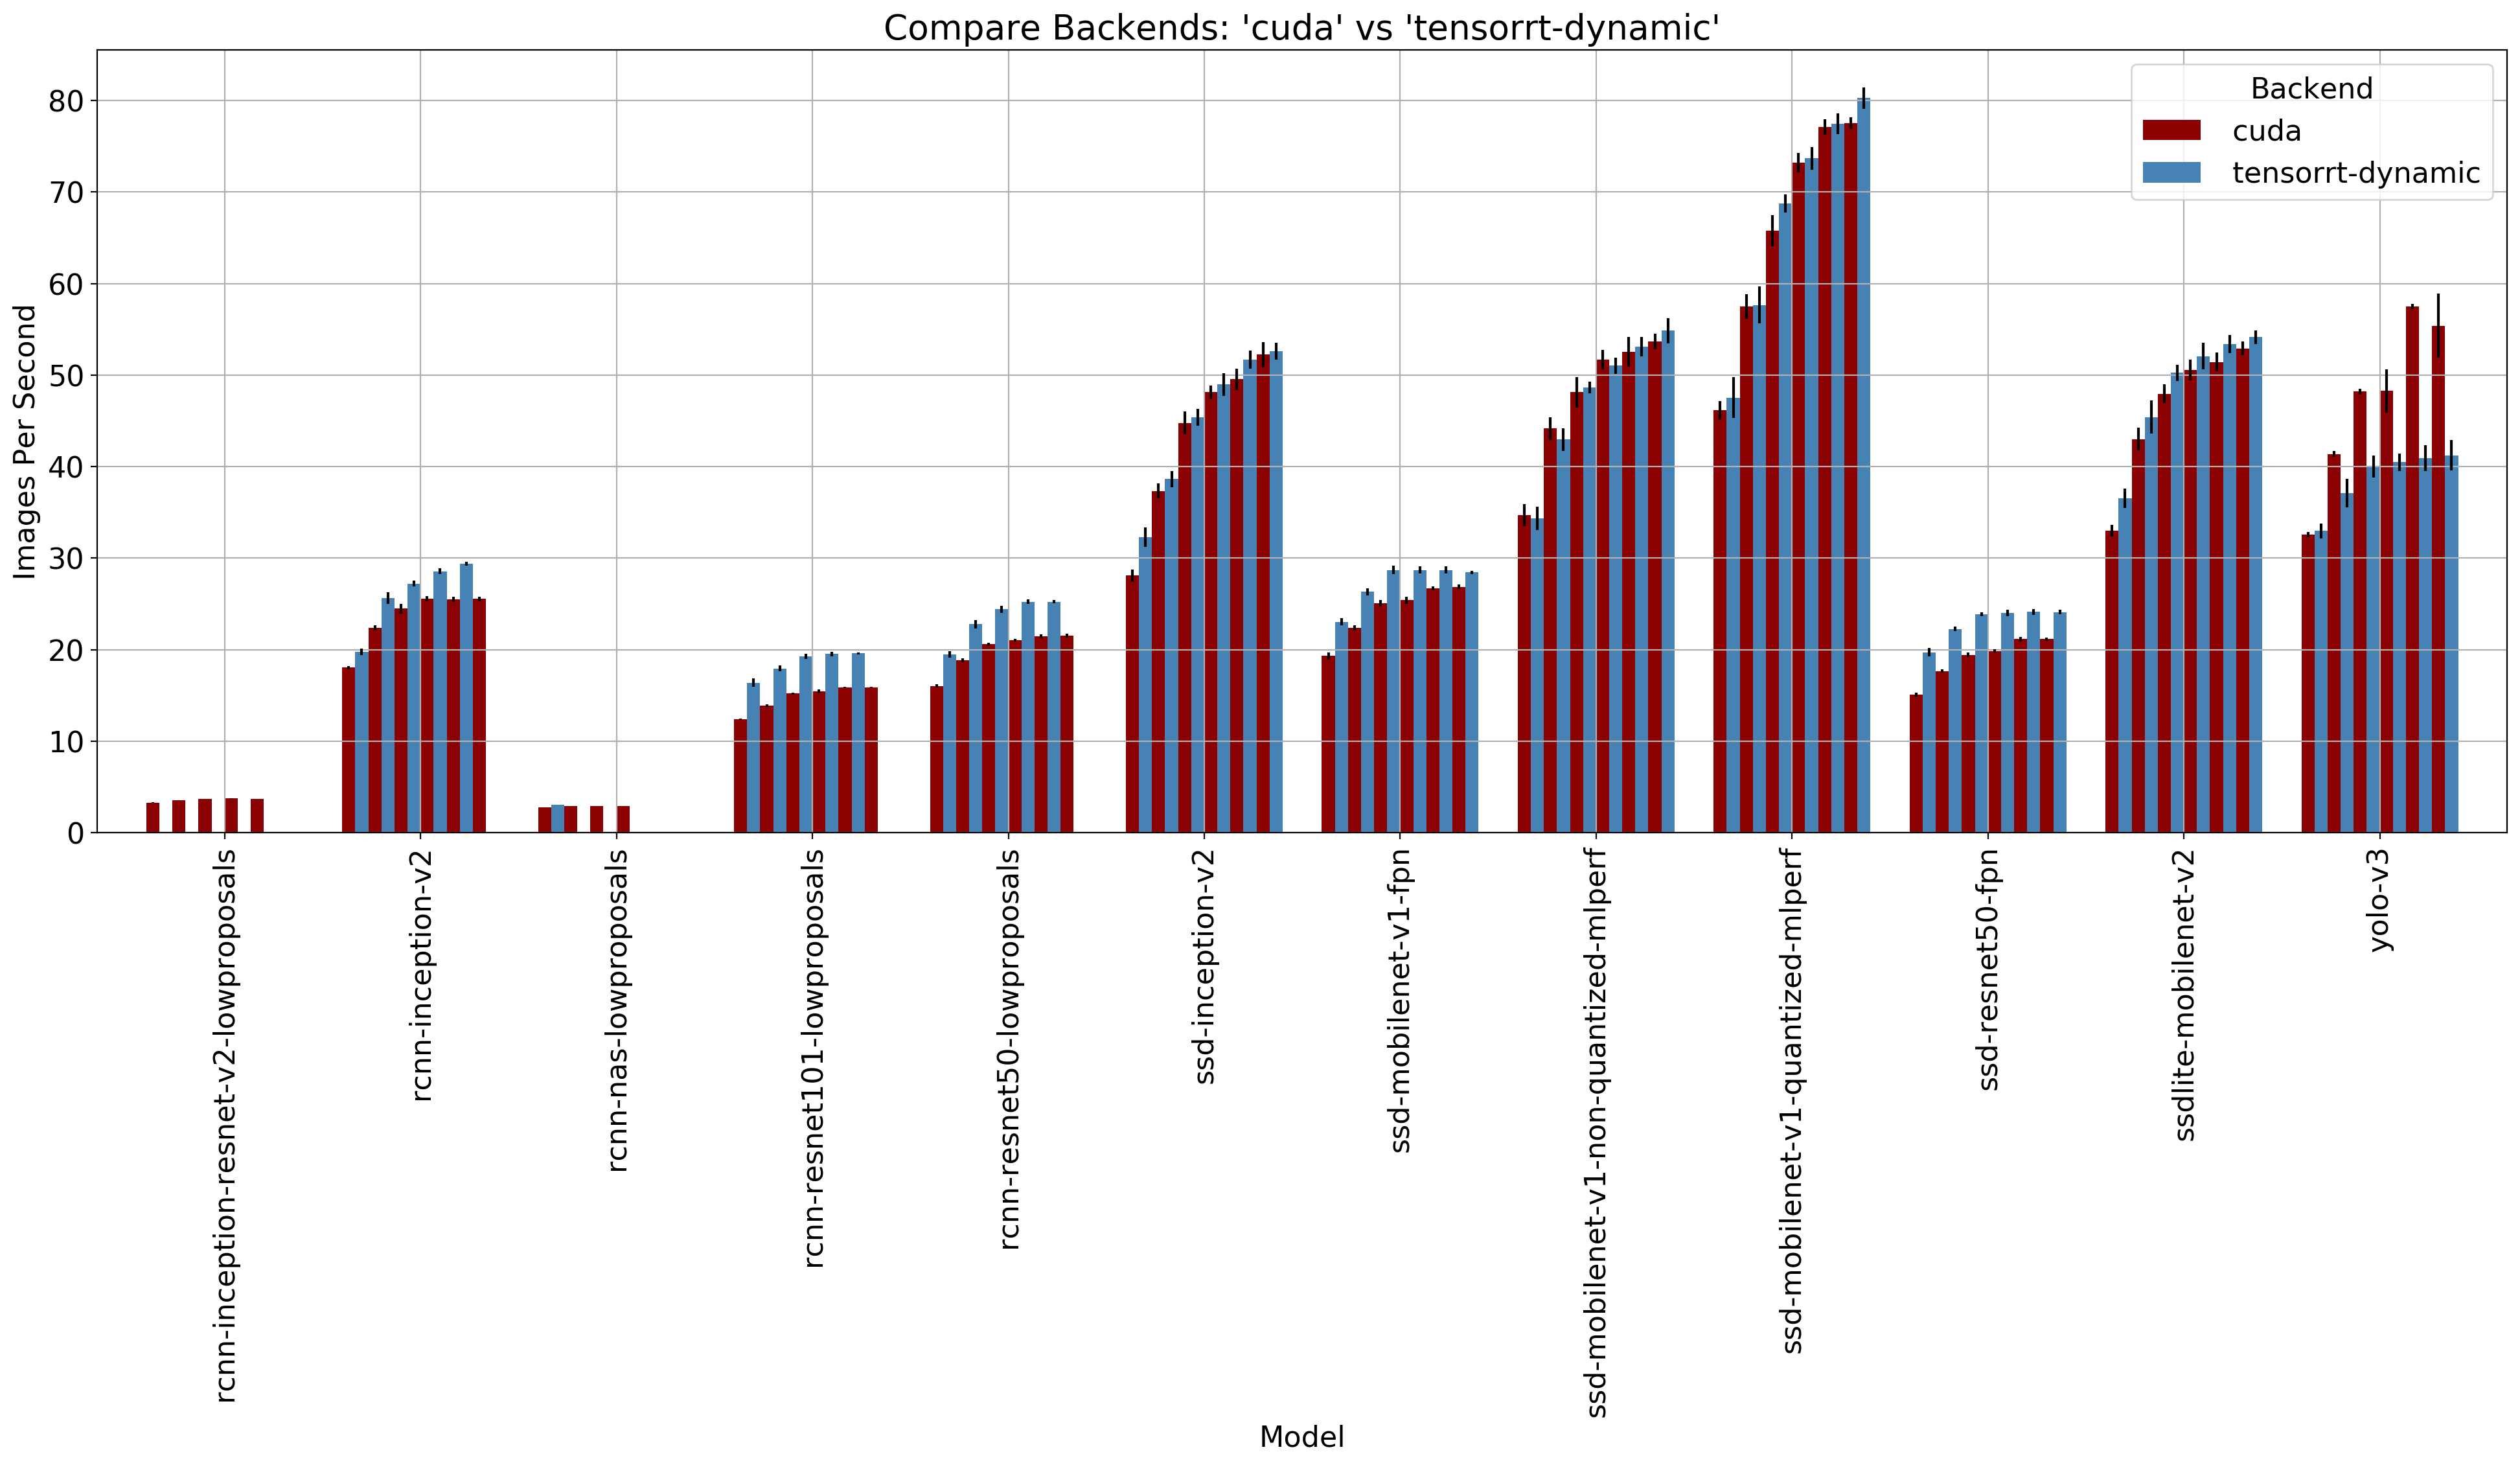

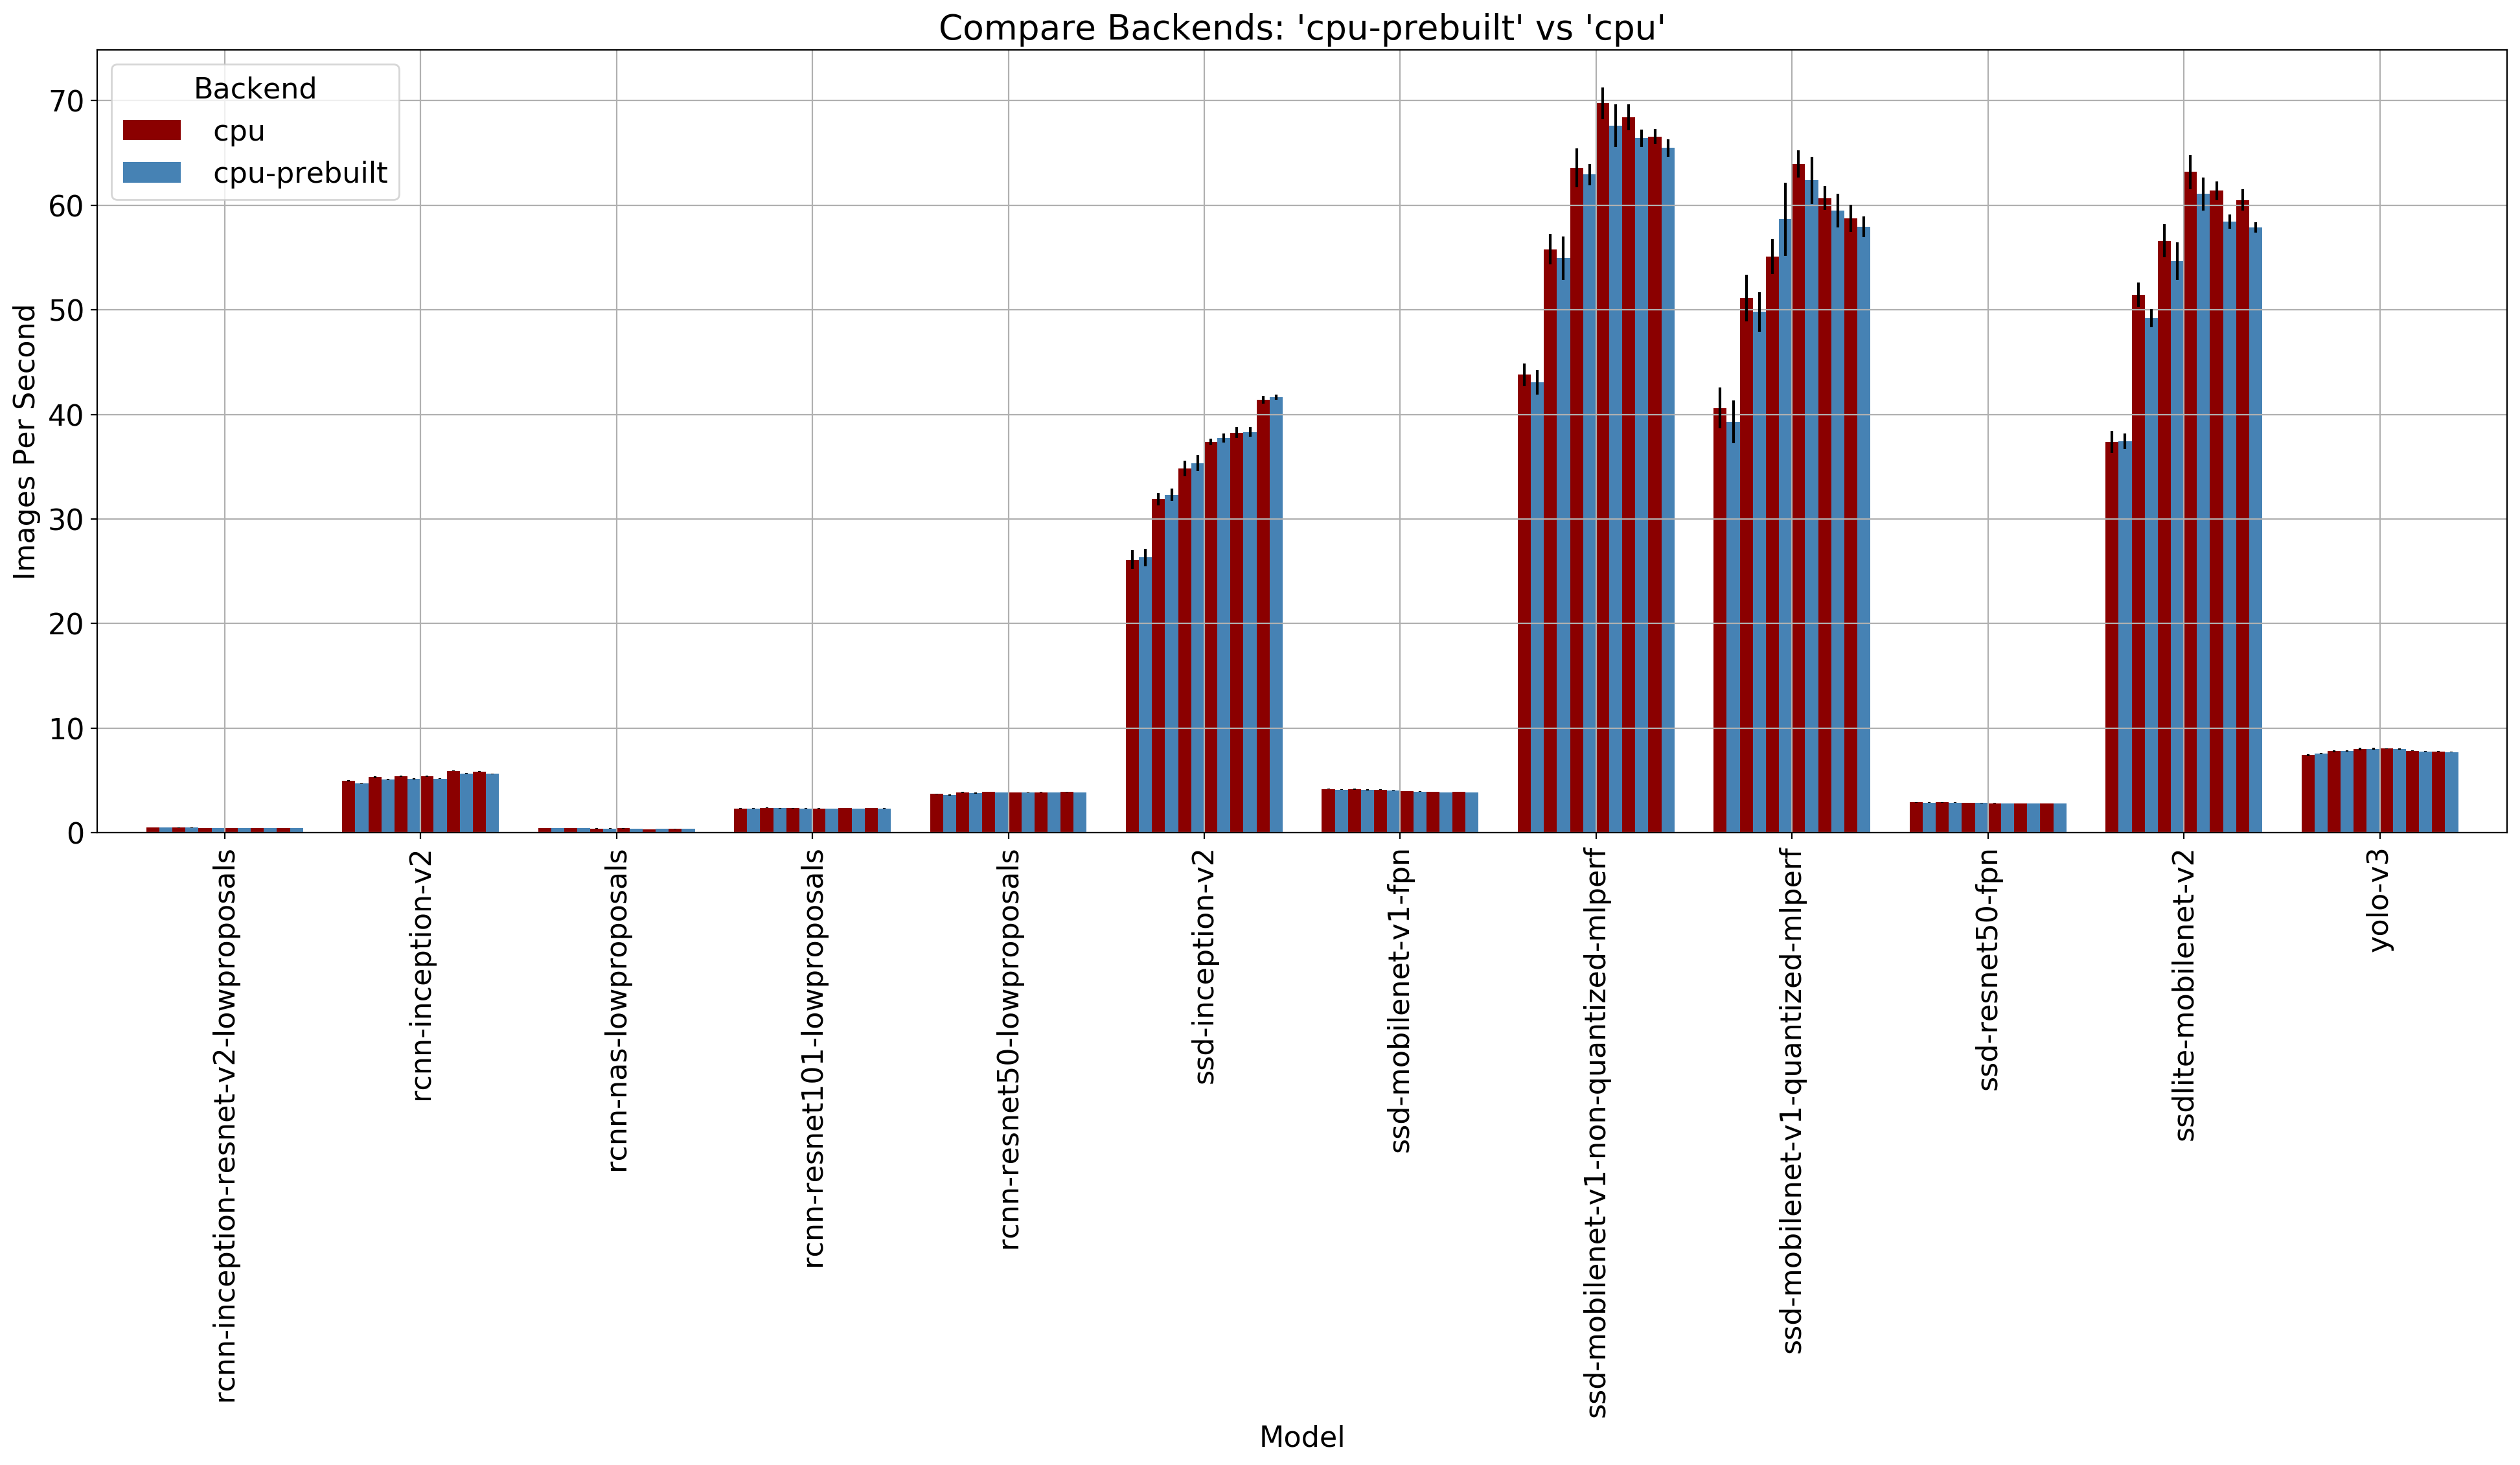

In [19]:
def plot_performance_compare_backends(df_raw, backends=['cuda','tensorrt-dynamic'],
                                      groupby_level='batch_enabled', unstack_level = ['backend','batch_size'],
                                      performance_metric=['avg_fps','avg_time_ms','graph_load_time_ms','images_load_time_avg_ms'], 
                                      save_fig=False, save_fig_name='performance.backend.cuda_vs_tensorrt-dynamic',
                                      title='', figsize=[default_figwidth, 8], rot=90):
    # Bars.
    df_bar = pd.DataFrame(
        data=df_raw[performance_metric].values, columns=performance_metric,
        index=pd.MultiIndex.from_tuples(
            tuples=[ (m,b,bs,be,nr) for (m,b,bs,bc,be,ih,iw,nr) in df_raw.index.values ],
            names=[ 'model','backend','batch_size','batch_enabled','num_reps' ]
        )
    )
    df_bar = df_bar.query('backend in @backends')

    # Colormap.
    colormap = mp.colors.ListedColormap(['darkred','steelblue'], name='from_list', N=12)
    
    # Plot.
    mean = df_bar.groupby(level=df_bar.index.names[:-1]).mean().unstack(unstack_level[1]).unstack(unstack_level[0])
    std  = df_bar.groupby(level=df_bar.index.names[:-1]).std().unstack(unstack_level[1]).unstack(unstack_level[0])
    axes = mean \
            .groupby(level=groupby_level) \
            .plot(yerr=std, kind='bar', grid=True, rot=rot, legend=False,
                  figsize=figsize, width=default_barwidth, fontsize=default_fontsize, colormap=colormap)

    xlabel = 'Model'
    xtics = df_bar.index.get_level_values('model').drop_duplicates()
    ylabel = 'Images Per Second'
    for num, ax in enumerate(axes):
        # Title.
        ax.set_title('Compare Backends: \'%s\' vs \'%s\'' % (backends[0], backends[1]))
        # X label.
        ax.set_xlabel(xlabel)
        # X ticks.
        ax.set_xticklabels(xtics)
        # Y axis.
        ax.set_ylabel(ylabel)
        # Legend.
        patches, labels = ax.get_legend_handles_labels()
        labels = [label[2] for label in [x.split(',') for x in labels]]
        labels = [x.strip(')') for x in labels]
        ax.legend(patches[:2], labels[:2], loc='left', title='Backend')

        # Save figure.
        if save_fig:
            save_fig_path = os.path.join(save_fig_dir, '%s.%s' % (save_fig_name+str(num), save_fig_ext))
            ax.figure.savefig(save_fig_path, dpi=default_figdpi, bbox_inches='tight')

plot_performance_compare_backends(dfs_perf, performance_metric=['avg_fps'], save_fig=True)
plot_performance_compare_backends(dfs_perf, performance_metric=['avg_fps'], save_fig=True,
                                  backends=['cpu-prebuilt','cpu'], save_fig_name='performance.backend.cpu-prebuilt_vs_cpu')

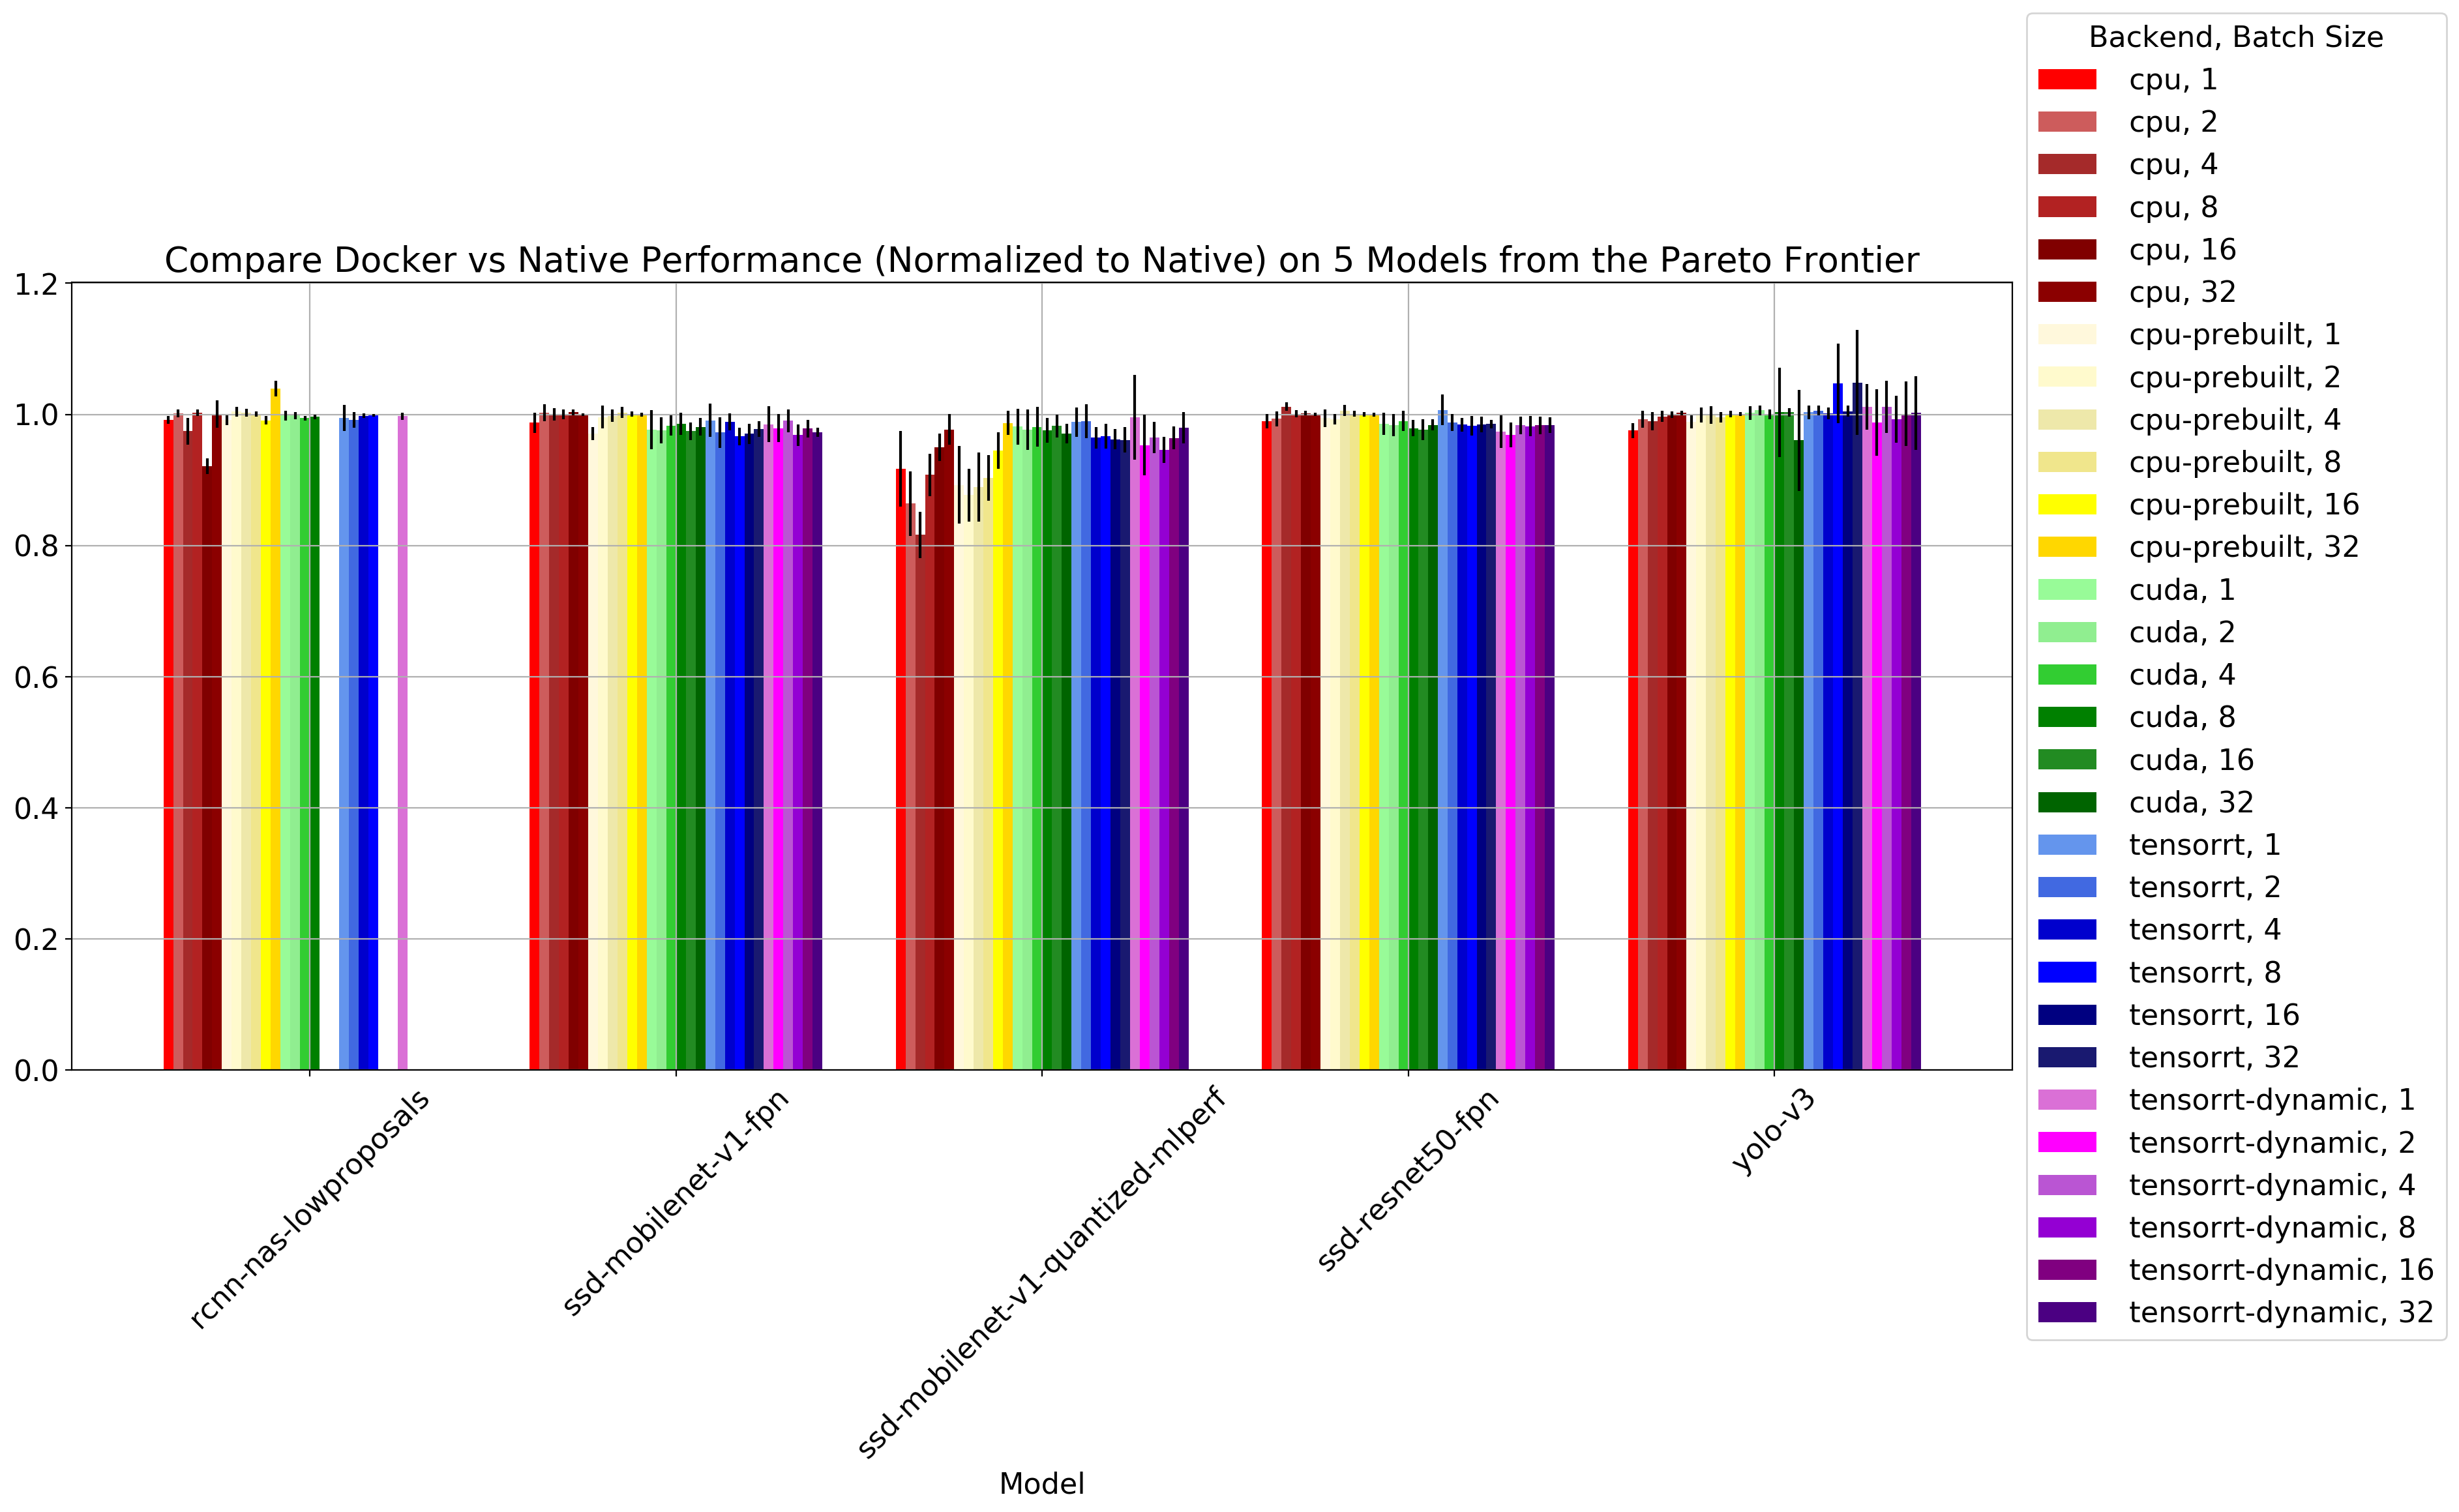

In [20]:
def plot_performance_compare_docker_vs_native(df_docker, df_native,
                                              groupby_level='batch_enabled', unstack_level=['batch_size','backend'],
                                              save_fig=False, save_fig_name='performance.docker_vs_native',
                                              title='', figsize=[default_figwidth, 8], rot=90):
    # Bars.
    df_docker = df_docker[df_docker.index.get_level_values('batch_enabled').isin([True])]
    df_bar = pd.merge(
        df_docker, df_native,
        how='inner', suffixes=('_docker', '_native'),
        on=[ 'model', 'backend', 'batch_size', 'batch_enabled', 'num_reps' ])
    df_bar = df_bar[['avg_fps_docker', 'avg_fps_native']]
    df_bar['avg_fps_norm'] = df_bar['avg_fps_docker'] / df_bar['avg_fps_native']
    df_bar = df_bar[['avg_fps_norm']]

    # Colormap.
    reds = ['red', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred']
    yellows = ['cornsilk', 'lemonchiffon', 'palegoldenrod', 'khaki', 'yellow', 'gold']
    greens = ['palegreen', 'lightgreen', 'limegreen', 'green', 'forestgreen', 'darkgreen']
    blues = ['cornflowerblue', 'royalblue', 'mediumblue', 'blue', 'navy', 'midnightblue']
    purples = ['orchid', 'fuchsia', 'mediumorchid', 'darkviolet', 'purple', 'indigo']
    colornames = reds + yellows + greens + blues + purples
    colormap = mp.colors.ListedColormap(colornames, name='from_list', N=len(colornames))
    
    # Plot.
    mean = df_bar.groupby(level=df_bar.index.names[:-1]).mean().unstack(unstack_level[1]).unstack(unstack_level[0])
    std = df_bar.groupby(level=df_bar.index.names[:-1]).std().unstack(unstack_level[1]).unstack(unstack_level[0])
    axes = mean \
            .groupby(level=groupby_level) \
            .plot(yerr=std, kind='bar', grid=True, rot=rot, ylim=[0.0,1.201],
                  figsize=figsize, width=default_barwidth, fontsize=default_fontsize, colormap=colormap)
    
    title  = 'Compare Docker vs Native Performance (Normalized to Native) on 5 Models from the Pareto Frontier'
    xtics  = df_bar.groupby(level=df_bar.index.names[:-1]).median().index.get_level_values('model').drop_duplicates()
    xlabel = 'Model'
    ylabel = ''
    for num, ax in enumerate(axes):
        # Title.
        ax.set_title(title)
        # X label.
        ax.set_xlabel(xlabel)
        # X ticks.
        ax.set_xticklabels(xtics)
        # Y axis.
        ax.set_ylabel(ylabel)
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        patches, labels = ax.get_legend_handles_labels()
        # Legend.
        labels = [x.strip('(avg_fps_norm,') for x in labels]
        labels = [x.strip(')') for x in labels]
        ax.legend(patches, labels, title='Backend, Batch Size', loc='center left', bbox_to_anchor=(1, 0.5),fontsize=default_fontsize)
        # Put a legend to the right of the current axis.
        if save_fig:
            save_fig_path = os.path.join(save_fig_dir, '%s.%s' % (save_fig_name, save_fig_ext))
            ax.figure.savefig(save_fig_path, dpi=default_figdpi, bbox_inches='tight')    
    
plot_performance_compare_docker_vs_native(dfs_perf, dfs_perf_native, rot=45, save_fig=True)

<a id="plot_exploration"></a>
### Plot exploration

In [21]:
# Plotting settings.
model_to_color = { 
        'rcnn-inception-resnet-v2-lowproposals'   : 'gold',
        'rcnn-inception-v2'                       : 'goldenrod',
        'rcnn-nas-lowproposals'                   : 'red',
        'rcnn-resnet101-lowproposals'             : 'brown',
        'rcnn-resnet50-lowproposals'              : 'orangered',
    
        'ssd-mobilenet-v1-fpn'                    : 'cyan',
        'ssd-inception-v2'                        : 'cadetblue',
        'ssd-mobilenet-v1-non-quantized-mlperf'   : 'deepskyblue',
        'ssd-mobilenet-v1-quantized-mlperf'       : 'royalblue',
        'ssd-resnet50-fpn'                        : 'navy',
    
        'ssdlite-mobilenet-v2'                    : 'violet',
        'yolo-v3'                                 : 'gray'
}

backend_to_marker = {
        'tensorrt'         : '1',
        'tensorrt-dynamic' : '2',
        'cuda'             : '3',
        'cpu'              : '4',
        'cpu-prebuilt'     : '+'
}

resize_to_marker = {
        'no-resize'    : 'x',
        'model-resize' : '*'
}

bs_to_size = {
        1  : 1.0,
        2  : 1.5,
        4  : 2.0,
        8  : 2.5,
        16 : 3.0,
        32 : 3.5
}

### not used anymore, left in case should change the policy
#     model_to_real_name = { 
#         'ssd-mobilenet-v1-fpn'                                : 'ssd_mobilenet_v1_fpn_coco',
#         'rcnn-inception-resnet-v2-lowproposals'    : 'faster_rcnn_inception_resnet_v2_atrous_lowproposals_coco',
#         'rcnn-nas-lowproposals'                   : 'faster_rcnn_nas_lowproposals_coco',
#         'rcnn-resnet101-lowproposals'             : 'faster_rcnn_resnet101_lowproposals_coco',
#         'rcnn-inception-v2'                       : 'faster_rcnn_inception_resnet_v2_atrous_coco',
#         'rcnn-nas-non-lowproposal'               : 'faster_rcnn_nas',
#         'ssd-inception-v2'                        : 'ssd_inception_v2_coco',
#         'ssd-mobilenet-v1-non-quantized-mlperf'            : 'ssd_mobilenet_v1_coco',
#         'ssd-mobilenet-v1-quantized-mlperf'                : 'ssd_mobilenet_v1_quantized_coco',
#         'ssd-resnet50-fpn'                           : 'ssd_resnet_50_fpn_coco',
#         'ssdlite-mobilenet-v2'                                : 'ssdlite_mobilenet_v2_coco',
#         'rcnn-resnet50-lowproposals'              : 'faster_rcnn_resnet50_lowproposals_coco',
#         'yolo-v3'                                   : 'yolo v3'
#     }

import matplotlib.lines as mlines
mark1 = mlines.Line2D([], [], color='black', marker='1', linestyle='None',
                          markersize=5, label='tensorrt')
mark2 = mlines.Line2D([], [], color='black', marker='2', linestyle='None',
                          markersize=5, label='tensorrt-dynamic')
mark3 = mlines.Line2D([], [], color='black', marker='3', linestyle='None',
                          markersize=5, label='cuda')
mark4 = mlines.Line2D([], [], color='black', marker='4', linestyle='None',
                          markersize=5, label=' cpu')
mark5 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
                          markersize=5, label=' cpu-prebuilt')
handles2 = [ mark1, mark2, mark3, mark4, mark5 ]

#mark1 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
#                          markersize=5, label='no resize')
#mark2 = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
#                          markersize=5, label='model resize')
#handles2 = [ mark1,mark2 ]

In [22]:
def merge_performance_accuracy(df_performance, df_accuracy, 
                               performance_metric='avg_fps', accuracy_metric='mAP', ideal=False):
    df = df_performance[[performance_metric]]
    
    for metric in accuracy_metric:
        accuracy_list = []
        for index, row in df.iterrows():
            (model, backend, batch_size, batch_count, batch_enabled, image_height, image_width, num_reps) = index
            if ideal:
                accuracy = df_accuracy.loc[(model, 'cuda', 1, 5000, False, image_height, image_width, 1)][metric]
            else:
                resize = 'no-resize' if batch_size == 1 else 'model-resize'
                if resize == 'no-resize' or model == 'yolo-v3':
                    accuracy = df_accuracy.loc[(model, 'cuda', 1, 5000, False, image_height, image_width, 1)][metric]
                else:
                    accuracy = df_accuracy.loc[(model, 'cuda', 1, 5000, True, image_height, image_width, 1)][metric]
            accuracy_list.append(accuracy)

        # Assign to the value of accuracy_metric.
        kwargs = { metric : accuracy_list }
        df = df.assign(**kwargs)
    return df

In [23]:
def finalize_plot(ax, xmin, xmax, xstep, ymin, ymax, ystep, save_fig, save_fig_name, accuracy_metric):
    # X axis.
    xlabel = 'Images Per Second'
    ax.set_xlabel(xlabel)
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(np.arange(xmin, xmax, xstep))
    for xtick in ax.xaxis.get_major_ticks(): xtick.label.set_fontsize(5)
    # Y axis.
    ylabel = accuracy_metric + ' %'
    ax.set_ylabel(ylabel)
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(np.arange(ymin, ymax, ystep))
    for ytick in ax.yaxis.get_major_ticks(): ytick.label.set_fontsize(5)
    # Legend.
    handles = [ 
        mp.patches.Patch(color=color, label=model)
        for (model, color) in sorted(model_to_color.items())
    ]
    handles += handles2
    plt.legend(title='', handles=handles[::-1], loc='best', prop={'size': 5})
    
    # Show with grid on.
    plt.grid(True)
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    
    # Save figure.
    if save_fig:
        save_fig_path = os.path.join(save_fig_dir, '%s.%s' % (save_fig_name, save_fig_ext))
        fig1.savefig(save_fig_path, dpi=default_figdpi, bbox_inches='tight')    

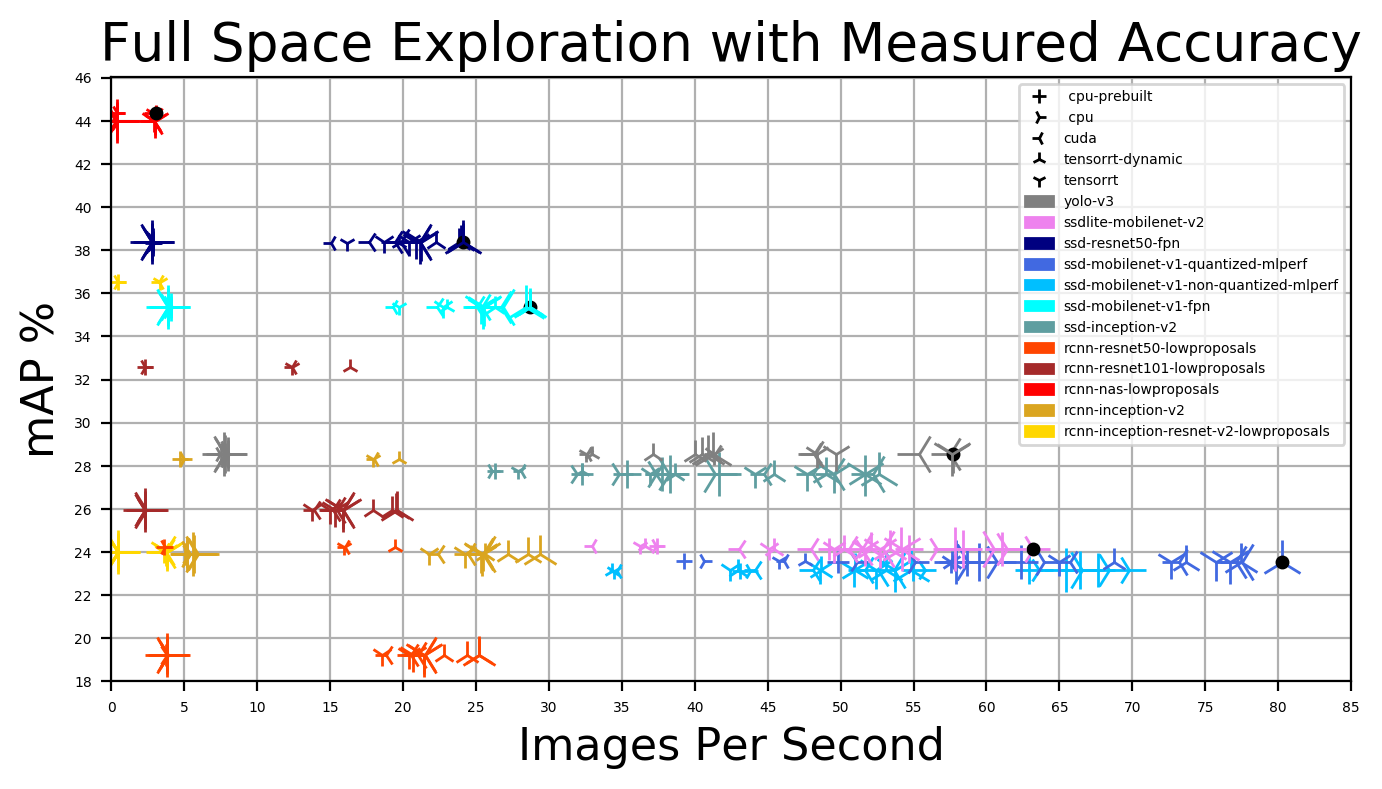

<Figure size 1200x800 with 0 Axes>

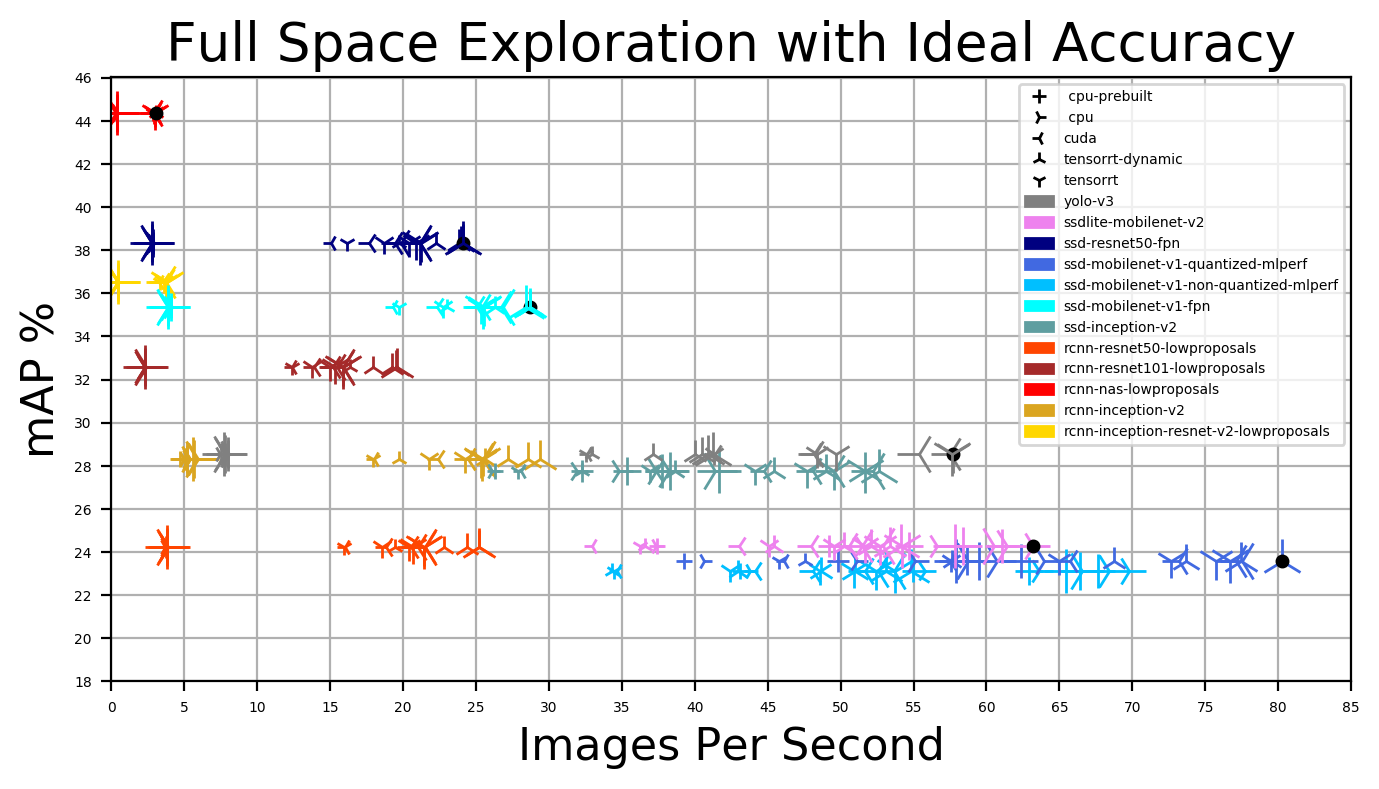

<Figure size 1200x800 with 0 Axes>

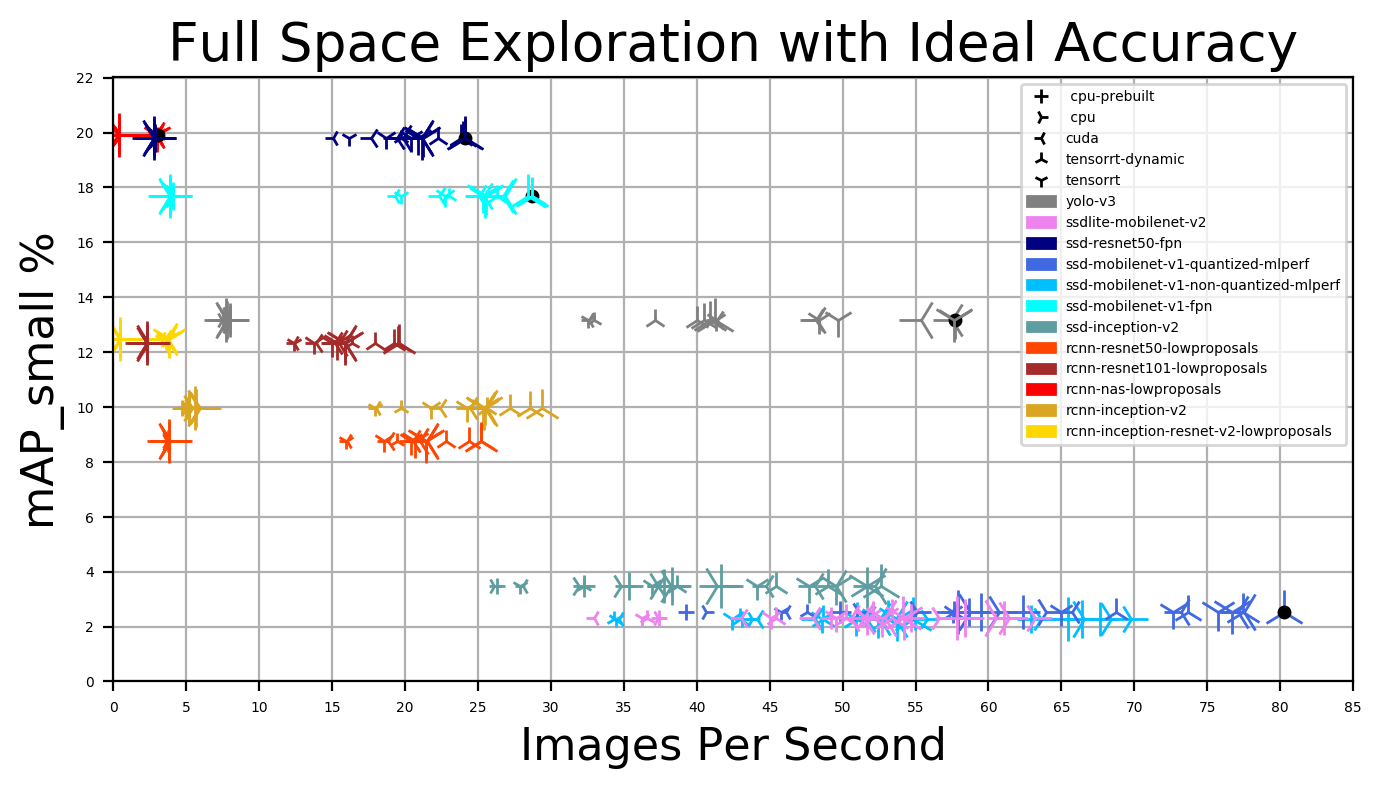

<Figure size 1200x800 with 0 Axes>

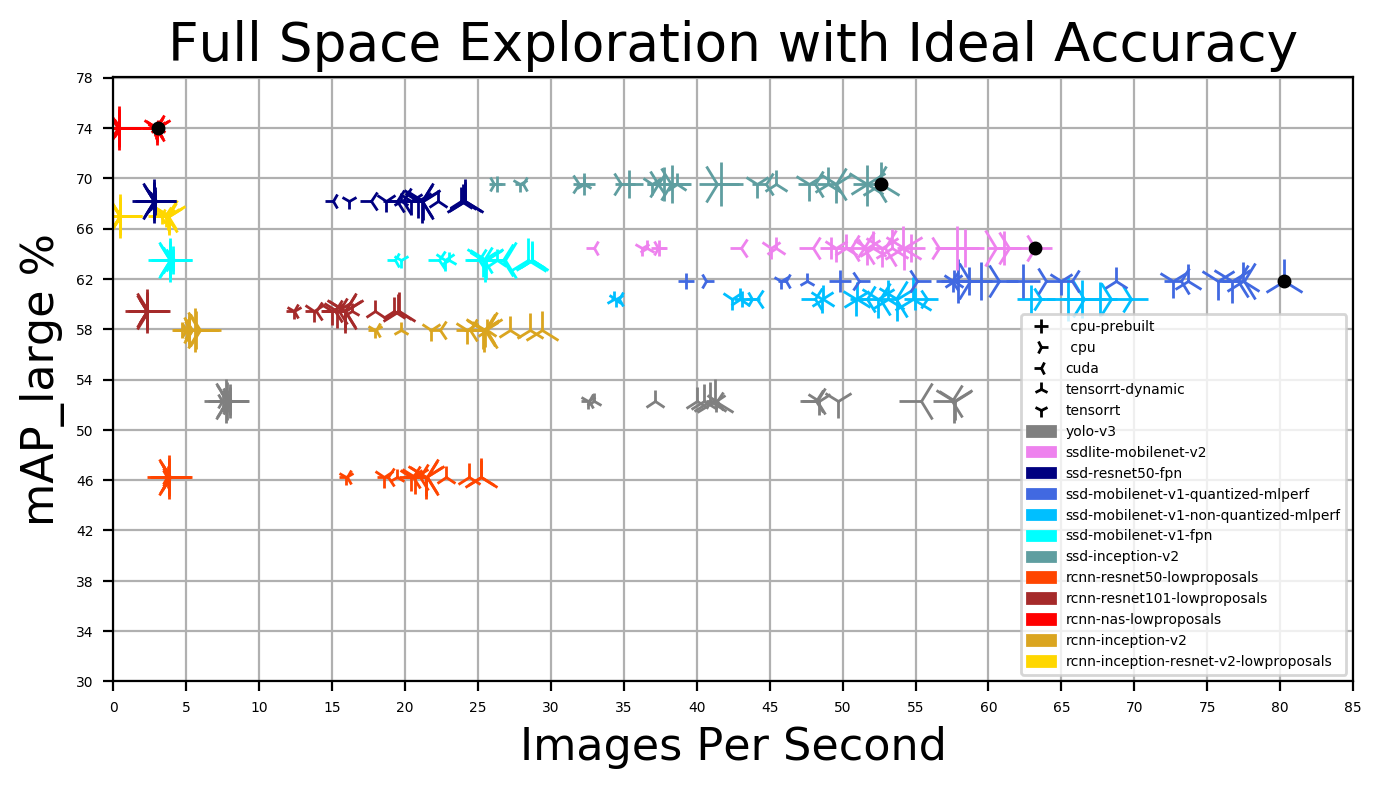

<Figure size 1200x800 with 0 Axes>

In [24]:
def plot_dse(ideal=False,
             performance_metric='avg_fps', accuracy_metric=['mAP'],
             xmin=0.00, xmax=85.01, xstep=5,
             ymin=18.00, ymax=46.01, ystep=4,
             save_fig=False, save_fig_name='dse.full'):
    fig = plt.figure(figsize=(8,4), dpi=default_figdpi)
    ax = fig.gca()
    if ideal:
        save_fig_name += '.ideal'
        ax.set_title('Full Space Exploration with Ideal Accuracy')
    else:
        ax.set_title('Full Space Exploration with Measured Accuracy')
    df_performance_accuracy = merge_performance_accuracy(
        dfs_perf, dfs, performance_metric=performance_metric, accuracy_metric=accuracy_metric, ideal=ideal)

    df = df_performance_accuracy
    df = df.groupby(level=df.index.names[:-1]).mean()
    #display_in_full(df)
    accuracy_metric=accuracy_metric[0]
    for index, row in df.iterrows():
        (model, backend, batch_size, batch_count, batch_enabled, image_height, image_width) = index
        performance = row[performance_metric]
        accuracy = row[accuracy_metric]

        # Mark Pareto-optimal points.
        is_on_pareto = True
        for index1, row1 in df.iterrows():
            is_no_slower = row1[performance_metric] >= row[performance_metric]
            is_no_less_accurate = row1[accuracy_metric] >= row[accuracy_metric]
            is_faster = row1[performance_metric] > row[performance_metric]
            is_more_accurate = row1[accuracy_metric] > row[accuracy_metric]
            if ((is_faster and is_no_less_accurate) or (is_more_accurate and is_no_slower)):
                is_on_pareto = False
                break

        # Select marker, color and size.
        marker = backend_to_marker[backend]
        color = model_to_color[model]
        size = 2 + 4*bs_to_size[batch_size]

        # Plot.
        ax.plot(performance, accuracy, marker, markerfacecolor=color, markeredgecolor=color, markersize=size)

        # Mark Pareto-optimal points with scaled black pluses.
        if is_on_pareto:
            ax.plot(performance, accuracy, 'o', markersize=4,markerfacecolor='black', markeredgecolor='black')

    finalize_plot(ax, xmin, xmax, xstep, ymin, ymax, ystep, save_fig, save_fig_name, accuracy_metric)
    
# NB: The accuracy metric has to be an array of 1 element for this function.
plot_dse (ideal=False, ystep=2, save_fig=True, save_fig_name='dse.full')
plot_dse (ideal=True,  ystep=2, save_fig=True, save_fig_name='dse.full')
plot_dse (ideal=True, accuracy_metric=['mAP_small'], ymin=0,  ymax=22.01, ystep=2, save_fig=True, save_fig_name='dse.full.small')
plot_dse (ideal=True, accuracy_metric=['mAP_large'], ymin=30, ymax=78.01, ystep=4, save_fig=True, save_fig_name='dse.full.large')

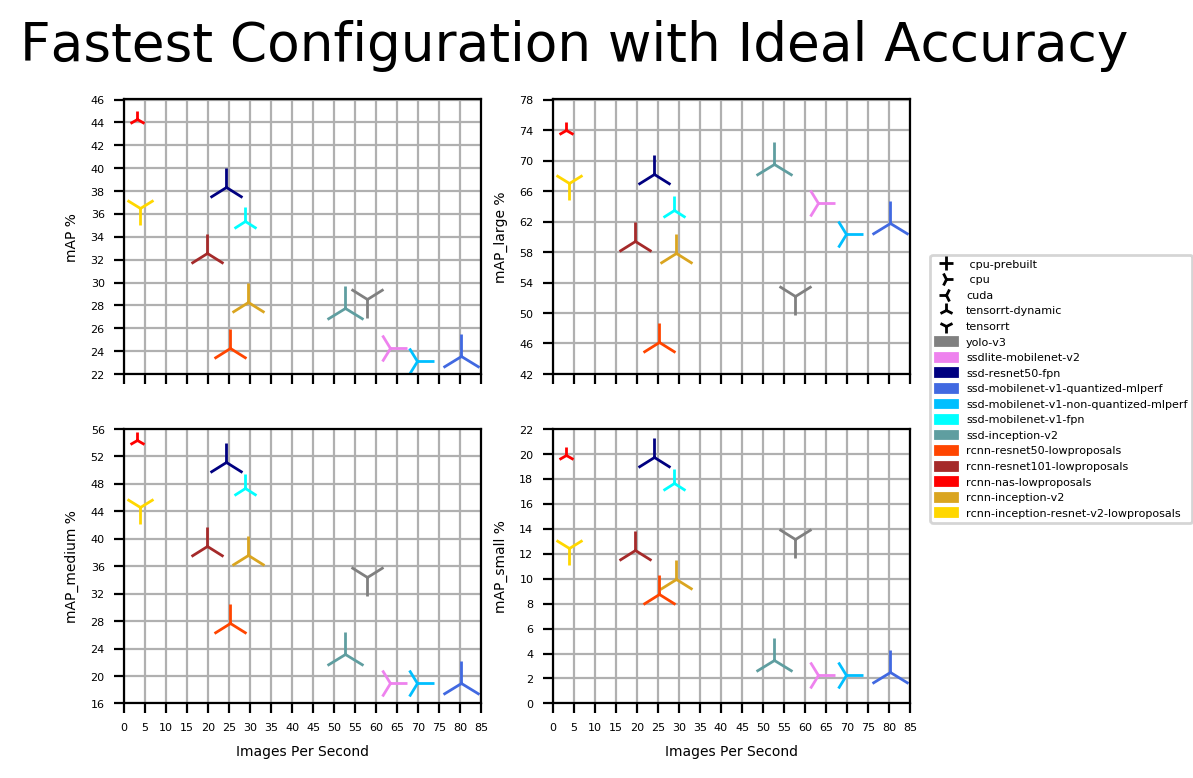

<Figure size 1200x800 with 0 Axes>

In [25]:
def plot_fastest(ideal=False,
                 performance_metric='avg_fps', accuracy_metric=['mAP','mAP_large','mAP_medium','mAP_small'],
                 xmin=0.0, xmax=85.01, xstep=5,
                 ymin=[22,42,16,0], ymax=[46.01,78.01,56.01,22.01], ystep=[2,4,4,2],
                 labelsize=5, ticksize=4,
                 save_fig=False, save_fig_name='dse.fastest'):
    
    fig,ax = plt.subplots(2,2,sharex='col')
    if ideal:
        save_fig_name += '.ideal'
        fig.suptitle('Fastest Configuration with Ideal Accuracy')
    else:
        fig.suptitle('Fastest Configuration with Measured Accuracy')
    df_performance_accuracy = merge_performance_accuracy(
        dfs_perf, dfs, performance_metric=performance_metric, accuracy_metric=accuracy_metric, ideal=ideal)
    df_full = df_performance_accuracy
    for num,metric in enumerate (accuracy_metric):
        pos = (int(num/2),num%2)
        df = df_full[[metric,performance_metric]]
        df = df.groupby(level=df.index.names[:-1]).mean()
        df = df.groupby(level=df.index.names[:-4]).max()
        #display_in_full(df)
        points_to_plot=[]
        for index, row in df.iterrows():
            (model,backend, batch_size) = index
            performance = row[performance_metric]
            accuracy = row[metric]
            plot = True
            # Analyze points of the same model.
            for index1, row1 in df.iterrows():
                if index == index1:
                    continue
                if index1[0] != model:
                    continue
                is_faster = row1[performance_metric] > row[performance_metric]
                if is_faster:
                    plot = False
                    continue

            if plot: # no faster points have been found with the same model.
                # Select marker, color and size.
                marker = backend_to_marker[backend]
                color = model_to_color[model]
                size = 2 + 4*bs_to_size[batch_size]
                # Plot.
                ax[pos[0],pos[1]].plot(performance, accuracy, marker, markerfacecolor=color, markeredgecolor=color, markersize=size)
        ax[pos[0],pos[1]].grid(True)
        
    # X axis.
    xlabel = 'Images Per Second'
    ax[1,0].set_xlabel(xlabel, fontsize=labelsize)
    ax[1,0].set_xlim(xmin, xmax)
    ax[1,0].set_xticks(np.arange(xmin, xmax, xstep))
    for xtick in ax[1,0].xaxis.get_major_ticks(): xtick.label.set_fontsize(ticksize)
    ax[1,1].set_xlabel(xlabel, fontsize=labelsize)
    ax[1,1].set_xlim(xmin, xmax)
    ax[1,1].set_xticks(np.arange(xmin, xmax, xstep))
    for xtick in ax[1,1].xaxis.get_major_ticks(): xtick.label.set_fontsize(ticksize)
    
    # Y axis.
    ylabel = accuracy_metric[0]+' %'
    ax[0,0].set_ylabel(ylabel, fontsize=labelsize)
    ax[0,0].set_ylim(ymin[0], ymax[0])
    ax[0,0].set_yticks(np.arange(ymin[0], ymax[0], ystep[0]))
    for ytick in ax[0,0].yaxis.get_major_ticks(): ytick.label.set_fontsize(ticksize)
        
    ylabel = accuracy_metric[1]+' %'
    ax[0,1].set_ylabel(ylabel, fontsize=labelsize)
    ax[0,1].set_ylim(ymin[1], ymax[1])
    ax[0,1].set_yticks(np.arange(ymin[1], ymax[1], ystep[1]))
    for ytick in ax[0,1].yaxis.get_major_ticks(): ytick.label.set_fontsize(ticksize)
        
    ylabel = accuracy_metric[2]+' %'
    ax[1,0].set_ylabel(ylabel, fontsize=labelsize)
    ax[1,0].set_ylim(ymin[2], ymax[2])
    ax[1,0].set_yticks(np.arange(ymin[2], ymax[2], ystep[2]))
    for ytick in ax[1,0].yaxis.get_major_ticks(): ytick.label.set_fontsize(ticksize)
        
    ylabel = accuracy_metric[3]+' %'
    ax[1,1].set_ylabel(ylabel, fontsize=labelsize)
    ax[1,1].set_ylim(ymin[3], ymax[3])
    ax[1,1].set_yticks(np.arange(ymin[3], ymax[3], ystep[3]))
    for ytick in ax[1,1].yaxis.get_major_ticks(): ytick.label.set_fontsize(ticksize)
    
    # Legend.
    handles = [ 
        mp.patches.Patch(color=color, label=model)
        for (model, color) in sorted(model_to_color.items())
    ]
    handles += handles2
    fig.legend(title='', handles=handles[::-1], 
               loc='center right',
               borderaxespad=0.1,
               fontsize=4)
    plt.subplots_adjust(right=0.78)
    # Show with grid on.
    plt.grid(True)
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    
    # Save figure.
    if save_fig:
        save_fig_path = os.path.join(save_fig_dir, '%s.%s' % (save_fig_name, save_fig_ext))
        fig1.savefig(save_fig_path, dpi=default_figdpi, bbox_inches='tight')        
        
plot_fastest(ideal=True, save_fig=True)